# Notebook to plot all PS and ND so far

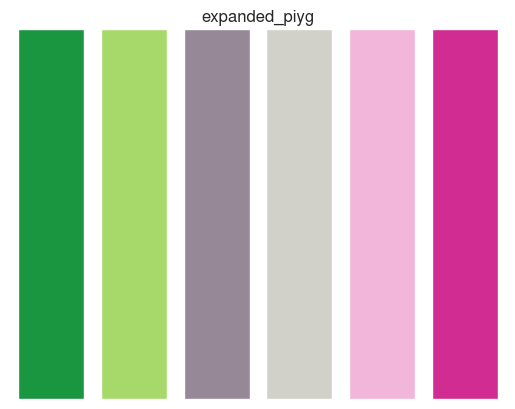

1043591

In [1]:
import os
import glob
import re
import random
import csv
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from skimage import io
from tqdm.auto import tqdm
import napari
from macrohet import dataio, tile, tools, visualise, colours
from macrohet.notify import send_sys_message as notify
import zarr
from timeout_decorator import timeout

# Set up the visual style and palette
sns.set_theme(style='white', font='Nimbus Sans')
palette = colours.expanded_piyg

# Constants
fluo_scaling_factor = 1  # Adjusted for plotting, uncomment and adjust as necessary
meters_per_pixel = 1.4949402023919043E-07  # Meters per pixel conversion factor

# Silence specific warnings and apply DataFrame option context as needed
warnings.simplefilter(action='ignore', category=FutureWarning)
with pd.option_context('mode.use_inf_as_na', True):
    pass

# Define helper functions
def remove_outliers_iqr(series):
    """Remove outliers using the Interquartile Range (IQR) method."""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series >= lower_bound) & (series <= upper_bound)]

def richards_growth_arx(t, K, Q, B, v):
    """Richards growth model function."""
    return K / (1 + ((K / Q - 1) * np.exp(-B * t))**(1/v))
    #return K / (1 + ((K / N0 - 1) * np.exp(-b * t))**m)
def richards_growth(t, K, N0, r, m):
    """Richards growth model function."""
    # return K / (1 + ((K / Q - 1) * np.exp(-B * t))**(1/v))
    return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))

# Define the exponential growth function
def exponential_growth(t, N0, r):
    return N0 * np.exp(r * t)
    
def interpolate_nans(data):
    """Linearly interpolate missing (NaN) values in the data."""
    valid = ~np.isnan(data)
    invalid = np.isnan(data)
    data[invalid] = np.interp(np.flatnonzero(invalid), np.flatnonzero(valid), data[valid])
    return data

def replace_outlier(data):
    """Replace outliers in data using linear interpolation between neighbors."""
    Q1, Q3 = np.percentile(data, [25, 75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_indices = np.where((data < lower_bound) | (data > upper_bound))[0]
    
    for index in outlier_indices:
        if index == 0 or index == len(data) - 1:  # Special cases for first and last elements
            replacement_value = data[min(max(index + 1, 0), len(data) - 1)]
        else:
            # For middle elements, find the closest non-outliers
            prev_index, next_index = index - 1, index + 1
            while prev_index in outlier_indices and prev_index > 0:
                prev_index -= 1
            while next_index in outlier_indices and next_index < len(data) - 1:
                next_index += 1
            replacement_value = (data[prev_index] + data[next_index]) / 2.0
        data[index] = replacement_value
    return data

def compute_r_squared(actual, predicted):
    # Calculate the total sum of squares
    ss_tot = np.sum((actual - np.mean(actual)) ** 2)
    # Calculate the residual sum of squares
    ss_res = np.sum((actual - predicted) ** 2)
    # Calculate the R²
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

def check_consecutive_doubles(arr, window=5):
    min_sum = float('inf')
    max_sum = 0
    for i in range(len(arr) - window + 1):
        current_window_sum = np.sum(arr[i:i+window])
        min_sum = min(min_sum, current_window_sum)
        max_sum = max(max_sum, current_window_sum)
    return max_sum >= 2 * min_sum

def check_persistent_growth(arr, window=5):
    min_sum = float('inf')
    max_sum = 0
    for i in range(len(arr) - window + 1):
        current_window_sum = np.sum(arr[i:i+window])
        min_sum = min(min_sum, current_window_sum)
        max_sum = max(max_sum, current_window_sum)
    return max_sum >= 2 * min_sum

from matplotlib.colors import LinearSegmentedColormap
# Get the PiYG colormap
cmap_piyg = plt.get_cmap('PiYG')
N=6#len(condition_indices)
# Define the indices for the pink colors in PiYG
start_index = 0  # Start of pink colors
end_index = 128-50    # End of pink colors (PiYG has 256 colors)
# Extract the pink colors from PiYG
pink_colors = cmap_piyg(range(start_index, end_index + 1))
# Create a custom pink colormap
# custom_pink_cmap = LinearSegmentedColormap.from_list('CustomPink', pink_colors,  N=len(condition_indices))
# Calculate indices for evenly spaced colors
pink_indices = np.linspace(0, len(pink_colors) - 1, N, dtype=int)
custom_pink_cmap = pink_colors[pink_indices]

# Define the indices for the pink colors in PiYG
start_index = 128+50# Start of pink colors
end_index = 255    # End of pink colors (PiYG has 256 colors)

# Extract the pink colors from PiYG
green_colors = cmap_piyg(range(start_index, end_index + 1))
green_colors = np.flip(green_colors, axis = 0)
# Create a custom pink colormap
# custom_green_cmap = LinearSegmentedColormap.from_list('CustomGreen', green_colors, N=len(condition_indices))
green_indices = np.linspace(0, len(green_colors) - 1, N, dtype=int)
custom_green_cmap = green_colors[green_indices]

### mapping colours to be teh same as last time
# Display the colors in the PiYG color map
visualise.show_colors('expanded_piyg')

# Get the color palette of the PiYG color map
# expanded_piyg = visualise.color_palette('expanded_piyg')
expanded_piyg = colours.expanded_piyg# [(n, i) for n, i in enumerate(colours.expanded_piyg)]

os.getpid()

In [2]:
visualise.color_palette('expanded_piyg')

# Load sc_df

In [2]:
base_dir = f'/mnt/SYNO/macrohet_syno/'
output_dir = '/mnt/SYNO/macrohet_syno/manuscript/results'

In [3]:
sc_df_fn = os.path.join(base_dir, 'manuscript/results/sc_df.pkl')

In [6]:
df = pd.read_pickle(sc_df_fn)

In [ ]:
df

# Plotting growth rate functions to underlying data

# Testing difficult cases

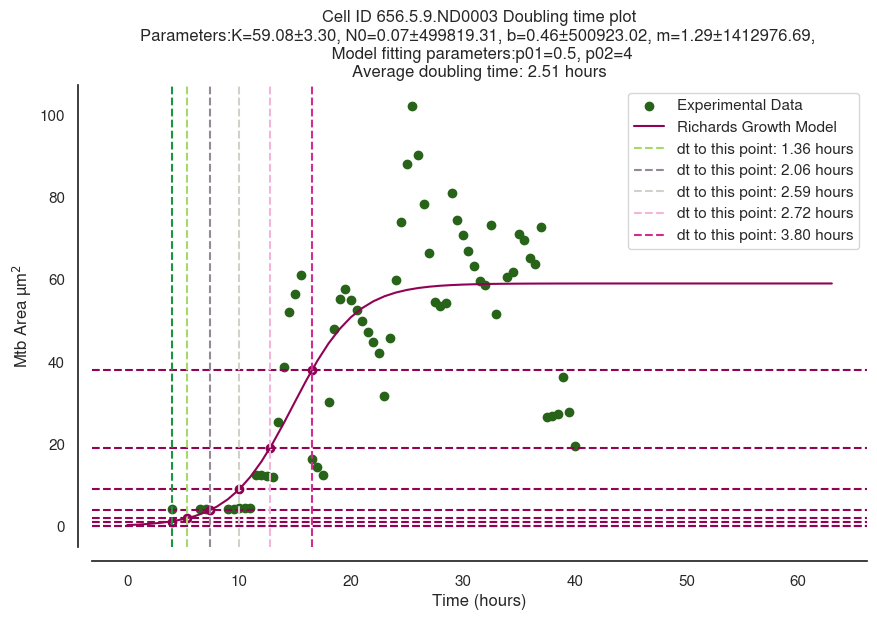

In [273]:
initial_guess = 1
p01, p02 = 0.5, 4

ID = '656.5.9.ND0003'

sc_dt_df = df[df['ID'] == ID]
        
# Extract nonzero bacterial population and replace outliers using IQR interpolation  
bacterial_population = interpolate_nans(sc_dt_df[sc_dt_df['Mtb Area (µm)'] != 0]['Mtb Area (µm)'].values) # replace_outlier(sc_dt_df[sc_dt_df['Mtb Area (µm)'] != 0]['Mtb Area (µm)'].values)
time_points = sc_dt_df[sc_dt_df['Mtb Area (µm)'] != 0]['Time (hours)']

if initial_guess:
    initial_guess = [max(bacterial_population), min(bacterial_population), p01, p02] # p01 = p02 = None #[max(bacterial_population), min(bacterial_population), p01, p02]

# Fit the Richards growth model to the data by supplying the max, min and 
params, covariance, info_dict, mesg, ier = curve_fit(richards_growth, time_points, bacterial_population, p0=initial_guess, full_output = True)
K, N0, b, m = params
cov_params = np.sqrt(np.diag(covariance)) #[round(i, 2) for i in np.sqrt(np.diag(covariance))]
if all(cov_params == np.inf):
    raise ValueError('No curve found. Unable to calculate parameters due to infinite covariance.')
# Create a time array for the model
time_model = np.linspace(0, len(bacterial_population)-1, len(time_points)) # np.linspace(0, len(bacterial_population)-1, 100)

# Calculate the model's bacterial population predictions
population_model = richards_growth(time_model, K, N0, b, m)

# Calculate the doubling points based on the population model
doubling_series = []
current_value = min(population_model) # used to be based on bacterial_population
while current_value <= max(population_model):
    doubling_series.append(int(current_value))
    current_value *= 2
    
# Plot the experimental data and the fitted model
plt.figure(figsize=(10, 6))
plt.scatter(time_points, bacterial_population, label='Experimental Data', color=green_colors[0])
plt.plot(time_model, population_model, label='Richards Growth Model', color=pink_colors[1])

# Plot the horizontal lines from the doubling series
for value in doubling_series:
    plt.axhline(y=value, color=pink_colors[2], linestyle='--',) 
                # label=f'Doubling Value: {value}')

# Perform linear interpolation to estimate population values at intermediate time points
interpolator = interp1d(time_model, population_model, kind='linear', fill_value='extrapolate')
interpolated_time_points = np.linspace(min(time_points), max(time_points), num=int(max(population_model))*100) # the number of points needs to be granular enough to cover every integer between min and max population values as then all intersections can be reliably found 
interpolated_population = [int(i) for i in interpolator(interpolated_time_points)]
# drop duplicate interpolated population values and corresponding time points
unique_interpolated_time_points = []
unique_interpolated_population = []
# Initialize a set to keep track of seen population values
seen_population_values = set()
# Iterate through the lists and append unique population values
for time, population in zip(interpolated_time_points, interpolated_population):
    if population not in seen_population_values:
        unique_interpolated_time_points.append(time)
        unique_interpolated_population.append(population)
        seen_population_values.add(population)

# Find and mark the intersections between the interpolated population and the doubling series
intersections = [(t, N) for t, N in zip(unique_interpolated_time_points, unique_interpolated_population) if N in doubling_series]
for t, N in intersections:
    plt.plot(t, N, 'o', markerfacecolor='none', markeredgecolor=pink_colors[0], markersize = 5, markeredgewidth = 2)

# # calculate the elapsed doubling times 
doubling_time_points = [t for (t, N) in intersections]
# calculate the elapsed doubling times taking into account negativity
doubling_times = []
for i in range(len(doubling_time_points) - 1):
    # Calculate the difference in time points
    time_diff = doubling_time_points[i + 1] - doubling_time_points[i]
    # Calculate the difference in population
    population_diff = unique_interpolated_population[i + 1] - unique_interpolated_population[i]
    # Check if the population is decreasing
    if population_diff < 0:
        # If so, make the time difference negative to indicate a decrease
        time_diff = -time_diff
    doubling_times.append(time_diff)
# Now, doubling_times may include negative values, reflecting decreases in population
average_doubling_time = np.mean([(time) for time in doubling_times])  # Use absolute values for average
# When plotting, adjust labels to reflect negative doubling times
for i, time in enumerate(doubling_time_points):
    if i > 0:
        dt = doubling_times[i - 1]
        if dt < 0:
            label = f'dt to this point: -{abs(dt):.2f} hours (decrease)'
        else:
            label = f'dt to this point: {dt:.2f} hours'
        plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label=label)
    else: 
        plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label='')

# Add labels, legend, and title
plt.xlabel('Time (hours)')
plt.ylabel('Mtb Area µm$^{2}$')
plt.legend()
cell_ID = sc_dt_df['Unique ID'].unique()
plt.title(f'Cell ID {ID} Doubling time plot\nParameters:K={K:.2f}±{cov_params[0]:.2f}, N0={N0:.2f}±{cov_params[1]:.2f}, b={b:.2f}±{cov_params[2]:.2f}, m={m:.2f}±{cov_params[3]:.2f}, \n Model fitting parameters:p01={p01}, p02={p02}\nAverage doubling time: {average_doubling_time:.2f} hours')
sns.despine(offset = 10)
# Show the plot
plt.grid(False)

the population model does not include the minimum value... but doesnt need to, just need to include the minmum value measurement from the population model 

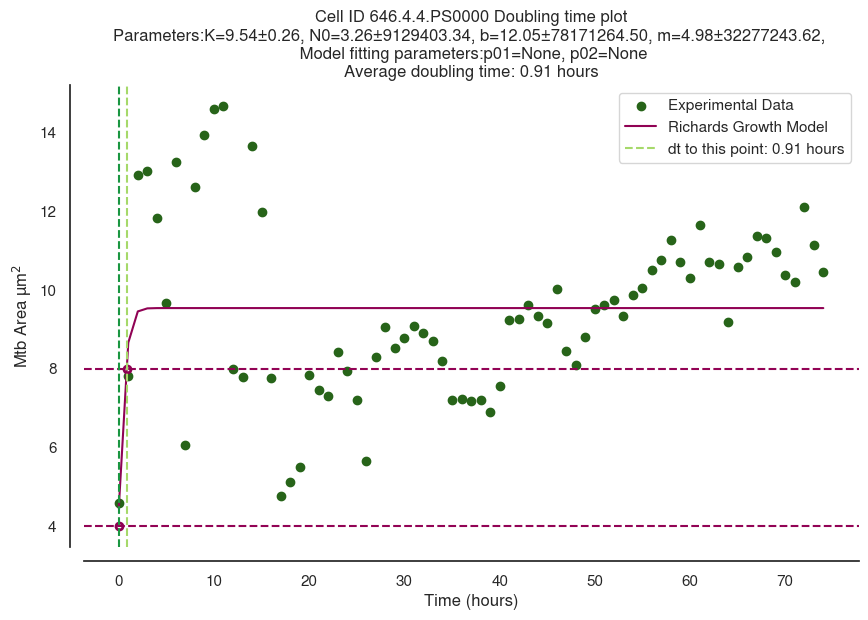

In [254]:
initial_guess = None
p01, p02 = 0.5, 3

ID = '646.4.4.PS0000'

sc_dt_df = df[df['ID'] == ID]
        
# Extract nonzero bacterial population and replace outliers using IQR interpolation  
bacterial_population = interpolate_nans(sc_dt_df[sc_dt_df['Mtb Area (µm)'] != 0]['Mtb Area (µm)'].values) # replace_outlier(sc_dt_df[sc_dt_df['Mtb Area (µm)'] != 0]['Mtb Area (µm)'].values)
time_points = sc_dt_df[sc_dt_df['Mtb Area (µm)'] != 0]['Time (hours)']

if initial_guess:
    initial_guess = [max(bacterial_population), min(bacterial_population), p01, p02] # p01 = p02 = None #[max(bacterial_population), min(bacterial_population), p01, p02]
else:
    p01, p02 = None, None
# Fit the Richards growth model to the data by supplying the max, min and 
params, covariance, info_dict, mesg, ier = curve_fit(richards_growth, time_points, bacterial_population, p0=initial_guess, full_output = True)
K, N0, b, m = params
cov_params = np.sqrt(np.diag(covariance)) #[round(i, 2) for i in np.sqrt(np.diag(covariance))]
if all(cov_params == np.inf):
    raise ValueError('No curve found. Unable to calculate parameters due to infinite covariance.')
# Create a time array for the model
time_model = np.linspace(0, len(bacterial_population)-1, len(time_points)) # np.linspace(0, len(bacterial_population)-1, 100)

# Calculate the model's bacterial population predictions
population_model = richards_growth(time_model, K, N0, b, m)

# Calculate the doubling points based on the population model
doubling_series = []
current_value = min(population_model) # used to be based on bacterial_population
while current_value <= max(population_model):
    doubling_series.append(int(current_value))
    current_value *= 2
    
# Plot the experimental data and the fitted model
plt.figure(figsize=(10, 6))
plt.scatter(time_points, bacterial_population, label='Experimental Data', color=green_colors[0])
plt.plot(time_model, population_model, label='Richards Growth Model', color=pink_colors[1])

# Plot the horizontal lines from the doubling series
for value in doubling_series:
    plt.axhline(y=value, color=pink_colors[2], linestyle='--',) 
                # label=f'Doubling Value: {value}')

# Perform linear interpolation to estimate population values at intermediate time points
interpolator = interp1d(time_model, population_model, kind='linear', fill_value='extrapolate')
interpolated_time_points = np.linspace(min(time_points), max(time_points), num=int(max(population_model))*100) # the number of points needs to be granular enough to cover every integer between min and max population values as then all intersections can be reliably found 
interpolated_population = [int(i) for i in interpolator(interpolated_time_points)]
# drop duplicate interpolated population values and corresponding time points
unique_interpolated_time_points = []
unique_interpolated_population = []
# Initialize a set to keep track of seen population values
seen_population_values = set()
# Iterate through the lists and append unique population values
for time, population in zip(interpolated_time_points, interpolated_population):
    if population not in seen_population_values:
        unique_interpolated_time_points.append(time)
        unique_interpolated_population.append(population)
        seen_population_values.add(population)

# Find and mark the intersections between the interpolated population and the doubling series
intersections = [(t, N) for t, N in zip(unique_interpolated_time_points, unique_interpolated_population) if N in doubling_series]
for t, N in intersections:
    plt.plot(t, N, 'o', markerfacecolor='none', markeredgecolor=pink_colors[0], markersize = 5, markeredgewidth = 2)

# # calculate the elapsed doubling times 
doubling_time_points = [t for (t, N) in intersections]
# calculate the elapsed doubling times taking into account negativity
doubling_times = []
for i in range(len(doubling_time_points) - 1):
    # Calculate the difference in time points
    time_diff = doubling_time_points[i + 1] - doubling_time_points[i]
    # Calculate the difference in population
    population_diff = unique_interpolated_population[i + 1] - unique_interpolated_population[i]
    # Check if the population is decreasing
    if population_diff < 0:
        # If so, make the time difference negative to indicate a decrease
        time_diff = -time_diff
    doubling_times.append(time_diff)
# Now, doubling_times may include negative values, reflecting decreases in population
average_doubling_time = np.mean([(time) for time in doubling_times])  # Use absolute values for average
# When plotting, adjust labels to reflect negative doubling times
for i, time in enumerate(doubling_time_points):
    if i > 0:
        dt = doubling_times[i - 1]
        if dt < 0:
            label = f'dt to this point: -{abs(dt):.2f} hours (decrease)'
        else:
            label = f'dt to this point: {dt:.2f} hours'
        plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label=label)
    else: 
        plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label='')

# Add labels, legend, and title
plt.xlabel('Time (hours)')
plt.ylabel('Mtb Area µm$^{2}$')
plt.legend()
cell_ID = sc_dt_df['Unique ID'].unique()
plt.title(f'Cell ID {ID} Doubling time plot\nParameters:K={K:.2f}±{cov_params[0]:.2f}, N0={N0:.2f}±{cov_params[1]:.2f}, b={b:.2f}±{cov_params[2]:.2f}, m={m:.2f}±{cov_params[3]:.2f}, \n Model fitting parameters:p01={p01}, p02={p02}\nAverage doubling time: {average_doubling_time:.2f} hours')
sns.despine(offset = 10)
# Show the plot
plt.grid(False)

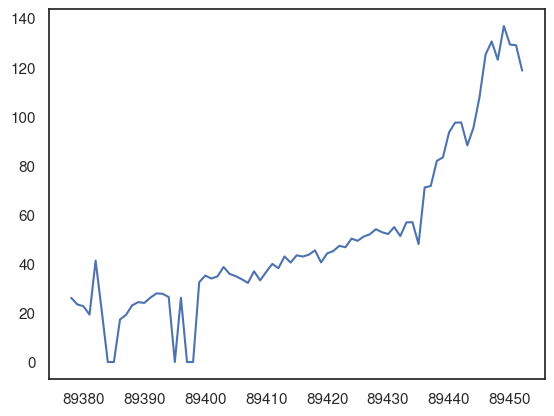

In [268]:
plt.plot(sc_dt_df['Mtb Area (µm)'])


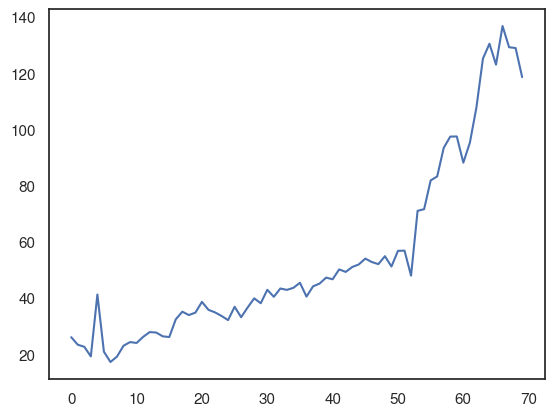

In [267]:
plt.plot(bacterial_population)

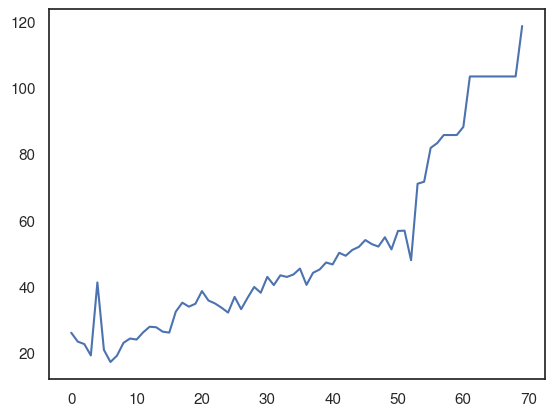

In [270]:
plt.plot(replace_outlier((bacterial_population)))

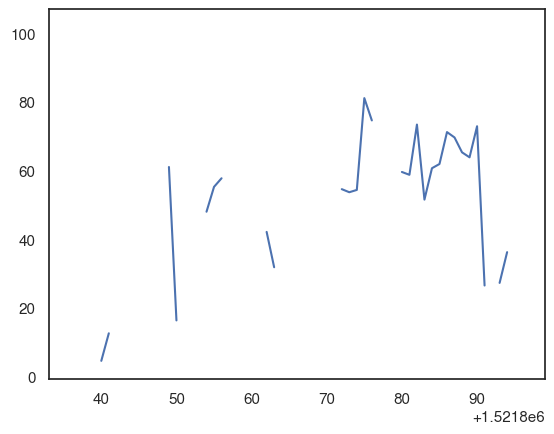

In [284]:
plt.plot(sc_dt_df[sc_dt_df['Mtb Area (µm)'] != 0]['Mtb Area (µm)'])

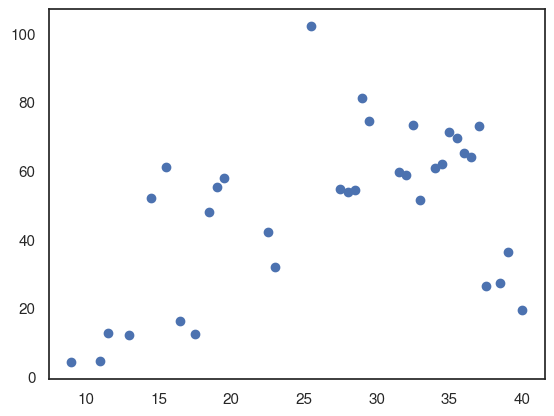

In [316]:
plt.scatter(y = sc_dt_df[sc_dt_df['Mtb Area (µm)'] != 0]['Mtb Area (µm)'], x = sc_dt_df[sc_dt_df['Mtb Area (µm)'] != 0]['Time (hours)'])

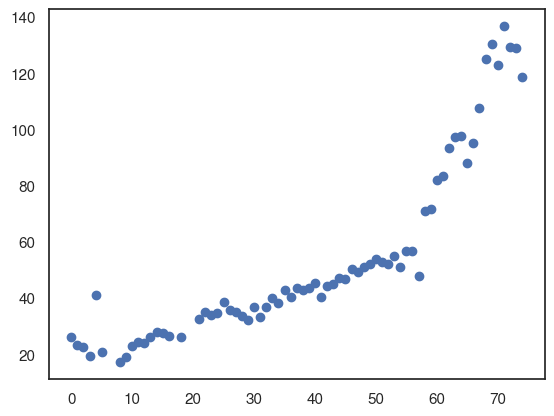

In [344]:
plt.scatter(y = bacterial_population,
            x = time_points)

In [346]:
bacterial_population.values

array([ 26.12535218,  23.44353673,  22.70603748,  19.28672278,
        41.29995794,  20.96285744,  17.29770966,  19.2196774 ,
        23.08596134,  24.38217214,  24.06929367,  26.23709449,
        27.93557761,  27.77913837,  26.43823065,  26.1700491 ,
        32.49466387,  35.19882779,  33.99201083,  34.86360086,
        38.68518787,  35.84693319,  34.9529947 ,  33.67913237,
        32.20413387,  36.94200783,  33.23216312,  36.71852321,
        39.93670175,  38.19352171,  42.97609259,  40.4954133 ,
        43.4454103 ,  42.95374413,  43.69124338,  45.47912035,
        40.56245869,  44.20525801,  45.18859034,  47.31169424,
        46.73063422,  50.23934277,  49.34540429,  51.08858433,
        52.00487128,  54.08327825,  52.85411284,  52.11661359,
        54.93251981,  51.26737203,  56.83213909,  56.92153294,
        48.00449656,  71.06810944,  71.67151791,  81.88476509,
        83.31506666,  93.48361691,  97.48399162,  97.52868855,
        88.20937986,  95.3161908 , 107.80898111, 125.24

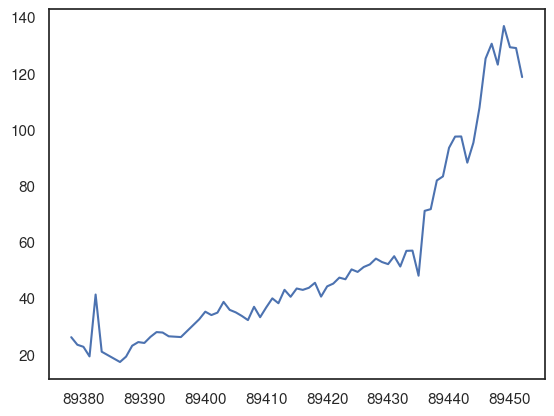

In [341]:
plt.plot(bacterial_population)

In [28]:
test

NameError: name 'test' is not defined

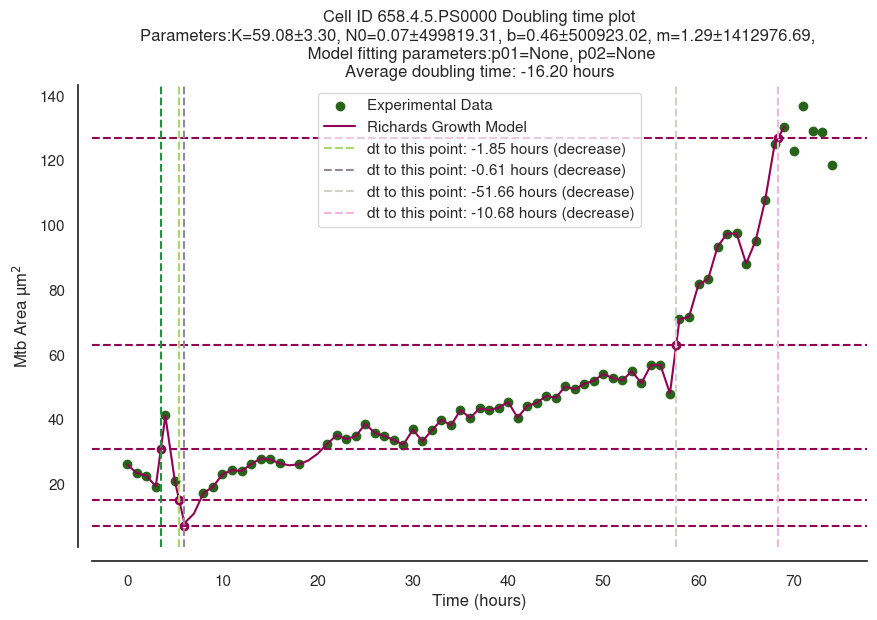

In [352]:
from scipy.interpolate import UnivariateSpline


initial_guess = None #1
p01, p02 = 1, 3

ID = '658.4.5.PS0000'

sc_dt_df = df[df['ID'] == ID]
        
# Extract nonzero bacterial population and replace outliers using IQR interpolation  
non_zero_values = sc_dt_df[sc_dt_df['Mtb Area (µm)'] != 0]['Mtb Area (µm)']
replace_nans = non_zero_values.interpolate(method='linear')
backfill_replace_nans = replace_nans.interpolate(method='backfill')
bacterial_population = backfill_replace_nans #.rolling(window=3).mean(backf)
# bacterial_population = bacterial_population.values
time_points = sc_dt_df[sc_dt_df['Mtb Area (µm)'] != 0]['Time (hours)']

if initial_guess:
    initial_guess = [max(bacterial_population), min(bacterial_population), p01, p02] # p01 = p02 = None #[max(bacterial_population), min(bacterial_population), p01, p02]
else:
    p01, p02 = None, None

spline = UnivariateSpline(time_points, bacterial_population, s=0.1)

# # Fit the Richards growth model to the data by supplying the max, min and 
# params, covariance, info_dict, mesg, ier = curve_fit(richards_growth, time_points, bacterial_population, p0=initial_guess, full_output = True)
K, N0, b, m = params
cov_params = np.sqrt(np.diag(covariance)) #[round(i, 2) for i in np.sqrt(np.diag(covariance))]
if all(cov_params == np.inf):
    raise ValueError('No curve found. Unable to calculate parameters due to infinite covariance.')
# Create a time array for the model
time_model = np.linspace(0, len(bacterial_population)-1, len(time_points)) # np.linspace(0, len(bacterial_population)-1, 100)

# Calculate the model's bacterial population predictions
population_model = spline(time_model) # richards_growth(time_model, K, N0, b, m)

# Calculate the doubling points based on the population model
doubling_series = []
current_value = min(population_model) # used to be based on bacterial_population
while current_value <= max(population_model):
    doubling_series.append(int(current_value))
    current_value *= 2
    
# Plot the experimental data and the fitted model
plt.figure(figsize=(10, 6))
plt.scatter(time_points, bacterial_population, label='Experimental Data', color=green_colors[0])
plt.plot(time_model, population_model, label='Richards Growth Model', color=pink_colors[1])

# Plot the horizontal lines from the doubling series
for value in doubling_series:
    plt.axhline(y=value, color=pink_colors[2], linestyle='--',) 
                # label=f'Doubling Value: {value}')

# Perform linear interpolation to estimate population values at intermediate time points
interpolator = interp1d(time_model, population_model, kind='linear', fill_value='extrapolate')
interpolated_time_points = np.linspace(min(time_points), max(time_points), num=int(max(population_model))*100) # the number of points needs to be granular enough to cover every integer between min and max population values as then all intersections can be reliably found 
interpolated_population = [int(i) for i in interpolator(interpolated_time_points)]
# drop duplicate interpolated population values and corresponding time points
unique_interpolated_time_points = []
unique_interpolated_population = []
# Initialize a set to keep track of seen population values
seen_population_values = set()
# Iterate through the lists and append unique population values
for time, population in zip(interpolated_time_points, interpolated_population):
    if population not in seen_population_values:
        unique_interpolated_time_points.append(time)
        unique_interpolated_population.append(population)
        seen_population_values.add(population)

# Find and mark the intersections between the interpolated population and the doubling series
intersections = [(t, N) for t, N in zip(unique_interpolated_time_points, unique_interpolated_population) if N in doubling_series]
for t, N in intersections:
    plt.plot(t, N, 'o', markerfacecolor='none', markeredgecolor=pink_colors[0], markersize = 5, markeredgewidth = 2)

# # calculate the elapsed doubling times 
doubling_time_points = [t for (t, N) in intersections]
# calculate the elapsed doubling times taking into account negativity
doubling_times = []
for i in range(len(doubling_time_points) - 1):
    # Calculate the difference in time points
    time_diff = doubling_time_points[i + 1] - doubling_time_points[i]
    # Calculate the difference in population
    population_diff = unique_interpolated_population[i + 1] - unique_interpolated_population[i]
    # Check if the population is decreasing
    if population_diff < 0:
        # If so, make the time difference negative to indicate a decrease
        time_diff = -time_diff
    doubling_times.append(time_diff)
# Now, doubling_times may include negative values, reflecting decreases in population
average_doubling_time = np.mean([(time) for time in doubling_times])  # Use absolute values for average
# When plotting, adjust labels to reflect negative doubling times
for i, time in enumerate(doubling_time_points):
    if i > 0:
        dt = doubling_times[i - 1]
        if dt < 0:
            label = f'dt to this point: -{abs(dt):.2f} hours (decrease)'
        else:
            label = f'dt to this point: {dt:.2f} hours'
        plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label=label)
    else: 
        plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label='')

# Add labels, legend, and title
plt.xlabel('Time (hours)')
plt.ylabel('Mtb Area µm$^{2}$')
plt.legend()
cell_ID = sc_dt_df['Unique ID'].unique()
# plt.title(f'Cell ID {ID} Doubling time plot\nParameters:K={K:.2f}±{cov_params[0]:.2f}, N0={N0:.2f}±{cov_params[1]:.2f}, b={b:.2f}±{cov_params[2]:.2f}, m={m:.2f}±{cov_params[3]:.2f}, \n Model fitting parameters:p01={p01}, p02={p02}\nAverage doubling time: {average_doubling_time:.2f} hours')
sns.despine(offset = 10)
# Show the plot
plt.grid(False)

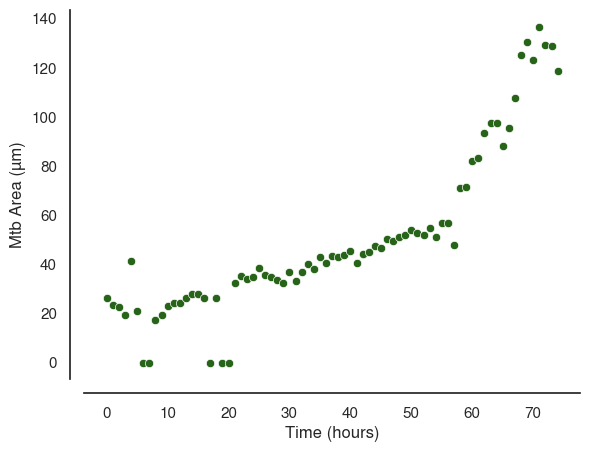

In [33]:
sns.scatterplot(y = sc_dt_df['Mtb Area (µm)'], x = sc_dt_df['Time (hours)'], color=green_colors[0])
sns.despine(offset = 10)

In [29]:
from scipy.interpolate import UnivariateSpline


initial_guess = None #1
p01, p02 = 1, 3

ID = '658.4.5.PS0000'

sc_dt_df = df[df['ID'] == ID]
        
# Extract nonzero bacterial population and replace outliers using IQR interpolation  
non_zero_values = sc_dt_df[sc_dt_df['Mtb Area (µm)'] != 0]['Mtb Area (µm)']
replace_nans = non_zero_values.interpolate(method='linear')
backfill_replace_nans = replace_nans.interpolate(method='backfill')
bacterial_population = backfill_replace_nans #.rolling(window=3).mean(backf)
# bacterial_population = bacterial_population.values
time_points = sc_dt_df[sc_dt_df['Mtb Area (µm)'] != 0]['Time (hours)']

if initial_guess:
    initial_guess = [max(bacterial_population), min(bacterial_population), p01, p02] # p01 = p02 = None #[max(bacterial_population), min(bacterial_population), p01, p02]
else:
    p01, p02 = None, None

spline = UnivariateSpline(time_points, bacterial_population, s=0.1)

# # Fit the Richards growth model to the data by supplying the max, min and 
# params, covariance, info_dict, mesg, ier = curve_fit(richards_growth, time_points, bacterial_population, p0=initial_guess, full_output = True)
K, N0, b, m = params
cov_params = np.sqrt(np.diag(covariance)) #[round(i, 2) for i in np.sqrt(np.diag(covariance))]
if all(cov_params == np.inf):
    raise ValueError('No curve found. Unable to calculate parameters due to infinite covariance.')
# Create a time array for the model
time_model = np.linspace(0, len(bacterial_population)-1, len(time_points)) # np.linspace(0, len(bacterial_population)-1, 100)

# Calculate the model's bacterial population predictions
population_model = spline(time_model) # richards_growth(time_model, K, N0, b, m)

# Calculate the doubling points based on the population model
doubling_series = []
current_value = min(population_model) # used to be based on bacterial_population
while current_value <= max(population_model):
    doubling_series.append(int(current_value))
    current_value *= 2
    
# Plot the experimental data and the fitted model
plt.figure(figsize=(10, 6))
plt.scatter(time_points, bacterial_population, label='Experimental Data', color=green_colors[0])
plt.plot(time_model, population_model, label='Richards Growth Model', color=pink_colors[1])

# Plot the horizontal lines from the doubling series
for value in doubling_series:
    plt.axhline(y=value, color=pink_colors[2], linestyle='--',) 
                # label=f'Doubling Value: {value}')

# Perform linear interpolation to estimate population values at intermediate time points
interpolator = interp1d(time_model, population_model, kind='linear', fill_value='extrapolate')
interpolated_time_points = np.linspace(min(time_points), max(time_points), num=int(max(population_model))*100) # the number of points needs to be granular enough to cover every integer between min and max population values as then all intersections can be reliably found 
interpolated_population = [int(i) for i in interpolator(interpolated_time_points)]
# drop duplicate interpolated population values and corresponding time points
unique_interpolated_time_points = []
unique_interpolated_population = []
# Initialize a set to keep track of seen population values
seen_population_values = set()
# Iterate through the lists and append unique population values
for time, population in zip(interpolated_time_points, interpolated_population):
    if population not in seen_population_values:
        unique_interpolated_time_points.append(time)
        unique_interpolated_population.append(population)
        seen_population_values.add(population)

# Find and mark the intersections between the interpolated population and the doubling series
intersections = [(t, N) for t, N in zip(unique_interpolated_time_points, unique_interpolated_population) if N in doubling_series]
for t, N in intersections:
    plt.plot(t, N, 'o', markerfacecolor='none', markeredgecolor=pink_colors[0], markersize = 5, markeredgewidth = 2)

# # calculate the elapsed doubling times 
doubling_time_points = [t for (t, N) in intersections]
# calculate the elapsed doubling times taking into account negativity
doubling_times = []
for i in range(len(doubling_time_points) - 1):
    # Calculate the difference in time points
    time_diff = doubling_time_points[i + 1] - doubling_time_points[i]
    # Calculate the difference in population
    population_diff = unique_interpolated_population[i + 1] - unique_interpolated_population[i]
    # Check if the population is decreasing
    if population_diff < 0:
        # If so, make the time difference negative to indicate a decrease
        time_diff = -time_diff
    doubling_times.append(time_diff)
# Now, doubling_times may include negative values, reflecting decreases in population
average_doubling_time = np.mean([(time) for time in doubling_times])  # Use absolute values for average
# When plotting, adjust labels to reflect negative doubling times
for i, time in enumerate(doubling_time_points):
    if i > 0:
        dt = doubling_times[i - 1]
        if dt < 0:
            label = f'dt to this point: -{abs(dt):.2f} hours (decrease)'
        else:
            label = f'dt to this point: {dt:.2f} hours'
        plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label=label)
    else: 
        plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label='')

# Add labels, legend, and title
plt.xlabel('Time (hours)')
plt.ylabel('Mtb Area µm$^{2}$')
plt.legend()
cell_ID = sc_dt_df['Unique ID'].unique()
# plt.title(f'Cell ID {ID} Doubling time plot\nParameters:K={K:.2f}±{cov_params[0]:.2f}, N0={N0:.2f}±{cov_params[1]:.2f}, b={b:.2f}±{cov_params[2]:.2f}, m={m:.2f}±{cov_params[3]:.2f}, \n Model fitting parameters:p01={p01}, p02={p02}\nAverage doubling time: {average_doubling_time:.2f} hours')
sns.despine(offset = 10)
# Show the plot
plt.grid(False)

NameError: name 'covariance' is not defined

In [401]:
time_points

array([ 0.,  1.,  2.,  3.,  4.,  5.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 18., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30.,
       31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43.,
       44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56.,
       57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
       70., 71., 72., 73., 74.])

In [400]:
exponential_growth(time_points, N0, r)

array([-4.71672521e-14, -1.28213884e-13, -3.48521473e-13, -9.47379588e-13,
       -2.57524472e-12, -7.00024095e-12, -1.40603599e-10, -3.82200209e-10,
       -1.03892788e-09, -2.82409879e-09, -7.67669645e-09, -2.08674245e-08,
       -5.67235409e-08, -1.54190571e-07, -4.19133428e-07, -3.09700042e-06,
       -6.22049167e-05, -1.69090495e-04, -4.59635621e-04, -1.24941916e-03,
       -3.39627340e-03, -9.23202829e-03, -2.50952548e-02, -6.82159752e-02,
       -1.85430246e-01, -5.04051670e-01, -1.37015450e+00, -3.72446608e+00,
       -1.01241485e+01, -2.75202889e+01, -7.48079014e+01, -2.03348959e+02,
       -5.52759782e+02, -1.50255687e+03, -4.08437305e+03, -1.11024771e+04,
       -3.01796617e+04, -8.20368263e+04, -2.22999215e+05, -6.06174714e+05,
       -1.64775371e+06, -4.47905898e+06, -1.21753447e+07, -3.30960182e+07,
       -8.99643051e+07, -2.44548336e+08, -6.64751300e+08, -1.80698138e+09,
       -4.91188467e+09, -1.33518869e+10, -3.62941915e+10, -9.86578414e+10,
       -2.68179818e+11, -

In [404]:
(bacterial_population[-1]/bacterial_population[0])

4.5414884516680925

In [431]:
cov_params  =[round(i, 3) for i in np.sqrt(np.diag(cov_exp))]

In [433]:
rounded_params, cov_params

([13.353, 0.031], [1.049, 0.001])

In [435]:
f'Params: {[(i,j) for i,j in zip(rounded_params, cov_params)]}'

'Params: [(13.353, 1.049), (0.031, 0.001)]'

In [440]:
param_strings = [f'{i}±{j}' for i, j in zip(rounded_params, cov_params)]
formatted_params = ', '.join(param_strings)
complete_string = f'Model parameters: {formatted_params}'


In [467]:
# def richards_growth(t, K, Q, B, v):
#     """Richards growth model function."""
#     return K / (1 + ((K / Q - 1) * np.exp(-B * t))**(v))
    #return K / (1 + ((K / N0 - 1) * np.exp(-b * t))**m)
def richards_growth(t, K, N0, r, m):
    """Richards growth model function."""
    # return K / (1 + ((K / Q - 1) * np.exp(-B * t))**(1/v))
    return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))

/tmp/ipykernel_69257/3929657168.py:8: RuntimeWarning: overflow encountered in exp
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/tmp/ipykernel_69257/3929657168.py:8: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))


Exponential


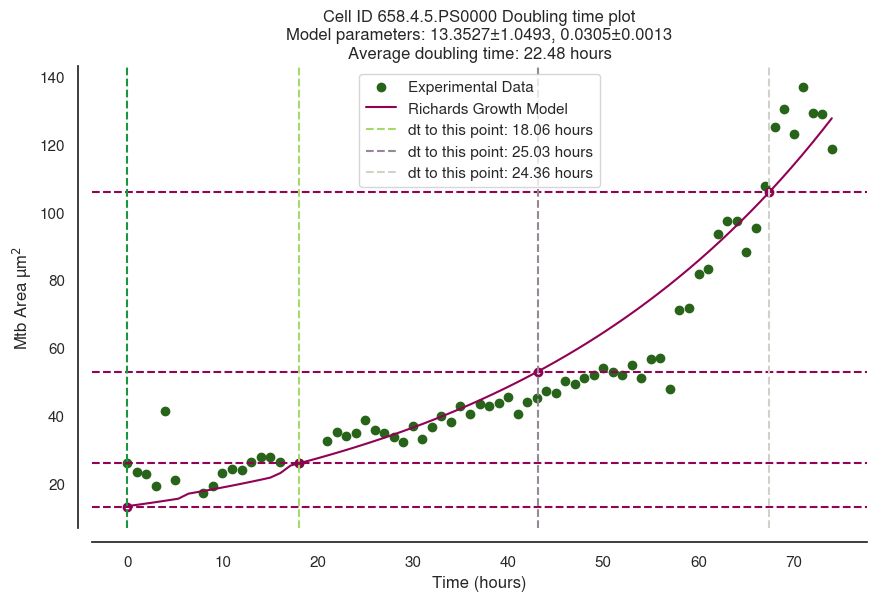

In [469]:
initial_guess = True #1 #1
r_init = 0.1 
m_init = 2

# Assuming 'df' is your DataFrame and it's already defined
ID = '658.4.5.PS0000'
sc_dt_df = df[df['ID'] == ID]

# Process your bacterial population and time_points
# (Assuming this part works correctly as intended)
non_zero_values = sc_dt_df[sc_dt_df['Mtb Area (µm)'] != 0]['Mtb Area (µm)']
bacterial_population = non_zero_values.interpolate(method='linear').interpolate(method='backfill').values
time_points = sc_dt_df[sc_dt_df['Mtb Area (µm)'] != 0]['Time (hours)'].values

# Setup initial guess based on user input
if initial_guess:
    initial_guess_richards = [max(bacterial_population), min(bacterial_population), r_init, m_init]
else:
    initial_guess_richards = None

try:
    # Try fitting the Richards growth model
    params_richards, cov_richards = curve_fit(richards_growth, time_points, bacterial_population, p0=initial_guess_richards)
    cov_params = [round(i, 4) for i in np.sqrt(np.diag(cov_richards))]
    model_used = 'Richards'
    print(model_used)
    params = params_richards
except:
    # If Richards fails, fallback to the exponential model
    r_init = 0.1 #np.log((bacterial_population[-1]/bacterial_population[0])/(time_points[-1]-time_points[0]))
    initial_guess_exp = [np.min(bacterial_population), r_init] #if initial_guess else None
    params_exp, cov_exp = curve_fit(exponential_growth, time_points, bacterial_population, p0=initial_guess_exp)
    cov_params = [round(i, 4) for i in np.sqrt(np.diag(cov_exp))] #[round(i, 2) for i in np.sqrt(np.diag(covariance))]
    model_used = 'Exponential'
    print(model_used)
    params = params_exp

# format params
rounded_params = [round(i, 4) for i in params]
param_strings = [f'{i}±{j}' for i, j in zip(rounded_params, cov_params)]
formatted_params = ', '.join(param_strings)
complete_param_string = f'Model parameters: {formatted_params}'

# Determine which model to plot
if model_used == 'Richards':
    K, N0, r, m = params
    population_model = richards_growth(time_points, K, N0, r, m)
elif model_used == 'Exponential':
    N0, r = params
    population_model = exponential_growth(time_points, N0, r)

# Create a time array for plotting the model
time_model = np.linspace(time_points.min(), time_points.max(), len(population_model))

# Calculate the doubling points based on the population model
doubling_series = []
current_value = min(population_model) # used to be based on bacterial_population
while current_value <= max(population_model):
    doubling_series.append(int(current_value))
    current_value *= 2
    
# Plot the experimental data and the fitted model
plt.figure(figsize=(10, 6))
plt.scatter(time_points, bacterial_population, label='Experimental Data', color=green_colors[0])
plt.plot(time_model, population_model, label='Richards Growth Model', color=pink_colors[1])

# Plot the horizontal lines from the doubling series
for value in doubling_series:
    plt.axhline(y=value, color=pink_colors[2], linestyle='--',) 
                # label=f'Doubling Value: {value}')

# Perform linear interpolation to estimate population values at intermediate time points
interpolator = interp1d(time_model, population_model, kind='linear', fill_value='extrapolate')
interpolated_time_points = np.linspace(min(time_points), max(time_points), num=int(max(population_model))*100) # the number of points needs to be granular enough to cover every integer between min and max population values as then all intersections can be reliably found 
interpolated_population = [int(i) for i in interpolator(interpolated_time_points)]
# drop duplicate interpolated population values and corresponding time points
unique_interpolated_time_points = []
unique_interpolated_population = []
# Initialize a set to keep track of seen population values
seen_population_values = set()
# Iterate through the lists and append unique population values
for time, population in zip(interpolated_time_points, interpolated_population):
    if population not in seen_population_values:
        unique_interpolated_time_points.append(time)
        unique_interpolated_population.append(population)
        seen_population_values.add(population)

# Find and mark the intersections between the interpolated population and the doubling series
intersections = [(t, N) for t, N in zip(unique_interpolated_time_points, unique_interpolated_population) if N in doubling_series]
for t, N in intersections:
    plt.plot(t, N, 'o', markerfacecolor='none', markeredgecolor=pink_colors[0], markersize = 5, markeredgewidth = 2)

# # calculate the elapsed doubling times 
doubling_time_points = [t for (t, N) in intersections]
# calculate the elapsed doubling times taking into account negativity
doubling_times = []
for i in range(len(doubling_time_points) - 1):
    # Calculate the difference in time points
    time_diff = doubling_time_points[i + 1] - doubling_time_points[i]
    # Calculate the difference in population
    population_diff = unique_interpolated_population[i + 1] - unique_interpolated_population[i]
    # Check if the population is decreasing
    if population_diff < 0:
        # If so, make the time difference negative to indicate a decrease
        time_diff = -time_diff
    doubling_times.append(time_diff)
# Now, doubling_times may include negative values, reflecting decreases in population
average_doubling_time = np.mean([(time) for time in doubling_times])  # Use absolute values for average
# When plotting, adjust labels to reflect negative doubling times
for i, time in enumerate(doubling_time_points):
    if i > 0:
        dt = doubling_times[i - 1]
        if dt < 0:
            label = f'dt to this point: -{abs(dt):.2f} hours (decrease)'
        else:
            label = f'dt to this point: {dt:.2f} hours'
        plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label=label)
    else: 
        plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label='')

# Add labels, legend, and title
plt.xlabel('Time (hours)')
plt.ylabel('Mtb Area µm$^{2}$')
plt.legend()
cell_ID = sc_dt_df['Unique ID'].unique()
plt.title(f'Cell ID {ID} Doubling time plot\n{complete_param_string}\nAverage doubling time: {average_doubling_time:.2f} hours')
sns.despine(offset = 10)
# Show the plot
plt.grid(False)

In [499]:
all(non_zero_values.isna())

True

/tmp/ipykernel_69257/3929657168.py:8: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/tmp/ipykernel_69257/3929657168.py:8: RuntimeWarning: overflow encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))


Falling back to exponential model due to: Infinite covariance detected, switching to exponential model
Exponential


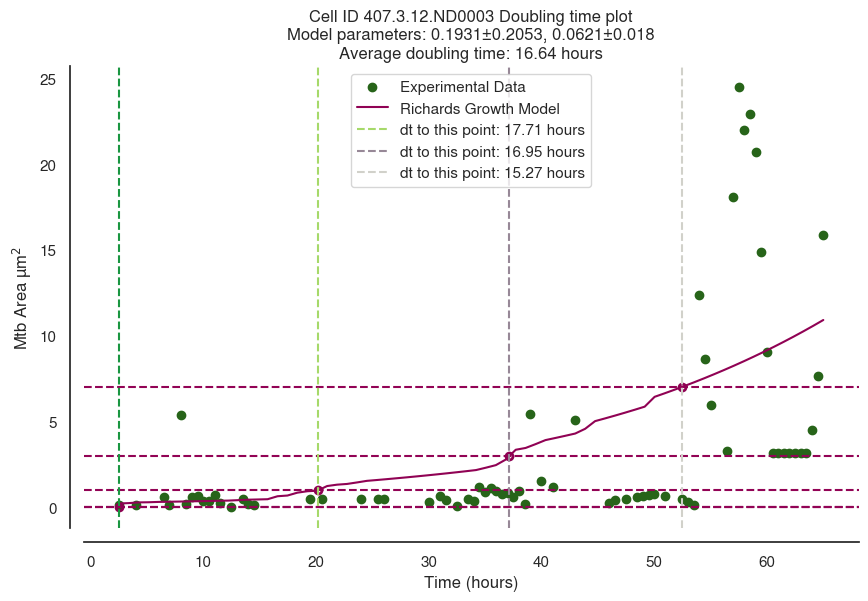

In [519]:
initial_guess = 1 #1 #1
r_init = 0.1
m_init = 2

# Assuming 'df' is your DataFrame and it's already defined
ID = '407.3.12.ND0003'
sc_dt_df = df[df['ID'] == ID]

# Process your bacterial population and time_points
# (Assuming this part works correctly as intended)
non_zero_values = sc_dt_df[sc_dt_df['Mtb Area (µm)'] != 0]['Mtb Area (µm)']
bacterial_population = non_zero_values.interpolate(method='linear').interpolate(method='backfill').values
time_points = sc_dt_df[sc_dt_df['Mtb Area (µm)'] != 0]['Time (hours)'].values

if all(non_zero_values.isna()):
    raise ValueError("Empty array of Mtb values, skipping cell")

# Setup initial guess based on user input
if initial_guess:
    initial_guess_richards = [max(bacterial_population), min(bacterial_population), r_init, m_init]
else:
    initial_guess_richards = None

try:
    # Try fitting the Richards growth model
    params_richards, cov_richards = curve_fit(richards_growth, time_points, bacterial_population, p0=initial_guess_richards)
    # Calculate standard errors and check for inf
    cov_params = [round(i, 4) for i in np.sqrt(np.diag(cov_richards))]
    if np.any(np.isinf(cov_params)):  # Check if any value in cov_params is inf
        raise ValueError("Infinite covariance detected, switching to exponential model")
    model_used = 'Richards'
    print(model_used)
    params = params_richards
except Exception as e:
    # If Richards fails or cov_params are inf, fallback to the exponential model
    print("Falling back to exponential model due to:", str(e))
    r_init = 0.1  # Example initialization, adjust as necessary
    initial_guess_exp = [np.min(bacterial_population), r_init]
    params_exp, cov_exp = curve_fit(exponential_growth, time_points, bacterial_population, p0=initial_guess_exp)
    cov_params = [round(i, 4) for i in np.sqrt(np.diag(cov_exp))]
    model_used = 'Exponential'
    print(model_used)
    params = params_exp

# format params
rounded_params = [round(i, 4) for i in params]
param_strings = [f'{i}±{j}' for i, j in zip(rounded_params, cov_params)]
formatted_params = ', '.join(param_strings)
complete_param_string = f'Model parameters: {formatted_params}'

# Determine which model to plot
if model_used == 'Richards':
    K, N0, r, m = params
    population_model = richards_growth(time_points, K, N0, r, m)
elif model_used == 'Exponential':
    N0, r = params
    population_model = exponential_growth(time_points, N0, r)

# Create a time array for plotting the model
time_model = np.linspace(time_points.min(), time_points.max(), len(population_model))

# Calculate the doubling points based on the population model
doubling_series = []
current_value = min(population_model) # used to be based on bacterial_population
while current_value <= max(population_model):
    doubling_series.append(int(current_value))
    current_value *= 2
    
# Plot the experimental data and the fitted model
plt.figure(figsize=(10, 6))
plt.scatter(time_points, bacterial_population, label='Experimental Data', color=green_colors[0])
plt.plot(time_model, population_model, label='Richards Growth Model', color=pink_colors[1])

# Plot the horizontal lines from the doubling series
for value in doubling_series:
    plt.axhline(y=value, color=pink_colors[2], linestyle='--',) 
                # label=f'Doubling Value: {value}')

# Perform linear interpolation to estimate population values at intermediate time points
interpolator = interp1d(time_model, population_model, kind='linear', fill_value='extrapolate')
interpolated_time_points = np.linspace(min(time_points), max(time_points), num=int(max(population_model))*100) # the number of points needs to be granular enough to cover every integer between min and max population values as then all intersections can be reliably found 
interpolated_population = [int(i) for i in interpolator(interpolated_time_points)]
# drop duplicate interpolated population values and corresponding time points
unique_interpolated_time_points = []
unique_interpolated_population = []
# Initialize a set to keep track of seen population values
seen_population_values = set()
# Iterate through the lists and append unique population values
for time, population in zip(interpolated_time_points, interpolated_population):
    if population not in seen_population_values:
        unique_interpolated_time_points.append(time)
        unique_interpolated_population.append(population)
        seen_population_values.add(population)

# Find and mark the intersections between the interpolated population and the doubling series
intersections = [(t, N) for t, N in zip(unique_interpolated_time_points, unique_interpolated_population) if N in doubling_series]
for t, N in intersections:
    plt.plot(t, N, 'o', markerfacecolor='none', markeredgecolor=pink_colors[0], markersize = 5, markeredgewidth = 2)

# # calculate the elapsed doubling times 
doubling_time_points = [t for (t, N) in intersections]
# calculate the elapsed doubling times taking into account negativity
doubling_times = []
for i in range(len(doubling_time_points) - 1):
    # Calculate the difference in time points
    time_diff = doubling_time_points[i + 1] - doubling_time_points[i]
    # Calculate the difference in population
    population_diff = unique_interpolated_population[i + 1] - unique_interpolated_population[i]
    # Check if the population is decreasing
    if population_diff < 0:
        # If so, make the time difference negative to indicate a decrease
        time_diff = -time_diff
    doubling_times.append(time_diff)
# Now, doubling_times may include negative values, reflecting decreases in population
average_doubling_time = np.mean([(time) for time in doubling_times])  # Use absolute values for average
# When plotting, adjust labels to reflect negative doubling times
for i, time in enumerate(doubling_time_points):
    if i > 0:
        dt = doubling_times[i - 1]
        if dt < 0:
            label = f'dt to this point: -{abs(dt):.2f} hours (decrease)'
        else:
            label = f'dt to this point: {dt:.2f} hours'
        plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label=label)
    else: 
        plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label='')

# Add labels, legend, and title
plt.xlabel('Time (hours)')
plt.ylabel('Mtb Area µm$^{2}$')
plt.legend()
cell_ID = sc_dt_df['Unique ID'].unique()
plt.title(f'Cell ID {ID} Doubling time plot\n{complete_param_string}\nAverage doubling time: {average_doubling_time:.2f} hours')
sns.despine(offset = 10)
# Show the plot
plt.grid(False)

# Old iteration

In [ ]:
os.makedirs(os.path.join(output_dir, f'dt_dev/smol/'), exist_ok = True)
os.makedirs(os.path.join(output_dir, f'dt_dev/nan/'), exist_ok = True)
unique_IDs = df['ID'].unique()
problem_IDs = []
random.shuffle(unique_IDs)

for unique_ID in tqdm(unique_IDs):
    try:
    
        sc_dt_df = df[df['ID'] == unique_ID]

        # if glob.glob(os.path.join(output_dir, f'dt_dev/*/cell_ID.{unique_ID}_doubling_time_WIP_calcs.pdf')):
        #     print(unique_ID, 'already attempted')
        #     continue 
            
        bacterial_population = sc_dt_df[sc_dt_df['Mtb Area (µm)'] != 0]['Mtb Area (µm)'] 
        bacterial_population = replace_outlier(bacterial_population.values)
        bacterial_population = interpolate(bacterial_population)
        
        time_points = sc_dt_df[sc_dt_df['Mtb Area (µm)'] != 0]['Time (hours)'] 
        
        # Fit the Richards growth model to the data
        initial_guess = [max(bacterial_population), min(bacterial_population), 0.1, 3]  # Initial parameter guesses
        params, covariance = curve_fit(richards_growth, time_points, bacterial_population, p0=initial_guess)
        
        # Extract the model parameters
        K, N0, b, m = params
        
        # Create a time array for the model
        time_model = np.linspace(0, len(bacterial_population)-1, len(time_points)) # np.linspace(0, len(bacterial_population)-1, 100)
        
        # Calculate the model's bacterial population predictions
        population_model = richards_growth(time_model, K, N0, b, m)
        
        # Calculate the doubling points 
        doubling_series = []
        current_value = min(bacterial_population)
        while current_value <= max(bacterial_population):
            doubling_series.append(int(current_value))
            current_value *= 2
            
        # Plot the experimental data and the fitted model
        plt.figure(figsize=(10, 6))
        plt.scatter(time_points, bacterial_population, label='Experimental Data', color=green_colors[0])
        plt.plot(time_model, population_model, label='Richards Growth Model', color=pink_colors[1])
        
        # Plot the horizontal lines from the doubling series
        for value in doubling_series:
            plt.axhline(y=value, color=pink_colors[2], linestyle='--',) 
                        # label=f'Doubling Value: {value}')
        
        # Perform linear interpolation to estimate population values at intermediate time points
        interpolator = interp1d(time_model, population_model, kind='linear', fill_value='extrapolate')
        interpolated_time_points = np.linspace(min(time_points), max(time_points), num=int(max(population_model))*100) # the number of points needs to be granular enough to cover every integer between min and max population values as then all intersections can be reliably found 
        interpolated_population = [int(i) for i in interpolator(interpolated_time_points)]
        
        # drop duplicate interpolated population values and corresponding time points
        unique_interpolated_time_points = []
        unique_interpolated_population = []
        
        # Initialize a set to keep track of seen population values
        seen_population_values = set()
        
        # Iterate through the lists and append unique population values
        for time, population in zip(interpolated_time_points, interpolated_population):
            if population not in seen_population_values:
                unique_interpolated_time_points.append(time)
                unique_interpolated_population.append(population)
                seen_population_values.add(population)
        
        # Find and mark the intersections between the interpolated population and the doubling series
        intersections = [(t, N) for t, N in zip(unique_interpolated_time_points, unique_interpolated_population) if N in doubling_series]
        for t, N in intersections:
            plt.plot(t, N, 'ro')
        
        # # calculate the elapsed doubling times 
        doubling_time_points = [t for (t, N) in intersections]
        
        # doubling_times = [doubling_time_points[i+1]-doubling_time_points[i] for i in range(len(doubling_time_points)-1)]
        # average_doubling_time = np.mean(doubling_times)
        # # Plot the vertical  lines from the doubling series
        # Assuming all previous steps are the same, focus on the calculation of doubling times:
        doubling_times = []
        for i in range(len(doubling_time_points) - 1):
            # Calculate the difference in time points
            time_diff = doubling_time_points[i + 1] - doubling_time_points[i]
            # Calculate the difference in population
            population_diff = unique_interpolated_population[i + 1] - unique_interpolated_population[i]
            # Check if the population is decreasing
            if population_diff < 0:
                # If so, make the time difference negative to indicate a decrease
                time_diff = -time_diff
            doubling_times.append(time_diff)
        
        # Now, doubling_times may include negative values, reflecting decreases in population
        average_doubling_time = np.mean([(time) for time in doubling_times])  # Use absolute values for average
        
        # When plotting, adjust labels to reflect negative doubling times
        for i, time in enumerate(doubling_time_points):
            if i > 0:
                dt = doubling_times[i - 1]
                if dt < 0:
                    label = f'dt to this point: -{abs(dt):.2f} hours (decrease)'
                else:
                    label = f'dt to this point: {dt:.2f} hours'
                plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label=label)
        
        
        # for i, time in enumerate(doubling_time_points):
        #     if i == 0:
        #         plt.axvline(x=time, color=expanded_piyg[i], linestyle='--',)# label=f'Doubling time point: {time:.2f} hours')
        #     else:
        #         dt = doubling_times[i-1]
        #         plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label=f'dt to this point: {dt:.2f} hours')
        
        plt.xlim((int(interpolated_time_points[0]*0.9), int(interpolated_time_points[-1]*1.1)))
        plt.ylim(min(bacterial_population)*0.9, max(bacterial_population)*1.1)

        # Add labels, legend, and title
        plt.xlabel('Time (hours)')
        plt.ylabel('Mtb Area µm$^{2}$')
        plt.legend()
        cell_ID = sc_dt_df['Unique ID'].unique()
        plt.title(f'Cell ID {cell_ID} Doubling time plot\nParameters: K={K:.2f}, N0={N0:.2f}, b={b:.2f}, m={m:.2f}\nSimple doubling time calculation: {np.log(2)/b:.2f} hours\nMore accurate doubling time: {average_doubling_time:.2f} hours')
        sns.despine(offset = 10)
        # Show the plot
        plt.grid(False)
        
        if np.isnan(average_doubling_time):
            plt.savefig(os.path.join(output_dir, f'dt_dev/nan/cell_ID.{unique_ID}_doubling_time_WIP_calcs.png'), dpi =314, bbox_inches = 'tight')
            print(f'Simple doubling time calculation: {np.log(2)/b:.2f} hours')
            print(f'More accurate doubling time: {average_doubling_time:.2f} hours')
            df.loc[df['ID'] == unique_ID, 'dt'] = average_doubling_time
            df.to_pickle(os.path.join(output_dir, 'dt_df.pkl'))
            continue
        if doubling_series[0] < 1.966664663680242: # consider this to be less than one bac
            plt.savefig(os.path.join(output_dir, f'dt_dev/smol/cell_ID.{unique_ID}_doubling_time_WIP_calcs.png'), dpi =314, bbox_inches = 'tight')
            print(f'Simple doubling time calculation: {np.log(2)/b:.2f} hours')
            print(f'More accurate doubling time: {average_doubling_time:.2f} hours')
            df.loc[df['ID'] == unique_ID, 'dt'] = average_doubling_time
            df.to_pickle(os.path.join(output_dir, 'dt_df.pkl'))
            continue
        else:
            plt.savefig(os.path.join(output_dir, f'dt_dev/cell_ID.{unique_ID}_doubling_time_WIP_calcs.png'), dpi =314, bbox_inches = 'tight')
            print(f'Simple doubling time calculation: {np.log(2)/b:.2f} hours')
            print(f'More accurate doubling time: {average_doubling_time:.2f} hours')
            df.loc[df['ID'] == unique_ID, 'dt'] = average_doubling_time
            df.to_pickle(os.path.join(output_dir, 'dt_df.pkl'))
            continue
        # plt.show()
        
    except Exception as e: 
        print(unique_ID, e)
        problem_IDs.append(unique_ID)
        df.loc[df['Unique ID'] == unique_ID, 'dt'] = np.nan
        df.to_pickle(os.path.join(output_dir, 'dt_df.pkl'))

# New iteration

# Testing growth phsae

Error fitting growth model: The number of func parameters=4 must not exceed the number of data points=2
Error fitting growth model: The number of func parameters=4 must not exceed the number of data points=3


/tmp/ipykernel_69257/403057252.py:4: RuntimeWarning: overflow encountered in exp
  return N0 * np.exp(-decay_rate * time)


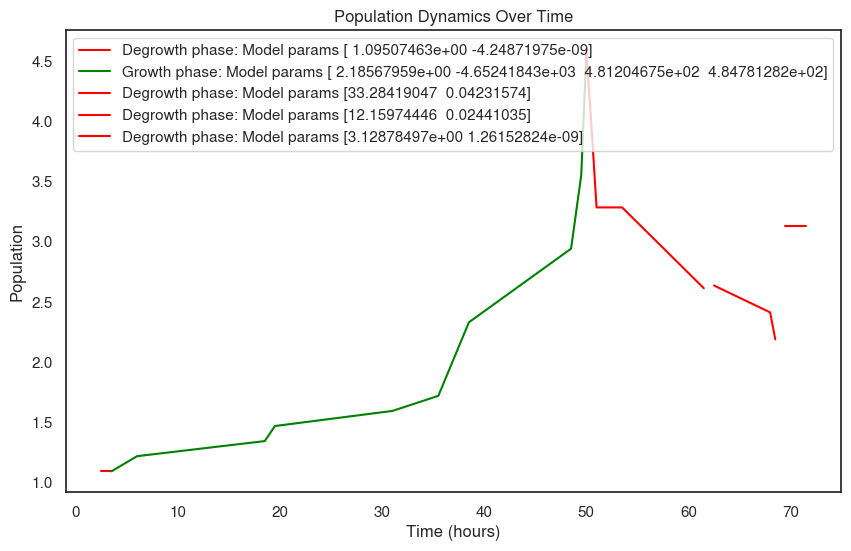

In [714]:
# Assuming richards_growth and exponential_growth are predefined somewhere in your code
# If degrowth is exponential decay, here's a simple decay model:
def exponential_decay(time, N0, decay_rate):
    return N0 * np.exp(-decay_rate * time)

# Function to detect growth phases
def detect_growth_phases(population_values, time_points):
    phases = []
    current_phase = 'growth' if population_values[1] > population_values[0] else 'degrowth'
    start_index = 0

    for i in range(1, len(population_values)):
        current_direction = 'growth' if population_values[i] > population_values[i - 1] else 'degrowth'
        if current_direction != current_phase:
            phases.append((current_phase, start_index, i - 1, time_points[start_index], time_points[i - 1]))
            start_index = i - 1
            current_phase = current_direction

    phases.append((current_phase, start_index, len(population_values) - 1, time_points[start_index], time_points[-1]))
    return phases

# Function to fit models based on detected phases
def fit_models_by_phase(phases, time_points, population_values, initial_guess_richards, initial_guess_decay):
    models = []
    for phase, start_idx, end_idx, _, _ in phases:
        phase_time = time_points[start_idx:end_idx+1]
        phase_population = population_values[start_idx:end_idx+1]
        if phase == 'growth':
            try:
                params, _ = curve_fit(richards_growth, phase_time, phase_population, p0=initial_guess_richards)
                models.append((phase, params, phase_time, phase_population))
            except Exception as e:
                print(f"Error fitting growth model: {e}")
        else:
            try:
                params, _ = curve_fit(exponential_decay, phase_time, phase_population, p0=initial_guess_decay)
                models.append((phase, params, phase_time, phase_population))
            except Exception as e:
                print(f"Error fitting decay model: {e}")
    return models

# Function to plot growth phases
def plot_growth_phases(models):
    plt.figure(figsize=(10, 6))
    for model_info in models:
        phase, params, phase_time, phase_population = model_info
        label = f'{phase.capitalize()} phase: Model params {params}'
        if phase == 'growth':
            plt.plot(phase_time, phase_population, label=label, color='green')
        else:
            plt.plot(phase_time, phase_population, label=label, color='red')
    plt.xlabel('Time (hours)')
    plt.ylabel('Population')
    plt.title('Population Dynamics Over Time')
    plt.legend()
    plt.show()

# Assuming you have some data ready for processing:
# You'll need to populate these with your actual data handling logic.
time_points = sc_dt_df[sc_dt_df['Mtb Area (µm)'] != 0]['Time (hours)'].values #np.array([...])  # Your actual time points
population_values = bacterial_population #np.array([...])  # Your actual population values
initial_guess_richards = [max(population_values), min(population_values), 0.1, 0.1]  # Example initial guess for growth model
initial_guess_decay = [max(population_values), 0.1]  # Example initial guess for decay model

# Detecting phases and fitting models
phases = detect_growth_phases(population_values, time_points)
models = fit_models_by_phase(phases, time_points, population_values, initial_guess_richards, initial_guess_decay)

# Visualizing the results
plot_growth_phases(models)

In [727]:
def detect_growth_transition_times(population_values, time_points, window=10, largest_only=True):
    transitions = []
    current_phase = 'growth' if population_values[1] > population_values[0] else 'degrowth'
    phase_start_time = time_points[0]  # Initialize phase start time
    longest_phase = (0, 0, 0)  # (duration, start_time, end_time)

    for i in range(1, len(population_values)):
        current_direction = 'growth' if population_values[i] > population_values[i - 1] else 'degrowth'
        if current_direction != current_phase:
            # Check if the duration of the current phase meets the window requirement
            phase_duration = time_points[i] - phase_start_time
            if phase_duration >= window:
                transitions.append((phase_start_time, time_points[i]))
                # Update longest phase if necessary
                if current_phase == 'growth' and phase_duration > longest_phase[0]:
                    longest_phase = (phase_duration, phase_start_time, time_points[i])
            # Update the phase start time and current phase
            phase_start_time = time_points[i]
            current_phase = current_direction

    # Check the last phase in the data
    phase_duration = time_points[-1] - phase_start_time
    if phase_duration >= window:
        transitions.append((phase_start_time, time_points[-1]))
        if current_phase == 'growth' and phase_duration > longest_phase[0]:
            longest_phase = (phase_duration, phase_start_time, time_points[-1])

    # If largest_only is True, return only the longest growth phase
    if largest_only:
        return [(longest_phase[1], longest_phase[2])] if longest_phase[0] > 0 else []
    
    return transitions


In [750]:
p01, p02 = 0.5, 2
initial_guess_richards = [max(bacterial_population), min(bacterial_population), p01, p02]

In [751]:
params, cov_richards = curve_fit(richards_growth, time_points, bacterial_population, p0=initial_guess_richards)

/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [752]:
K, N0, r, m = params
population_model = richards_growth(time_points, K, N0, r, m)

<Axes: >

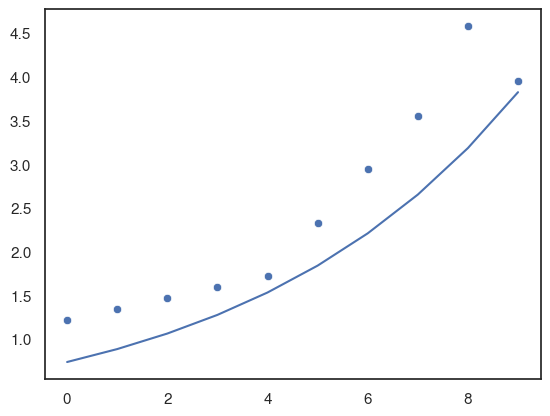

In [805]:
@timeout(10)
def fit_exponential():
    return curve_fit(exponential_growth, time_points, bacterial_population, p0=[2, 0.0001])
params_exp, cov_exp = fit_exponential()
cov_params = [round(i, 4) for i in np.sqrt(np.diag(cov_exp))]
N0, r = params
time_model = np.linspace(time_points.min(), time_points.max(), len(population_model))

population_model = exponential_growth(time_model, N0, r)
sns.lineplot(population_model)
sns.scatterplot(bacterial_population)

In [796]:
params_exp, cov_exp 

(array([0.59049224, 0.03699339]),
 array([[ 3.01526584e-02, -1.08655016e-03],
        [-1.08655016e-03,  4.05491993e-05]]))

In [798]:
params_exp, cov_exp 

(array([0.59049224, 0.03699339]),
 array([[ 3.01526584e-02, -1.08655016e-03],
        [-1.08655016e-03,  4.05491993e-05]]))

In [777]:
x_data

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [807]:
len(time_points)

10

### first step ought to be interpolating nan values 

In [1025]:
unique_ID = '10.3.4.ND0002'
sc_dt_df = df[df['ID']==unique_ID]

In [1023]:
interpolated_data.values

array([22.66134056, 26.95224528, 24.73974753,  7.3079471 ,  4.76022242,
        3.5981024 , 14.81703036, 13.07385032,  4.49204088,  4.70435127,
        4.91666166,  5.12897205,  5.34128244,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [1024]:
replace_outlier(interpolated_data.values)


array([26.95224528, 13.47612264, 13.47612264, 13.47612264, 13.47612264,
       13.47612264, 13.47612264, 13.47612264, 13.47612264, 13.47612264,
       13.47612264, 13.47612264, 13.47612264,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

<Axes: ylabel='Mtb Area (µm)'>

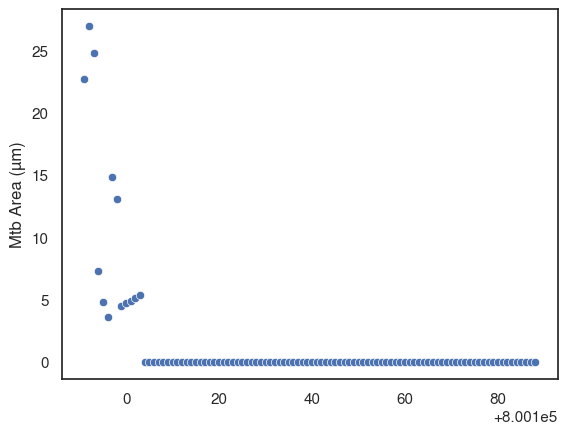

In [1027]:
# get raw data
raw_data = sc_dt_df['Mtb Area (µm)']
### remove nan values from dummy track points, backfill for init nan values
interpolated_data = raw_data.interpolate(method='linear').interpolate(method='backfill')
# Calculate the differences
diffs = interpolated_data.diff()
# Find indices where the absolute value of a difference equals the absolute value of the next difference
indices = [i for i in range(len(diffs) - 1) if diffs.iloc[i] == -(diffs.iloc[i + 1]) and diffs.iloc[i] >0]
for i in indices:
    ### remove single instance outliers
    interpolated_data.iloc[i] = interpolated_data.iloc[i+1]
bacterial_population = interpolated_data #replace_outlier(interpolated_data.values)
sns.scatterplot(bacterial_population)

No growth window detected 240.4.9.PS0000
Infinite covariance detected, switching to exponential model
Exponential


/tmp/ipykernel_69257/638910734.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


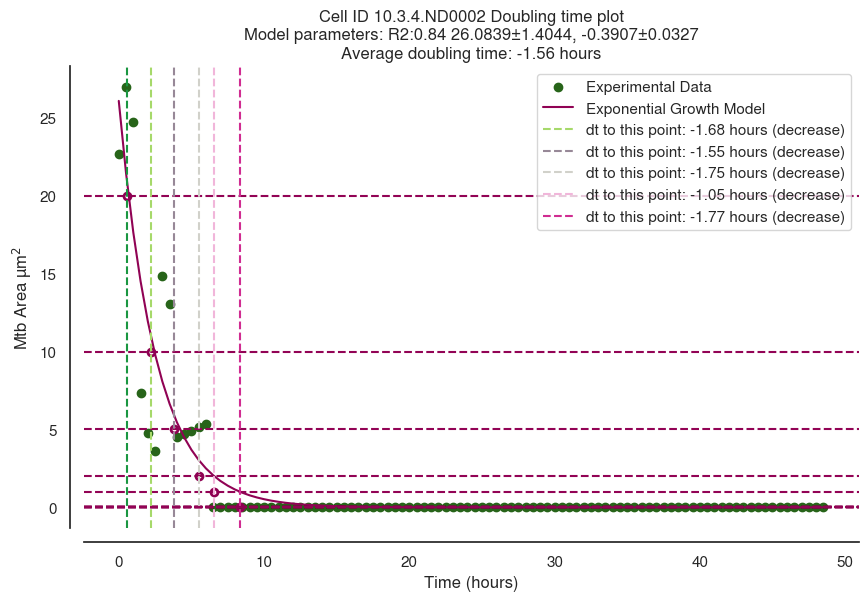

In [1029]:
unique_ID = '10.3.4.ND0002'
# unique_ID = '1931.5.10.ND0002'
sc_dt_df = df[df['ID'] == unique_ID]

# get raw data
raw_data = sc_dt_df['Mtb Area (µm)']
### remove nan values from dummy track points, backfill for init nan values
interpolated_data = raw_data.interpolate(method='linear').interpolate(method='backfill')
# Calculate the differences
diffs = interpolated_data.diff()
# Find indices where the absolute value of a difference equals the absolute value of the next difference
indices = [i for i in range(len(diffs) - 1) if diffs.iloc[i] == -(diffs.iloc[i + 1]) and diffs.iloc[i] >0]
for i in indices:
    ### remove single instance outliers
    interpolated_data.iloc[i] = interpolated_data.iloc[i+1]
bacterial_population = interpolated_data.values
time_points = sc_dt_df['Time (hours)'].values

# # Process your bacterial population and time_points
# non_zero_values = sc_dt_df['Mtb Area (µm)'] #sc_dt_df[sc_dt_df['Mtb Area (µm)'] != 0]['Mtb Area (µm)']
# bacterial_population = non_zero_values.interpolate(method='linear').interpolate(method='backfill').values
# time_points = sc_dt_df['Time (hours)'].values #sc_dt_df[sc_dt_df['Mtb Area (µm)'] != 0]['Time (hours)'].values
# bacterial_population = replace_outlier(bacterial_population)

# check for the period of growth
largest_growth_window = detect_growth_transition_times(bacterial_population, time_points)
# Crop the arrays to the largest growth window
if largest_growth_window:
    start_time, end_time = largest_growth_window[0]
    start_idx = np.where(time_points == start_time)[0][0]
    end_idx = np.where(time_points == end_time)[0][0]

    time_points = time_points[start_idx:end_idx+1]
    bacterial_population = bacterial_population[start_idx:end_idx+1]
else:
    print(f'No growth window detected {ID}')
    no_growth_window.append(ID)
    
# Scale the x and y coordinates
scaled_x_coords = sc_dt_df.x * track_scale_factor
scaled_y_coords = sc_dt_df.y * track_scale_factor
# check boundary case
# if (any(scaled_x_coords < boundary_buffer) or 
#     any(scaled_y_coords < boundary_buffer) or
#     any(scaled_x_coords > image_width-boundary_buffer) or 
#     any(scaled_y_coords > image_height-boundary_buffer)):
#     print(f'{unique_ID} appears to be a boundary case, skipping')
#     boundary_case.append(unique_ID)
#     continue

if all(non_zero_values.isna()) or non_zero_values.sum() == 0:
    empty_mtb_IDs.append(unique_ID)
    raise ValueError(f"{unique_ID} Empty array of Mtb values, skipping cell")

if not check_consecutive_doubles(bacterial_population):
    non_doubling_IDs.append(unique_ID)
    raise ValueError(f"{unique_ID} Non doubling cell")

if not check_persistent_growth(bacterial_population):
    non_persistent_growth.append(unique_ID)
    raise ValueError(f"{unique_ID} Non persistent growth cell")


# Setup initial guess based on user input
if initial_guess:
    initial_guess_richards = [max(bacterial_population), min(bacterial_population), r_init, m_init]
else:
    initial_guess_richards = None


try:
    @timeout(10)  # Adjusted the comment for correct timeout
    def fit_richards():
        return curve_fit(richards_growth, time_points, bacterial_population, p0=initial_guess_richards)

    try:
        params_richards, cov_richards = fit_richards()
        cov_params = [round(i, 4) for i in np.sqrt(np.diag(cov_richards))]
        if np.any(np.isinf(cov_params)):
            raise ValueError("Infinite covariance detected, switching to exponential model")
        model_used = 'Richards'
        print(model_used)
        params = params_richards
    except (TimeoutError, RuntimeError) as error:  # Catching RuntimeError as well
        print(f"Error fitting Richards model: {error}")
        raise ValueError("Fitting Richards growth model failed or timed out")

except ValueError as richards_error:
    print(richards_error)
    try:
        @timeout(10)
        def fit_exponential():
            return curve_fit(exponential_growth, time_points, bacterial_population, p0=initial_guess_exp)
        params_exp, cov_exp = fit_exponential()
        cov_params = [round(i, 4) for i in np.sqrt(np.diag(cov_exp))]
        model_used = 'Exponential'
        print(model_used)
        params = params_exp
    except TimeoutError:
        print("Fitting exponential growth model timed out")
        # Consider further handling if exponential fitting also fails

# Create a time array for plotting the model
time_model = np.linspace(time_points.min(), time_points.max(), len(time_points))

# format params
rounded_params = [round(i, 4) for i in params]
param_strings = [f'{i}±{j}' for i, j in zip(rounded_params, cov_params)]
formatted_params = ', '.join(param_strings)

# Determine which model to plot
if model_used == 'Richards':
    K, N0, r, m = params
    population_model = richards_growth(time_model, K, N0, r, m)
elif model_used == 'Exponential':
    N0, r = params
    population_model = exponential_growth(time_model, N0, r)

# calculate r squared
r2 = compute_r_squared(bacterial_population, population_model)
complete_param_string = f'Model parameters: R2:{r2:.2f} {formatted_params}'



# Calculate the doubling points based on the population model
doubling_series = []
current_value = min(population_model)  # Starts from the minimum model value
max_value = max(population_model)  # Defines the maximum threshold

# Ensure the loop terminates by checking for growth or limiting iterations
iteration_limit = 2*len(time_model)  # Prevents infinite loop, adjust as necessary
iterations = 0

while current_value <= max_value and iterations < iteration_limit:
    doubling_series.append(int(current_value))
    next_value = current_value * 2
    
    # Break the loop if there's no increase to prevent infinite loop
    if next_value <= current_value or next_value > max_value:
        break
    
    current_value = next_value
    iterations += 1  # Increment iteration count
    
# Plot the experimental data and the fitted model
plt.figure(figsize=(10, 6))
plt.scatter(time_points, bacterial_population, label='Experimental Data', color=green_colors[0])
plt.plot(time_model, population_model, label=f'{model_used} Growth Model', color=pink_colors[1])

# Plot the horizontal lines from the doubling series
for value in doubling_series:
    plt.axhline(y=value, color=pink_colors[2], linestyle='--',) 
                # label=f'Doubling Value: {value}')

# Perform linear interpolation to estimate population values at intermediate time points
interpolator = interp1d(time_model, population_model, kind='linear', fill_value='extrapolate')
interpolated_time_points = np.linspace(min(time_points), max(time_points), num=int(max(population_model))*100) # the number of points needs to be granular enough to cover every integer between min and max population values as then all intersections can be reliably found 
interpolated_population = [int(i) for i in interpolator(interpolated_time_points)]
# drop duplicate interpolated population values and corresponding time points
unique_interpolated_time_points = []
unique_interpolated_population = []
# Initialize a set to keep track of seen population values
seen_population_values = set()
# Iterate through the lists and append unique population values
for time, population in zip(interpolated_time_points, interpolated_population):
    if population not in seen_population_values:
        unique_interpolated_time_points.append(time)
        unique_interpolated_population.append(population)
        seen_population_values.add(population)

# Find and mark the intersections between the interpolated population and the doubling series
intersections = [(t, N) for t, N in zip(unique_interpolated_time_points, unique_interpolated_population) if N in doubling_series]
for t, N in intersections:
    plt.plot(t, N, 'o', markerfacecolor='none', markeredgecolor=pink_colors[0], markersize = 5, markeredgewidth = 2)

# # calculate the elapsed doubling times 
doubling_time_points = [t for (t, N) in intersections]
# calculate the elapsed doubling times taking into account negativity
doubling_times = []
for i in range(len(doubling_time_points) - 1):
    # Calculate the difference in time points
    time_diff = doubling_time_points[i + 1] - doubling_time_points[i]
    # Calculate the difference in population
    population_diff = unique_interpolated_population[i + 1] - unique_interpolated_population[i]
    # Check if the population is decreasing
    if population_diff < 0:
        # If so, make the time difference negative to indicate a decrease
        time_diff = -time_diff
    doubling_times.append(time_diff)
# Now, doubling_times may include negative values, reflecting decreases in population
average_doubling_time = np.mean([(time) for time in doubling_times])  # Use absolute values for average

if np.isnan(average_doubling_time):
    nan_dts.append(unique_ID)
    raise ValueError(f"{unique_ID} Nan doubling time")

# When plotting, adjust labels to reflect negative doubling times
for i, time in enumerate(doubling_time_points):
    if i > 0:
        dt = doubling_times[i - 1]
        if dt < 0:
            label = f'dt to this point: -{abs(dt):.2f} hours (decrease)'
        else:
            label = f'dt to this point: {dt:.2f} hours'
        plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label=label)
    else: 
        plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label='')

# Add labels, legend, and title
plt.xlabel('Time (hours)')
plt.ylabel('Mtb Area µm$^{2}$')
plt.legend()
cell_ID = sc_dt_df['Unique ID'].unique()
plt.title(f'Cell ID {unique_ID} Doubling time plot\n{complete_param_string}\nAverage doubling time: {average_doubling_time:.2f} hours')
sns.despine(offset = 10)
# Show the plot
plt.grid(False)

In [1030]:
largest_growth_window

[]

/tmp/ipykernel_69257/1048233435.py:50: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential


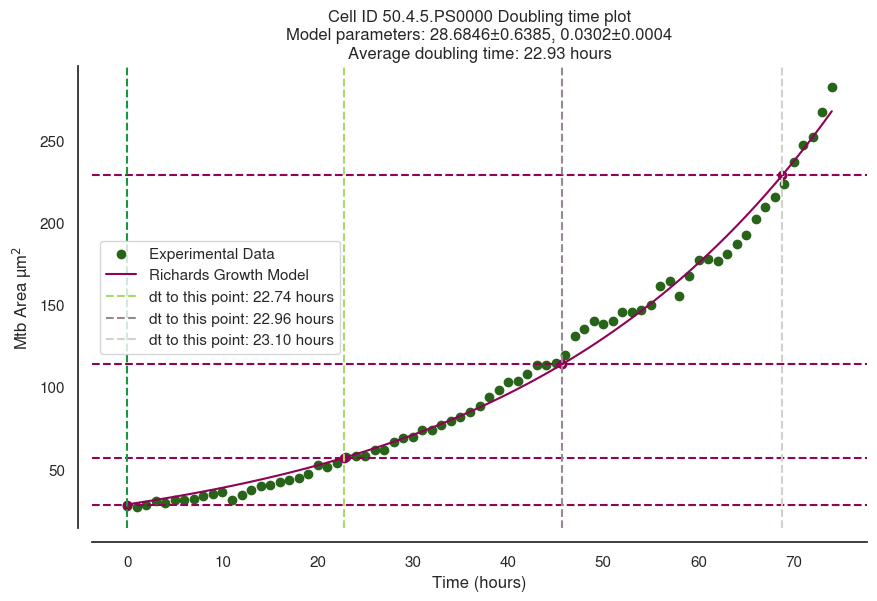

In [628]:
unique_ID = '50.4.5.PS0000'
# unique_ID = '1931.5.10.ND0002'
sc_dt_df = df[df['ID'] == unique_ID]

# Process your bacterial population and time_points
# (Assuming this part works correctly as intended)
non_zero_values = sc_dt_df['Mtb Area (µm)'] #sc_dt_df[sc_dt_df['Mtb Area (µm)'] != 0]['Mtb Area (µm)']
bacterial_population = non_zero_values.interpolate(method='linear').interpolate(method='backfill').values
time_points = sc_dt_df['Time (hours)'].values #[sc_dt_df['Mtb Area (µm)'] != 0]['Time (hours)'].values


if all(non_zero_values.isna()) or non_zero_values.sum() == 0:
    empty_mtb_IDs.append(unique_ID)
    raise ValueError(f"{unique_ID} Empty array of Mtb values, skipping cell")

if not check_consecutive_doubles(bacterial_population):
    non_doubling_IDs.append(unique_ID)
    raise ValueError(f"{unique_ID} Non doubling cell")

if not check_persistent_growth(bacterial_population):
    non_persistent_growth.append(unique_ID)
    raise ValueError(f"{unique_ID} Non persistent growth cell")

# Setup initial guess based on user input
if initial_guess:
    initial_guess_richards = [max(bacterial_population), min(bacterial_population), r_init, m_init]
else:
    initial_guess_richards = None

try:
    @timeout(10)  # Timeout set to 60 seconds for Richards growth model (adjust as needed)
    def fit_richards():
        return curve_fit(richards_growth, time_points, bacterial_population, p0=initial_guess_richards)

    try:
        params_richards, cov_richards = fit_richards()
        cov_params = [round(i, 4) for i in np.sqrt(np.diag(cov_richards))]
        if np.any(np.isinf(cov_params)):
            raise ValueError("Infinite covariance detected, switching to exponential model")
        model_used = 'Richards'
        print(model_used)
        params = params_richards
    except TimeoutError:
        raise ValueError("Fitting Richards growth model timed out")

except ValueError as richards_error:
    print(richards_error)
    try:
        @timeout(10)
        def fit_exponential():
            return curve_fit(exponential_growth, time_points, bacterial_population, p0=initial_guess_exp)
        params_exp, cov_exp = fit_exponential()
        cov_params = [round(i, 4) for i in np.sqrt(np.diag(cov_exp))]
        model_used = 'Exponential'
        print(model_used)
        params = params_exp
    except TimeoutError:
        raise ValueError("Fitting exponential growth model timed out")

# format params
r2 = compute_r_squared(bacterial_population, population_model)
rounded_params = [round(i, 4) for i in params]
param_strings = [f'{i}±{j}' for i, j in zip(rounded_params, cov_params)]
formatted_params = ', '.join(param_strings)
complete_param_string = f'Model parameters: R2:{r2} {formatted_params}'

# Determine which model to plot
if model_used == 'Richards':
    K, N0, r, m = params
    population_model = richards_growth(time_points, K, N0, r, m)
elif model_used == 'Exponential':
    N0, r = params
    population_model = exponential_growth(time_points, N0, r)

# Create a time array for plotting the model
time_model = np.linspace(time_points.min(), time_points.max(), len(population_model))

# Calculate the doubling points based on the population model
doubling_series = []
current_value = min(population_model) # used to be based on bacterial_population
while current_value <= max(population_model):
    doubling_series.append(int(current_value))
    current_value *= 2
    
# Plot the experimental data and the fitted model
plt.figure(figsize=(10, 6))
plt.scatter(time_points, bacterial_population, label='Experimental Data', color=green_colors[0])
plt.plot(time_model, population_model, label='Richards Growth Model', color=pink_colors[1])

# Plot the horizontal lines from the doubling series
for value in doubling_series:
    plt.axhline(y=value, color=pink_colors[2], linestyle='--',) 
                # label=f'Doubling Value: {value}')

# Perform linear interpolation to estimate population values at intermediate time points
interpolator = interp1d(time_model, population_model, kind='linear', fill_value='extrapolate')
interpolated_time_points = np.linspace(min(time_points), max(time_points), num=int(max(population_model))*100) # the number of points needs to be granular enough to cover every integer between min and max population values as then all intersections can be reliably found 
interpolated_population = [int(i) for i in interpolator(interpolated_time_points)]
# drop duplicate interpolated population values and corresponding time points
unique_interpolated_time_points = []
unique_interpolated_population = []
# Initialize a set to keep track of seen population values
seen_population_values = set()
# Iterate through the lists and append unique population values
for time, population in zip(interpolated_time_points, interpolated_population):
    if population not in seen_population_values:
        unique_interpolated_time_points.append(time)
        unique_interpolated_population.append(population)
        seen_population_values.add(population)

# Find and mark the intersections between the interpolated population and the doubling series
intersections = [(t, N) for t, N in zip(unique_interpolated_time_points, unique_interpolated_population) if N in doubling_series]
for t, N in intersections:
    plt.plot(t, N, 'o', markerfacecolor='none', markeredgecolor=pink_colors[0], markersize = 5, markeredgewidth = 2)

# # calculate the elapsed doubling times 
doubling_time_points = [t for (t, N) in intersections]
# calculate the elapsed doubling times taking into account negativity
doubling_times = []
for i in range(len(doubling_time_points) - 1):
    # Calculate the difference in time points
    time_diff = doubling_time_points[i + 1] - doubling_time_points[i]
    # Calculate the difference in population
    population_diff = unique_interpolated_population[i + 1] - unique_interpolated_population[i]
    # Check if the population is decreasing
    if population_diff < 0:
        # If so, make the time difference negative to indicate a decrease
        time_diff = -time_diff
    doubling_times.append(time_diff)
# Now, doubling_times may include negative values, reflecting decreases in population
average_doubling_time = np.mean([(time) for time in doubling_times])  # Use absolute values for average

if np.isnan(average_doubling_time):
    nan_dts.append(unique_ID)
    raise ValueError(f"{unique_ID} Nan doubling time")

# When plotting, adjust labels to reflect negative doubling times
for i, time in enumerate(doubling_time_points):
    if i > 0:
        dt = doubling_times[i - 1]
        if dt < 0:
            label = f'dt to this point: -{abs(dt):.2f} hours (decrease)'
        else:
            label = f'dt to this point: {dt:.2f} hours'
        plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label=label)
    else: 
        plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label='')

# Add labels, legend, and title
plt.xlabel('Time (hours)')
plt.ylabel('Mtb Area µm$^{2}$')
plt.legend()
cell_ID = sc_dt_df['Unique ID'].unique()
plt.title(f'Cell ID {unique_ID} Doubling time plot\n{complete_param_string}\nAverage doubling time: {average_doubling_time:.2f} hours')
sns.despine(offset = 10)
# Show the plot
plt.grid(False)

### THE FOLLOWING EXAMPLE IS WHY WE NEED NON ZERO MEASURES

/tmp/ipykernel_69257/1048233435.py:50: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential


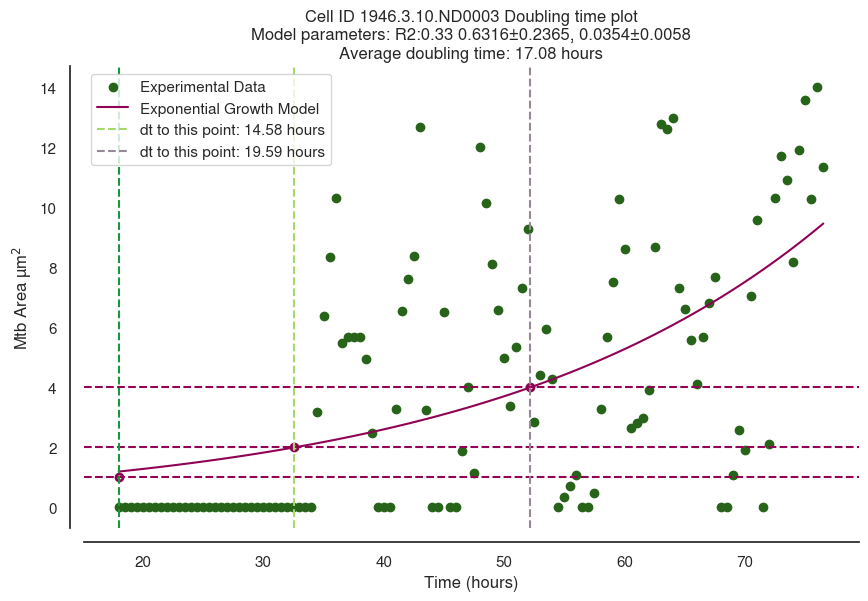

In [682]:
unique_ID = '1946.3.10.ND0003'
# unique_ID = '50.4.5.PS0000'
# unique_ID = '666.6.5.PS0000'
# unique_ID = '1931.5.10.ND0002'
sc_dt_df = df[df['ID'] == unique_ID]

# Process your bacterial population and time_points
# (Assuming this part works correctly as intended)
# non_zero_values = sc_dt_df['Mtb Area (µm)'] #sc_dt_df[sc_dt_df['Mtb Area (µm)'] != 0]['Mtb Area (µm)']
bacterial_population = sc_dt_df['Mtb Area (µm)'].interpolate(method='linear').interpolate(method='backfill').values
time_points = sc_dt_df['Time (hours)'].values #[sc_dt_df['Mtb Area (µm)'] != 0]['Time (hours)'].values

# Scale the x and y coordinates
scaled_x_coords = sc_dt_df.x * track_scale_factor
scaled_y_coords = sc_dt_df.y * track_scale_factor
# check boundary case
if (any(scaled_x_coords < boundary_buffer) or 
    any(scaled_y_coords < boundary_buffer) or
    any(scaled_x_coords > image_width-boundary_buffer) or 
    any(scaled_y_coords > image_height-boundary_buffer)):
    print(f'{unique_ID} appears to be a boundary case, skipping')
    boundary_case.append(unique_ID)
    # continue

if all(sc_dt_df['Mtb Area (µm)'].isna()) or sc_dt_df['Mtb Area (µm)'].sum() == 0:
    empty_mtb_IDs.append(unique_ID)
    raise ValueError(f"{unique_ID} Empty array of Mtb values, skipping cell")

if not check_consecutive_doubles(bacterial_population):
    non_doubling_IDs.append(unique_ID)
    raise ValueError(f"{unique_ID} Non doubling cell")

if not check_persistent_growth(bacterial_population):
    non_persistent_growth.append(unique_ID)
    raise ValueError(f"{unique_ID} Non persistent growth cell")

# Setup initial guess based on user input
if initial_guess:
    initial_guess_richards = [max(bacterial_population), min(bacterial_population), r_init, m_init]
else:
    initial_guess_richards = None


try:
    @timeout(10)  # Adjusted the comment for correct timeout
    def fit_richards():
        return curve_fit(richards_growth, time_points, bacterial_population, p0=initial_guess_richards)

    try:
        params_richards, cov_richards = fit_richards()
        cov_params = [round(i, 4) for i in np.sqrt(np.diag(cov_richards))]
        if np.any(np.isinf(cov_params)):
            raise ValueError("Infinite covariance detected, switching to exponential model")
        model_used = 'Richards'
        print(model_used)
        params = params_richards
    except (TimeoutError, RuntimeError) as error:  # Catching RuntimeError as well
        print(f"Error fitting Richards model: {error}")
        raise ValueError("Fitting Richards growth model failed or timed out")

except ValueError as richards_error:
    print(richards_error)
    try:
        @timeout(10)
        def fit_exponential():
            return curve_fit(exponential_growth, time_points, bacterial_population, p0=initial_guess_exp)
        params_exp, cov_exp = fit_exponential()
        cov_params = [round(i, 4) for i in np.sqrt(np.diag(cov_exp))]
        model_used = 'Exponential'
        print(model_used)
        params = params_exp
    except TimeoutError:
        print("Fitting exponential growth model timed out")
        # Consider further handling if exponential fitting also fails



# format params
rounded_params = [round(i, 4) for i in params]
param_strings = [f'{i}±{j}' for i, j in zip(rounded_params, cov_params)]
formatted_params = ', '.join(param_strings)

# Determine which model to plot
if model_used == 'Richards':
    K, N0, r, m = params
    population_model = richards_growth(time_points, K, N0, r, m)
elif model_used == 'Exponential':
    N0, r = params
    population_model = exponential_growth(time_points, N0, r)

# calculate r squared
r2 = compute_r_squared(bacterial_population, population_model)
complete_param_string = f'Model parameters: R2:{r2:.2f} {formatted_params}'

# Create a time array for plotting the model
time_model = np.linspace(time_points.min(), time_points.max(), len(population_model))

# Calculate the doubling points based on the population model
doubling_series = []
current_value = min(population_model)  # Starts from the minimum model value
max_value = max(population_model)  # Defines the maximum threshold

# Ensure the loop terminates by checking for growth or limiting iterations
iteration_limit = 2*len(time_model)  # Prevents infinite loop, adjust as necessary
iterations = 0

while current_value <= max_value and iterations < iteration_limit:
    doubling_series.append(int(current_value))
    next_value = current_value * 2
    
    # Break the loop if there's no increase to prevent infinite loop
    if next_value <= current_value or next_value > max_value:
        break
    
    current_value = next_value
    iterations += 1  # Increment iteration count
    
# Plot the experimental data and the fitted model
plt.figure(figsize=(10, 6))
plt.scatter(time_points, bacterial_population, label='Experimental Data', color=green_colors[0])
plt.plot(time_model, population_model, label=f'{model_used} Growth Model', color=pink_colors[1])

# Plot the horizontal lines from the doubling series
for value in doubling_series:
    plt.axhline(y=value, color=pink_colors[2], linestyle='--',) 
                # label=f'Doubling Value: {value}')

# Perform linear interpolation to estimate population values at intermediate time points
interpolator = interp1d(time_model, population_model, kind='linear', fill_value='extrapolate')
interpolated_time_points = np.linspace(min(time_points), max(time_points), num=int(max(population_model))*100) # the number of points needs to be granular enough to cover every integer between min and max population values as then all intersections can be reliably found 
interpolated_population = [int(i) for i in interpolator(interpolated_time_points)]
# drop duplicate interpolated population values and corresponding time points
unique_interpolated_time_points = []
unique_interpolated_population = []
# Initialize a set to keep track of seen population values
seen_population_values = set()
# Iterate through the lists and append unique population values
for time, population in zip(interpolated_time_points, interpolated_population):
    if population not in seen_population_values:
        unique_interpolated_time_points.append(time)
        unique_interpolated_population.append(population)
        seen_population_values.add(population)

# Find and mark the intersections between the interpolated population and the doubling series
intersections = [(t, N) for t, N in zip(unique_interpolated_time_points, unique_interpolated_population) if N in doubling_series]
for t, N in intersections:
    plt.plot(t, N, 'o', markerfacecolor='none', markeredgecolor=pink_colors[0], markersize = 5, markeredgewidth = 2)

# # calculate the elapsed doubling times 
doubling_time_points = [t for (t, N) in intersections]
# calculate the elapsed doubling times taking into account negativity
doubling_times = []
for i in range(len(doubling_time_points) - 1):
    # Calculate the difference in time points
    time_diff = doubling_time_points[i + 1] - doubling_time_points[i]
    # Calculate the difference in population
    population_diff = unique_interpolated_population[i + 1] - unique_interpolated_population[i]
    # Check if the population is decreasing
    if population_diff < 0:
        # If so, make the time difference negative to indicate a decrease
        time_diff = -time_diff
    doubling_times.append(time_diff)
# Now, doubling_times may include negative values, reflecting decreases in population
average_doubling_time = np.mean([(time) for time in doubling_times])  # Use absolute values for average

if np.isnan(average_doubling_time):
    nan_dts.append(unique_ID)
    raise ValueError(f"{unique_ID} Nan doubling time")

# When plotting, adjust labels to reflect negative doubling times
for i, time in enumerate(doubling_time_points):
    if i > 0:
        dt = doubling_times[i - 1]
        if dt < 0:
            label = f'dt to this point: -{abs(dt):.2f} hours (decrease)'
        else:
            label = f'dt to this point: {dt:.2f} hours'
        plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label=label)
    else: 
        plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label='')

# Add labels, legend, and title
plt.xlabel('Time (hours)')
plt.ylabel('Mtb Area µm$^{2}$')
plt.legend()
cell_ID = sc_dt_df['Unique ID'].unique()
plt.title(f'Cell ID {unique_ID} Doubling time plot\n{complete_param_string}\nAverage doubling time: {average_doubling_time:.2f} hours')
sns.despine(offset = 10)
# Show the plot
plt.grid(False)

In [1098]:
help(check_persistent_growth)

Help on function check_persistent_growth in module __main__:

check_persistent_growth(arr, window=5)



In [1109]:
raw_data[0:30]

896885     0.000000
896886     0.000000
896887     0.000000
896888     0.000000
896889     0.000000
896890     0.000000
896891     0.000000
896892     0.000000
896893     0.000000
896894     0.000000
896895     0.000000
896896     0.000000
896897     0.000000
896898     0.000000
896899     0.000000
896900     0.000000
896901     0.000000
896902     0.000000
896903     0.000000
896904    26.840503
896905     0.000000
896906     0.000000
896907     0.000000
896908     0.000000
896909     0.000000
896910     0.000000
896911     0.000000
896912     0.000000
896913     0.000000
896914     0.000000
Name: Mtb Area (µm), dtype: float64

In [1110]:
first_non_zero_index

896904

<Axes: ylabel='Mtb Area (µm)'>

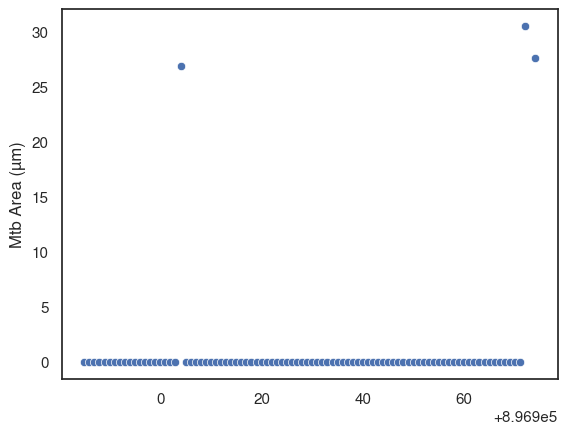

In [1107]:
sns.scatterplot(raw_data)

In [1115]:
unique_ID = '113.4.9.ND0002'
# unique_ID = '50.4.5.PS0000'
# unique_ID = '666.6.5.PS0000'
# unique_ID = '1931.5.10.ND0002'
sc_dt_df = df[df['ID'] == unique_ID]

if all(sc_dt_df['Mtb Area (µm)'].isna()) or sc_dt_df['Mtb Area (µm)'].sum() == 0:
    empty_mtb_IDs.append(unique_ID)
    raise ValueError(f"{unique_ID} Empty array of Mtb values, skipping cell")

# get raw data
raw_data = sc_dt_df['Mtb Area (µm)']

# Remove nan values from dummy track points, backfill for initial nan values
interpolated_data = raw_data.interpolate(method='linear').interpolate(method='backfill')

# Calculate the differences
diffs = interpolated_data.diff()

# Find indices where the absolute value of a difference equals the absolute value of the next difference
indices = [i for i in range(len(diffs) - 1) if diffs.iloc[i] == -(diffs.iloc[i + 1]) and diffs.iloc[i] > 0]
for i in indices:
    # remove single instance outliers
    interpolated_data.iloc[i] = interpolated_data.iloc[i + 1]

# Clip leading zeros, find the index of the first non-zero value
first_non_zero_index = interpolated_data.ne(0).idxmax()

# Find the index of the last non-zero value
last_non_zero_index = interpolated_data.ne(0)[::-1].idxmax()

# Slice the series from the first to the last non-zero value
clipped_data = interpolated_data.loc[first_non_zero_index:last_non_zero_index]

# Set final x and y coordinates to fit curve to
bacterial_population = clipped_data.values
time_points = sc_dt_df['Time (hours)'].loc[first_non_zero_index:last_non_zero_index].values

if not check_consecutive_doubles(bacterial_population):
    non_doubling_IDs.append(unique_ID)
    raise ValueError(f"{unique_ID} Non doubling cell")

if not check_persistent_growth(bacterial_population):
    non_persistent_growth.append(unique_ID)
    raise ValueError(f"{unique_ID} Non persistent growth cell")


# Scale the x and y coordinates
scaled_x_coords = sc_dt_df.x * track_scale_factor
scaled_y_coords = sc_dt_df.y * track_scale_factor
# check boundary case
if (any(scaled_x_coords < boundary_buffer) or 
    any(scaled_y_coords < boundary_buffer) or
    any(scaled_x_coords > image_width-boundary_buffer) or 
    any(scaled_y_coords > image_height-boundary_buffer)):
    print(f'{unique_ID} appears to be a boundary case, skipping')
    boundary_case.append(unique_ID)
    # continue

# Setup initial guess based on user input
if initial_guess:
    initial_guess_richards = [max(bacterial_population), min(bacterial_population), r_init, m_init]
else:
    initial_guess_richards = None


try:
    @timeout(10)  # Adjusted the comment for correct timeout
    def fit_richards():
        return curve_fit(richards_growth, time_points, bacterial_population, p0=initial_guess_richards)

    try:
        params_richards, cov_richards = fit_richards()
        cov_params = [round(i, 4) for i in np.sqrt(np.diag(cov_richards))]
        if np.any(np.isinf(cov_params)):
            raise ValueError("Infinite covariance detected, switching to exponential model")
        model_used = 'Richards'
        print(model_used)
        params = params_richards
    except (TimeoutError, RuntimeError) as error:  # Catching RuntimeError as well
        print(f"Error fitting Richards model: {error}")
        raise ValueError("Fitting Richards growth model failed or timed out")

except ValueError as richards_error:
    print(richards_error)
    try:
        @timeout(10)
        def fit_exponential():
            return curve_fit(exponential_growth, time_points, bacterial_population, p0=initial_guess_exp)
        params_exp, cov_exp = fit_exponential()
        cov_params = [round(i, 4) for i in np.sqrt(np.diag(cov_exp))]
        model_used = 'Exponential'
        print(model_used)
        params = params_exp
    except TimeoutError:
        print("Fitting exponential growth model timed out")
        # Consider further handling if exponential fitting also fails



# format params
rounded_params = [round(i, 4) for i in params]
param_strings = [f'{i}±{j}' for i, j in zip(rounded_params, cov_params)]
formatted_params = ', '.join(param_strings)

# Determine which model to plot
if model_used == 'Richards':
    K, N0, r, m = params
    population_model = richards_growth(time_points, K, N0, r, m)
elif model_used == 'Exponential':
    N0, r = params
    population_model = exponential_growth(time_points, N0, r)

# calculate r squared
r2 = compute_r_squared(bacterial_population, population_model)
complete_param_string = f'Model parameters: R2:{r2:.2f} {formatted_params}'

# Create a time array for plotting the model
time_model = np.linspace(time_points.min(), time_points.max(), len(population_model))

# Calculate the doubling points based on the population model
doubling_series = []
current_value = min(population_model)  # Starts from the minimum model value
max_value = max(population_model)  # Defines the maximum threshold

# Ensure the loop terminates by checking for growth or limiting iterations
iteration_limit = 2*len(time_model)  # Prevents infinite loop, adjust as necessary
iterations = 0

while current_value <= max_value and iterations < iteration_limit:
    doubling_series.append(int(current_value))
    next_value = current_value * 2
    
    # Break the loop if there's no increase to prevent infinite loop
    if next_value <= current_value or next_value > max_value:
        break
    
    current_value = next_value
    iterations += 1  # Increment iteration count
    
# Plot the experimental data and the fitted model
plt.figure(figsize=(10, 6))
plt.scatter(sc_dt_df['Time (hours)'].values, raw_data, label='Raw Experimental Data', color=green_colors[-1])
plt.scatter(time_points, bacterial_population, label='Cleaned Data', color=green_colors[0])
plt.plot(time_model, population_model, label=f'{model_used} Growth Model', color=pink_colors[1])

# Plot the horizontal lines from the doubling series
for value in doubling_series:
    plt.axhline(y=value, color=pink_colors[2], linestyle='--',) 
                # label=f'Doubling Value: {value}')

# Perform linear interpolation to estimate population values at intermediate time points
interpolator = interp1d(time_model, population_model, kind='linear', fill_value='extrapolate')
interpolated_time_points = np.linspace(min(time_points), max(time_points), num=int(max(population_model))*100) # the number of points needs to be granular enough to cover every integer between min and max population values as then all intersections can be reliably found 
interpolated_population = [int(i) for i in interpolator(interpolated_time_points)]
# drop duplicate interpolated population values and corresponding time points
unique_interpolated_time_points = []
unique_interpolated_population = []
# Initialize a set to keep track of seen population values
seen_population_values = set()
# Iterate through the lists and append unique population values
for time, population in zip(interpolated_time_points, interpolated_population):
    if population not in seen_population_values:
        unique_interpolated_time_points.append(time)
        unique_interpolated_population.append(population)
        seen_population_values.add(population)

# Find and mark the intersections between the interpolated population and the doubling series
intersections = [(t, N) for t, N in zip(unique_interpolated_time_points, unique_interpolated_population) if N in doubling_series]
for t, N in intersections:
    plt.plot(t, N, 'o', markerfacecolor='none', markeredgecolor=pink_colors[0], markersize = 5, markeredgewidth = 2)

# # calculate the elapsed doubling times 
doubling_time_points = [t for (t, N) in intersections]
# calculate the elapsed doubling times taking into account negativity
doubling_times = []
for i in range(len(doubling_time_points) - 1):
    # Calculate the difference in time points
    time_diff = doubling_time_points[i + 1] - doubling_time_points[i]
    # Calculate the difference in population
    population_diff = unique_interpolated_population[i + 1] - unique_interpolated_population[i]
    # Check if the population is decreasing
    if population_diff < 0:
        # If so, make the time difference negative to indicate a decrease
        time_diff = -time_diff
    doubling_times.append(time_diff)
# Now, doubling_times may include negative values, reflecting decreases in population
average_doubling_time = np.mean([(time) for time in doubling_times])  # Use absolute values for average

if np.isnan(average_doubling_time):
    nan_dts.append(unique_ID)
    raise ValueError(f"{unique_ID} Nan doubling time")

# When plotting, adjust labels to reflect negative doubling times
for i, time in enumerate(doubling_time_points):
    if i > 0:
        dt = doubling_times[i - 1]
        if dt < 0:
            label = f'dt to this point: -{abs(dt):.2f} hours (decrease)'
        else:
            label = f'dt to this point: {dt:.2f} hours'
        plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label=label)
    else: 
        plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label='')

# Add labels, legend, and title
plt.xlabel('Time (hours)')
plt.ylabel('Mtb Area µm$^{2}$')
plt.legend()
cell_ID = sc_dt_df['Unique ID'].unique()
plt.title(f'Cell ID {unique_ID} Doubling time plot\n{complete_param_string}\nAverage doubling time: {average_doubling_time:.2f} hours')
sns.despine(offset = 10)
# Show the plot
plt.grid(False)

ValueError: 113.4.9.ND0002 Non doubling cell

# Testing individual cases

In [51]:
df[(df['Experiment ID'] == 'ND0002') ]['Time (hours)'].max()

74.5

<Axes: ylabel='Count'>

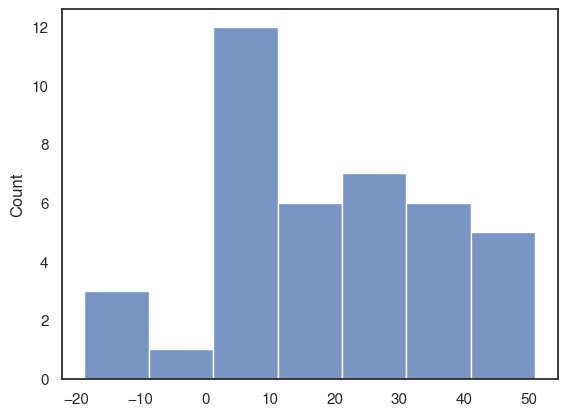

In [65]:
sns.histplot(df[(df['Experiment ID'] == 'ND0002') 

& (df['Time (hours)'] == 74.5)
]['dt'].unique())

In [74]:
df[(df['Experiment ID'] == 'ND0002') 

& (df['Time (hours)'] == 74.5)
][['Mtb Area (µm)', 'ID', 'Acquisition ID', 'Compound', 'Concentration', 'Strain']].to_csv('test.csv')

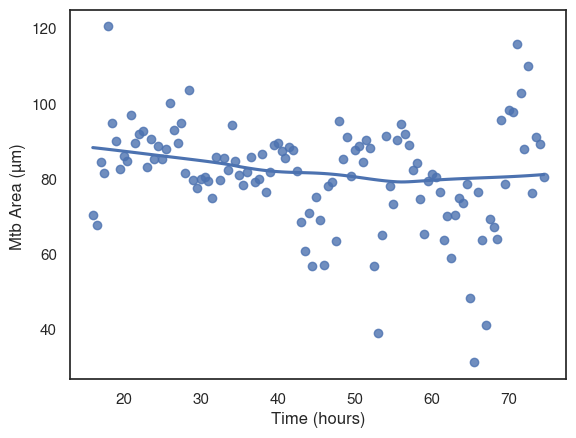

In [59]:
subset_df = df[df['ID'] =='1269.3.5.ND0002'] 

# get raw data
raw_data = subset_df['Mtb Area (µm)']

# Remove nan values from dummy track points, backfill for initial nan values
interpolated_data = raw_data.interpolate(method='linear').interpolate(method='backfill')

# Calculate the differences
diffs = interpolated_data.diff()

# Find indices where the absolute value of a difference equals the absolute value of the next difference
indices = [i for i in range(len(diffs) - 1) if diffs.iloc[i] == -(diffs.iloc[i + 1]) and diffs.iloc[i] > 0]
for i in indices:
    # remove single instance outliers
    interpolated_data.iloc[i] = interpolated_data.iloc[i + 1]

# Clip leading zeros, find the index of the first non-zero value
first_non_zero_index = interpolated_data.ne(0).idxmax()

# Find the index of the last non-zero value
last_non_zero_index = interpolated_data.ne(0)[::-1].idxmax()

# Slice the series from the first to the last non-zero value
clipped_data = interpolated_data.loc[first_non_zero_index:last_non_zero_index]

subset_df['Mtb Area (µm) '] = clipped_data

G = sns.regplot(data=subset_df, x="Time (hours)", y="Mtb Area (µm) ", lowess=True)


In [61]:
df[df['Experiment ID'] == 'ND0002']

Time (hours)  Mtb Area (µm)  dMtb Area (µm)  Mphi Area (µm)  \
773628           0.0       0.000000        0.000000     1797.933775   
773629           0.5       0.000000        0.000000     1361.311871   
773630           1.0       0.000000        0.000000     1263.626743   
773631           1.5       0.000000        0.000000     1331.096750   
773632           2.0       0.000000        0.000000      194.118742   
...              ...            ...             ...             ...   
989737          72.0      16.135590        3.575754     1000.116027   
989738          72.5            NaN        3.575754             NaN   
989739          73.0       3.084088        3.575754      959.866447   
989740          73.5       3.061739        3.575754      809.461297   
989741          74.0       3.575754        3.575754      814.668488   

        dMphi Area (µm)  Infection Status  Initial Infection Status  \
773628     -1446.504209               0.0                       0.0   
773629     -1446.504209               0.0                       0.0   
773630     -1446.504209               0.0                       0.0   
773631     -1446.504209               0.0                       0.0   
773632     -1446.504209               0.0                       0.0   
...                 ...               ...                       ...   
989737      -375.632951               1.0                       0.0   
989738      -375.632951               NaN                       0.0   
989739      -375.632951               1.0                       0.0   
989740      -375.632951               1.0                       0.0   
989741      -375.632951               1.0                       0.0   

        Final Infection Status           x          y  ...  Strain  Compound  \
773628                     0.0  450.501556  23.303928  ...     UNI      CTRL   
773629                     0.0  437.898071  13.279221  ...     UNI      CTRL   
773630                     0.0  452.786804  13.684735  ...     UNI      CTRL   
773631                     0.0  451.771729  13.176547  ...     UNI      CTRL   
773632                     0.0  450.972290  13.831188  ...     UNI      CTRL   
...                        ...         ...        ...  ...     ...       ...   
989737                     1.0  212.893417  36.177246  ...     RD1       BDQ   
989738                     1.0  212.893417  36.177246  ...     RD1       BDQ   
989739                     1.0  210.406326  31.687908  ...     RD1       BDQ   
989740                     1.0  207.946808  39.211632  ...     RD1       BDQ   
989741                     1.0  202.132538  46.543751  ...     RD1       BDQ   

        Concentration  Cell ID  Acquisition ID  Experiment ID  Unique ID  \
773628            EC0       93          (3, 1)         ND0002     93.3.1   
773629            EC0       93          (3, 1)         ND0002     93.3.1   
773630            EC0       93          (3, 1)         ND0002     93.3.1   
773631            EC0       93          (3, 1)         ND0002     93.3.1   
773632            EC0       93          (3, 1)         ND0002     93.3.1   
...               ...      ...             ...            ...        ...   
989737           EC99     1076         (6, 12)         ND0002  1076.6.12   
989738           EC99     1076         (6, 12)         ND0002  1076.6.12   
989739           EC99     1076         (6, 12)         ND0002  1076.6.12   
989740           EC99     1076         (6, 12)         ND0002  1076.6.12   
989741           EC99     1076         (6, 12)         ND0002  1076.6.12   

                      ID    dt   dts  
773628     93.3.1.ND0002  None  None  
773629     93.3.1.ND0002  None  None  
773630     93.3.1.ND0002  None  None  
773631     93.3.1.ND0002  None  None  
773632     93.3.1.ND0002  None  None  
...                  ...   ...   ...  
989737  1076.6.12.ND0002  None  None  
989738  1076.6.12.ND0002  None  None  
989739  1076.6.12.ND0002  None  None  
989740  1076.6.12.ND0002  None  None  

In [ ]:
G.

In [ ]:
subset_df

In [53]:
initial_guess = False

unique_ID = '1269.3.5.ND0002'#'10.3.4.ND0002'

# extract a single cell dataframe 
sc_dt_df = df[df['ID'] == unique_ID]

# perform initial check for zero values
if all(sc_dt_df['Mtb Area (µm)'].isna()) or sc_dt_df['Mtb Area (µm)'].sum() == 0:
    empty_mtb_IDs.append(unique_ID)
    raise ValueError(f"{unique_ID} Empty array of Mtb values, skipping cell")

# get raw data
raw_data = sc_dt_df['Mtb Area (µm)']

# Remove nan values from dummy track points, backfill for initial nan values
interpolated_data = raw_data.interpolate(method='linear').interpolate(method='backfill')

# Calculate the differences
diffs = interpolated_data.diff()

# Find indices where the absolute value of a difference equals the absolute value of the next difference
indices = [i for i in range(len(diffs) - 1) if diffs.iloc[i] == -(diffs.iloc[i + 1]) and diffs.iloc[i] > 0]
for i in indices:
    # remove single instance outliers
    interpolated_data.iloc[i] = interpolated_data.iloc[i + 1]

# Clip leading zeros, find the index of the first non-zero value
first_non_zero_index = interpolated_data.ne(0).idxmax()

# Find the index of the last non-zero value
last_non_zero_index = interpolated_data.ne(0)[::-1].idxmax()

# Slice the series from the first to the last non-zero value
clipped_data = interpolated_data.loc[first_non_zero_index:last_non_zero_index]

# Set final x and y coordinates to fit curve to
bacterial_population = clipped_data.values
time_points = sc_dt_df['Time (hours)'].loc[first_non_zero_index:last_non_zero_index].values

if not check_consecutive_doubles(bacterial_population):
    non_doubling_IDs.append(unique_ID)
    raise ValueError(f"{unique_ID} Non doubling cell")

if not check_persistent_growth(bacterial_population):
    non_persistent_growth.append(unique_ID)
    raise ValueError(f"{unique_ID} Non persistent growth cell")


# Scale the x and y coordinates
scaled_x_coords = sc_dt_df.x * track_scale_factor
scaled_y_coords = sc_dt_df.y * track_scale_factor
# check boundary case
if (any(scaled_x_coords < boundary_buffer) or 
    any(scaled_y_coords < boundary_buffer) or
    any(scaled_x_coords > image_width-boundary_buffer) or 
    any(scaled_y_coords > image_height-boundary_buffer)):
    print(f'{unique_ID} appears to be a boundary case, skipping')
    boundary_case.append(unique_ID)
    # continue

# Setup initial guess based on user input
if initial_guess:
    r_init = 0.1
    m_init = 2
    initial_guess_richards = [max(bacterial_population), min(bacterial_population), r_init, m_init]
    # Example initialization, adjust as necessary
    initial_guess_exp = [np.min(bacterial_population), r_init]
else:
    initial_guess_richards = None
    initial_guess_exp = None

try:
    @timeout(10)  # Adjusted the comment for correct timeout
    def fit_richards():
        return curve_fit(richards_growth, time_points, bacterial_population, p0=initial_guess_richards)

    try:
        params_richards, cov_richards = fit_richards()
        cov_params = [round(i, 4) for i in np.sqrt(np.diag(cov_richards))]
        if np.any(np.isinf(cov_params)):
            raise ValueError("Infinite covariance detected, switching to exponential model")
        model_used = 'Richards'
        print(model_used)
        params = params_richards
    except (TimeoutError, RuntimeError) as error:  # Catching RuntimeError as well
        print(f"Error fitting Richards model: {error}")
        raise ValueError("Fitting Richards growth model failed or timed out")

except ValueError as richards_error:
    print(richards_error)
    try:
        @timeout(10)
        def fit_exponential():
            return curve_fit(exponential_growth, time_points, bacterial_population, p0=initial_guess_exp)
        params_exp, cov_exp = fit_exponential()
        cov_params = [round(i, 4) for i in np.sqrt(np.diag(cov_exp))]
        model_used = 'Exponential'
        print(model_used)
        params = params_exp
    except TimeoutError:
        print("Fitting exponential growth model timed out")
        # Consider further handling if exponential fitting also fails

# format params
rounded_params = [round(i, 4) for i in params]
param_strings = [f'{i}±{j}' for i, j in zip(rounded_params, cov_params)]
formatted_params = ', '.join(param_strings)

# Determine which model to plot
if model_used == 'Richards':
    K, N0, r, m = params
    population_model = richards_growth(time_points, K, N0, r, m)
elif model_used == 'Exponential':
    N0, r = params
    population_model = exponential_growth(time_points, N0, r)

# calculate r squared
r2 = compute_r_squared(bacterial_population, population_model)
complete_param_string = f'Model parameters: R2:{r2:.2f} {formatted_params}'

# Create a time array for plotting the model
time_model = np.linspace(time_points.min(), time_points.max(), len(population_model))

# Calculate the doubling points based on the population model
doubling_series = []
current_value = min(population_model)  # Starts from the minimum model value
max_value = max(population_model)  # Defines the maximum threshold

# Ensure the loop terminates by checking for growth or limiting iterations
iteration_limit = 2*len(time_model)  # Prevents infinite loop, adjust as necessary
iterations = 0

while current_value <= max_value and iterations < iteration_limit:
    doubling_series.append(int(current_value))
    next_value = current_value * 2
    
    # Break the loop if there's no increase to prevent infinite loop
    if next_value <= current_value or next_value > max_value:
        break
    
    current_value = next_value
    iterations += 1  # Increment iteration count
    
# Plot the experimental data and the fitted model
plt.figure(figsize=(10, 6))
plt.scatter(sc_dt_df['Time (hours)'].values, raw_data, label='Raw Experimental Data', color=green_colors[-1])
plt.scatter(time_points, bacterial_population, label='Cleaned Data', color=green_colors[0])
plt.plot(time_model, population_model, label=f'{model_used} Growth Model', color=pink_colors[1])

# Plot the horizontal lines from the doubling series
for value in doubling_series:
    plt.axhline(y=value, color=pink_colors[2], linestyle='--',) 
                # label=f'Doubling Value: {value}')

# Perform linear interpolation to estimate population values at intermediate time points
interpolator = interp1d(time_model, population_model, kind='linear', fill_value='extrapolate')
interpolated_time_points = np.linspace(min(time_points), max(time_points), num=int(max(population_model))*100) # the number of points needs to be granular enough to cover every integer between min and max population values as then all intersections can be reliably found 
interpolated_population = [int(i) for i in interpolator(interpolated_time_points)]
# drop duplicate interpolated population values and corresponding time points
unique_interpolated_time_points = []
unique_interpolated_population = []
# Initialize a set to keep track of seen population values
seen_population_values = set()
# Iterate through the lists and append unique population values
for time, population in zip(interpolated_time_points, interpolated_population):
    if population not in seen_population_values:
        unique_interpolated_time_points.append(time)
        unique_interpolated_population.append(population)
        seen_population_values.add(population)

# Find and mark the intersections between the interpolated population and the doubling series
intersections = [(t, N) for t, N in zip(unique_interpolated_time_points, unique_interpolated_population) if N in doubling_series]
for t, N in intersections:
    plt.plot(t, N, 'o', markerfacecolor='none', markeredgecolor=pink_colors[0], markersize = 5, markeredgewidth = 2)

# # calculate the elapsed doubling times 
doubling_time_points = [t for (t, N) in intersections]
# calculate the elapsed doubling times taking into account negativity
doubling_times = []
for i in range(len(doubling_time_points) - 1):
    # Calculate the difference in time points
    time_diff = doubling_time_points[i + 1] - doubling_time_points[i]
    # Calculate the difference in population
    population_diff = unique_interpolated_population[i + 1] - unique_interpolated_population[i]
    # Check if the population is decreasing
    if population_diff < 0:
        # If so, make the time difference negative to indicate a decrease
        time_diff = -time_diff
    doubling_times.append(time_diff)
# Now, doubling_times may include negative values, reflecting decreases in population
average_doubling_time = np.mean([(time) for time in doubling_times])  # Use absolute values for average

if np.isnan(average_doubling_time):
    nan_dts.append(unique_ID)
    raise ValueError(f"{unique_ID} Nan doubling time")

# When plotting, adjust labels to reflect negative doubling times
for i, time in enumerate(doubling_time_points):
    if i > 0:
        dt = doubling_times[i - 1]
        if dt < 0:
            label = f'dt to this point: -{abs(dt):.2f} hours (decrease)'
        else:
            label = f'dt to this point: {dt:.2f} hours'
        plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label=label)
    else: 
        plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label='')

# Add labels, legend, and title
plt.xlabel('Time (hours)')
plt.ylabel('Mtb Area µm$^{2}$')
plt.legend()
cell_ID = sc_dt_df['Unique ID'].unique()
plt.title(f'Cell ID {unique_ID} Doubling time plot\n{complete_param_string}\nAverage doubling time: {average_doubling_time:.2f} hours')
sns.despine(offset = 10)
# Show the plot
plt.grid(False)

NameError: name 'non_doubling_IDs' is not defined

# Actual iterative execution

In [8]:
track_scale_factor = 5.04
image_width = image_height = 6048
boundary_buffer = 50

In [9]:
from datetime import datetime
current_date = datetime.now().strftime('%d-%m-%Y')
# Incorporate the date into the directory paths
os.makedirs(os.path.join(output_dir, f'dt_dev/dt_dev_{current_date}/no_init_guess/accurate'), exist_ok=True)
os.makedirs(os.path.join(output_dir, f'dt_dev/dt_dev_{current_date}/no_init_guess/inaccurate'), exist_ok=True)


In [ ]:

unique_IDs = df['ID'].unique()
problem_IDs = []
empty_mtb_IDs = []
non_doubling_IDs = []
nan_dts = []
non_persistent_growth = []
boundary_case = []
no_growth_window = []
random.shuffle(unique_IDs)
df['dt'] = None
df['dts'] = None
df['r2'] = None


initial_guess = False #1 #1
r_init = 0.1 
m_init = 2

for unique_ID in tqdm(unique_IDs):
    try:
        # extract a single cell dataframe 
        sc_dt_df = df[df['ID'] == unique_ID]

        # perform initial check for zero values
        if all(sc_dt_df['Mtb Area (µm)'].isna()) or sc_dt_df['Mtb Area (µm)'].sum() == 0:
            empty_mtb_IDs.append(unique_ID)
            df.loc[df['Unique ID'] == unique_ID, 'dt'] = None
            df.loc[df['Unique ID'] == unique_ID, 'dts'] = None
            df.loc[df['ID'] == unique_ID, 'r2'] = 'No Mtb'
            raise ValueError(f"{unique_ID} Empty array of Mtb values, skipping cell")
        
        # get raw data
        raw_data = sc_dt_df['Mtb Area (µm)']
        
        # Remove nan values from dummy track points, backfill for initial nan values
        interpolated_data = raw_data.interpolate(method='linear').interpolate(method='backfill')
        
        # Calculate the differences
        diffs = interpolated_data.diff()
        
        # Find indices where the absolute value of a difference equals the absolute value of the next difference
        indices = [i for i in range(len(diffs) - 1) if diffs.iloc[i] == -(diffs.iloc[i + 1]) and diffs.iloc[i] > 0]
        for i in indices:
            # remove single instance outliers
            interpolated_data.iloc[i] = interpolated_data.iloc[i + 1]
        
        # Clip leading zeros, find the index of the first non-zero value
        first_non_zero_index = interpolated_data.ne(0).idxmax()
        
        # Find the index of the last non-zero value
        last_non_zero_index = interpolated_data.ne(0)[::-1].idxmax()
        
        # Slice the series from the first to the last non-zero value
        clipped_data = interpolated_data.loc[first_non_zero_index:last_non_zero_index]
        
        # Set final x and y coordinates to fit curve to
        bacterial_population = clipped_data.values
        time_points = sc_dt_df['Time (hours)'].loc[first_non_zero_index:last_non_zero_index].values
        
        if not check_consecutive_doubles(bacterial_population):
            df.loc[df['Unique ID'] == unique_ID, 'dt'] = None
            df.loc[df['Unique ID'] == unique_ID, 'dts'] = None
            df.loc[df['ID'] == unique_ID, 'r2'] = 'No doubling'
            non_doubling_IDs.append(unique_ID)
            
            raise ValueError(f"{unique_ID} Non doubling cell")
        
        # if not check_persistent_growth(bacterial_population):
        #     non_persistent_growth.append(unique_ID)
        #     df.loc[df['Unique ID'] == unique_ID, 'dt'] = None
        #     df.loc[df['Unique ID'] == unique_ID, 'dts'] = None
        #     df.loc[df['ID'] == unique_ID, 'r2'] = 'No growth'
        #     raise ValueError(f"{unique_ID} Non persistent growth cell")
        
        
        # Scale the x and y coordinates
        scaled_x_coords = sc_dt_df.x * track_scale_factor
        scaled_y_coords = sc_dt_df.y * track_scale_factor
        # check boundary case
        if (any(scaled_x_coords < boundary_buffer) or 
            any(scaled_y_coords < boundary_buffer) or
            any(scaled_x_coords > image_width-boundary_buffer) or 
            any(scaled_y_coords > image_height-boundary_buffer)):
            print(f'{unique_ID} appears to be a boundary case, skipping')
            boundary_case.append(unique_ID)
            # continue
        
        # Setup initial guess based on user input
        if initial_guess:
            r_init = 0.1
            m_init = 2
            initial_guess_richards = [max(bacterial_population), min(bacterial_population), r_init, m_init]
            # Example initialization, adjust as necessary
            initial_guess_exp = [np.min(bacterial_population), r_init]
        else:
            initial_guess_richards = None
            initial_guess_exp = None
        
        try:
            @timeout(10)  # Adjusted the comment for correct timeout
            def fit_richards():
                return curve_fit(richards_growth, time_points, bacterial_population, p0=initial_guess_richards)
        
            try:
                params_richards, cov_richards = fit_richards()
                cov_params = [round(i, 4) for i in np.sqrt(np.diag(cov_richards))]
                if np.any(np.isinf(cov_params)):
                    raise ValueError("Infinite covariance detected, switching to exponential model")
                model_used = 'Richards'
                print(model_used)
                params = params_richards
            except (TimeoutError, RuntimeError) as error:  # Catching RuntimeError as well
                print(f"Error fitting Richards model: {error}")
                raise ValueError("Fitting Richards growth model failed or timed out")
        
        except ValueError as richards_error:
            print(richards_error)
            try:
                @timeout(10)
                def fit_exponential():
                    return curve_fit(exponential_growth, time_points, bacterial_population, p0=initial_guess_exp)
                params_exp, cov_exp = fit_exponential()
                cov_params = [round(i, 4) for i in np.sqrt(np.diag(cov_exp))]
                model_used = 'Exponential'
                print(model_used)
                params = params_exp
            except TimeoutError:
                print("Fitting exponential growth model timed out")
                # Consider further handling if exponential fitting also fails
        
        # format params
        rounded_params = [round(i, 4) for i in params]
        param_strings = [f'{i}±{j}' for i, j in zip(rounded_params, cov_params)]
        formatted_params = ', '.join(param_strings)
        
        # Determine which model to plot
        if model_used == 'Richards':
            K, N0, r, m = params
            population_model = richards_growth(time_points, K, N0, r, m)
        elif model_used == 'Exponential':
            N0, r = params
            population_model = exponential_growth(time_points, N0, r)
        
        # calculate r squared
        r2 = compute_r_squared(bacterial_population, population_model)
        complete_param_string = f'Model parameters: R2:{r2:.2f} {formatted_params}'
        
        # Create a time array for plotting the model
        time_model = np.linspace(time_points.min(), time_points.max(), len(population_model))
        
        # Calculate the doubling points based on the population model
        doubling_series = []
        current_value = min(population_model)  # Starts from the minimum model value
        max_value = max(population_model)  # Defines the maximum threshold
        
        # Ensure the loop terminates by checking for growth or limiting iterations
        iteration_limit = 2*len(time_model)  # Prevents infinite loop, adjust as necessary
        iterations = 0
        
        while current_value <= max_value and iterations < iteration_limit:
            doubling_series.append(int(current_value))
            next_value = current_value * 2
            
            # Break the loop if there's no increase to prevent infinite loop
            if next_value <= current_value or next_value > max_value:
                break
            
            current_value = next_value
            iterations += 1  # Increment iteration count
            
        # Plot the experimental data and the fitted model
        plt.figure(figsize=(10, 6))
        plt.scatter(sc_dt_df['Time (hours)'].values, raw_data, label='Raw Experimental Data', color=green_colors[-1])
        plt.scatter(time_points, bacterial_population, label='Cleaned Data', color=green_colors[0])
        plt.plot(time_model, population_model, label=f'{model_used} Growth Model', color=pink_colors[1])
        
        # Plot the horizontal lines from the doubling series
        for value in doubling_series:
            plt.axhline(y=value, color=pink_colors[2], linestyle='--',) 
                        # label=f'Doubling Value: {value}')
        
        # Perform linear interpolation to estimate population values at intermediate time points
        interpolator = interp1d(time_model, population_model, kind='linear', fill_value='extrapolate')
        interpolated_time_points = np.linspace(min(time_points), max(time_points), num=int(max(population_model))*100) # the number of points needs to be granular enough to cover every integer between min and max population values as then all intersections can be reliably found 
        interpolated_population = [int(i) for i in interpolator(interpolated_time_points)]
        # drop duplicate interpolated population values and corresponding time points
        unique_interpolated_time_points = []
        unique_interpolated_population = []
        # Initialize a set to keep track of seen population values
        seen_population_values = set()
        # Iterate through the lists and append unique population values
        for time, population in zip(interpolated_time_points, interpolated_population):
            if population not in seen_population_values:
                unique_interpolated_time_points.append(time)
                unique_interpolated_population.append(population)
                seen_population_values.add(population)
        
        # Find and mark the intersections between the interpolated population and the doubling series
        intersections = [(t, N) for t, N in zip(unique_interpolated_time_points, unique_interpolated_population) if N in doubling_series]
        for t, N in intersections:
            plt.plot(t, N, 'o', markerfacecolor='none', markeredgecolor=pink_colors[0], markersize = 5, markeredgewidth = 2)
        
        # # calculate the elapsed doubling times 
        doubling_time_points = [t for (t, N) in intersections]
        # calculate the elapsed doubling times taking into account negativity
        doubling_times = []
        for i in range(len(doubling_time_points) - 1):
            # Calculate the difference in time points
            time_diff = doubling_time_points[i + 1] - doubling_time_points[i]
            # Calculate the difference in population
            population_diff = unique_interpolated_population[i + 1] - unique_interpolated_population[i]
            # Check if the population is decreasing
            if population_diff < 0:
                # If so, make the time difference negative to indicate a decrease
                time_diff = -time_diff
            doubling_times.append(time_diff)
        # Now, doubling_times may include negative values, reflecting decreases in population
        average_doubling_time = np.mean([(time) for time in doubling_times])  # Use absolute values for average
        
        if np.isnan(average_doubling_time):
            nan_dts.append(unique_ID)
            raise ValueError(f"{unique_ID} Nan doubling time")
        
        # When plotting, adjust labels to reflect negative doubling times
        for i, time in enumerate(doubling_time_points):
            if i > 0:
                dt = doubling_times[i - 1]
                if dt < 0:
                    label = f'dt to this point: -{abs(dt):.2f} hours (decrease)'
                else:
                    label = f'dt to this point: {dt:.2f} hours'
                plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label=label)
            else: 
                plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label='')
        
        # Add labels, legend, and title
        plt.xlabel('Time (hours)')
        plt.ylabel('Mtb Area µm$^{2}$')
        plt.legend()
        cell_ID = sc_dt_df['Unique ID'].unique()
        plt.title(f'Cell ID {unique_ID} Doubling time plot\n{complete_param_string}\nAverage doubling time: {average_doubling_time:.2f} hours')
        sns.despine(offset = 10)
        # Show the plot
        plt.grid(False)
  
        
        if r2 >= 0.6:
            plt.savefig(os.path.join(output_dir, f'dt_dev/dt_dev_{current_date}/no_init_guess/accurate/r2:{r2:.2f}_{model_used}_norm_cell_ID.{unique_ID}_dt{average_doubling_time}_{complete_param_string}.png'), dpi =314, bbox_inches = 'tight')

            df.loc[df['ID'] == unique_ID, 'dt'] = average_doubling_time
            df.loc[df['ID'] == unique_ID, 'dts'] = doubling_times
            df.loc[df['ID'] == unique_ID, 'r2'] = r2
            df.to_pickle(os.path.join(output_dir, 'no_init_dt_df.pkl'))
            continue 
            
        else:
            plt.savefig(os.path.join(output_dir, f'dt_dev/dt_dev_{current_date}/no_init_guess/inaccurate/r2:{r2:.2f}_{model_used}_norm_cell_ID.{unique_ID}_dt{average_doubling_time}_{complete_param_string}.png'), dpi =314, bbox_inches = 'tight')
            df.loc[df['Unique ID'] == unique_ID, 'dt'] = np.nan
            df.loc[df['Unique ID'] == unique_ID, 'dts'] = doubling_times
            df.loc[df['ID'] == unique_ID, 'r2'] = r2
            df.to_pickle(os.path.join(output_dir, 'no_init_dt_df.pkl'))
        
        plt.clf()
    except Exception as e: 
        print(unique_ID, e)
        problem_IDs.append(unique_ID)
        df.loc[df['ID'] == unique_ID, 'dt'] = np.nan
        df.loc[df['ID'] == unique_ID, 'dts'] =  np.nan
        df.loc[df['ID'] == unique_ID, 'r2'] = 'unknown'
        df.to_pickle(os.path.join(output_dir, 'no_init_dt_df.pkl'))

  0%|          | 0/12683 [00:00<?, ?it/s]

/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_1043591/534191420.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Infinite covariance detected, switching to exponential model
Exponential
433.4.4.PS0000 433.4.4.PS0000 Nan doubling time


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
312.5.12.ND0003 Must have equal len keys and value when setting with an iterable
646.6.7.PS0000 646.6.7.PS0000 Empty array of Mtb values, skipping cell


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: overflow encountered in exp
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error fitting Richards model: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Fitting Richards growth model failed or timed out
Exponential
86.4.6.PS0000 86.4.6.PS0000 Nan doubling time
2405.3.1.ND0003 2405.3.1.ND0003 Empty array of Mtb values, skipping cell
490.6.6.PS0000 490.6.6.PS0000 Non doubling cell
3227.3.5.ND0003 3227.3.5.ND0003 Non doubling cell


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_1043591/534191420.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Infinite covariance detected, switching to exponential model
Exponential
25.4.6.PS0000 25.4.6.PS0000 Nan doubling time
573.6.9.ND0002 573.6.9.ND0002 Empty array of Mtb values, skipping cell
152.3.7.ND0002 appears to be a boundary case, skipping
Infinite covariance detected, switching to exponential model
Exponential
152.3.7.ND0002 152.3.7.ND0002 Nan doubling time


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


350.4.3.ND0003 appears to be a boundary case, skipping
Richards


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
2385.3.5.ND0002 Unable to allocate 4.83 EiB for an array with shape (695620310163358848,) and data type float64
2721.3.4.ND0003 2721.3.4.ND0003 Non doubling cell


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
1160.6.11.ND0003 Maximum allowed size exceeded
515.3.4.PS0000 515.3.4.PS0000 Empty array of Mtb values, skipping cell
2022.3.6.ND0002 2022.3.6.ND0002 Empty array of Mtb values, skipping cell
1625.3.2.ND0003 1625.3.2.ND0003 Empty array of Mtb values, skipping cell


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
413.3.4.ND0002 Must have equal len keys and value when setting with an iterable
1356.6.8.ND0003 appears to be a boundary case, skipping
Infinite covariance detected, switching to exponential model
Exponential
1356.6.8.ND0003 Maximum allowed size exceeded


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_1043591/534191420.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)
/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
321.6.7.ND0003 Maximum allowed size exceeded
211.3.5.PS0000 211.3.5.PS0000 Non doubling cell


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))


Richards
521.4.4.PS0000 Must have equal len keys and value when setting with an iterable


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
2188.4.3.ND0003 Maximum allowed size exceeded


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: divide by zero encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Richards
1387.6.11.ND0003 1387.6.11.ND0003 Nan doubling time
274.6.3.ND0003 appears to be a boundary case, skipping
Infinite covariance detected, switching to exponential model
Exponential
274.6.3.ND0003 Maximum allowed size exceeded


/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Infinite covariance detected, switching to exponential model
Exponential
382.4.5.PS0000 382.4.5.PS0000 Nan doubling time
23.6.8.PS0000 23.6.8.PS0000 Non doubling cell
623.6.6.ND0002 623.6.6.ND0002 Non doubling cell


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Infinite covariance detected, switching to exponential model
Exponential
2059.3.3.ND0003 2059.3.3.ND0003 Nan doubling time


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Infinite covariance detected, switching to exponential model
Exponential
2985.5.10.ND0003 2985.5.10.ND0003 Nan doubling time


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
399.4.4.ND0003 Optimal parameters not found: Number of calls to function has reached maxfev = 600.


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_1043591/534191420.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Infinite covariance detected, switching to exponential model
Exponential
170.6.7.PS0000 170.6.7.PS0000 Nan doubling time


/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
3434.3.10.ND0003 Maximum allowed size exceeded


/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_1043591/2248680980.py:172: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


Infinite covariance detected, switching to exponential model
Exponential
94.6.8.ND0002 list index out of range
1624.3.1.ND0003 1624.3.1.ND0003 Empty array of Mtb values, skipping cell


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential


/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


746.6.4.PS0000 746.6.4.PS0000 Nan doubling time
88.3.12.ND0003 appears to be a boundary case, skipping
Infinite covariance detected, switching to exponential model
Exponential
88.3.12.ND0003 Unable to allocate 308. PiB for an array with shape (43277538451201104,) and data type float64


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: overflow encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divid

Richards
3.3.6.ND0002 3.3.6.ND0002 Nan doubling time


/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
3477.3.10.ND0003 Number of samples, -91300, must be non-negative.


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
2256.6.9.ND0003 array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.
725.3.8.ND0003 725.3.8.ND0003 Non doubling cell


/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
1711.6.5.ND0003 Number of samples, -17700, must be non-negative.
1189.3.8.ND0003 appears to be a boundary case, skipping
Infinite covariance detected, switching to exponential model
Exponential
1189.3.8.ND0003 Unable to allocate 6.95 PiB for an array with shape (978312326003300,) and data type float64


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
1751.6.3.ND0003 Maximum allowed size exceeded


/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
44.3.11.ND0002 Maximum allowed size exceeded
134.5.10.ND0003 134.5.10.ND0003 Non doubling cell


/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
3513.3.11.ND0003 Number of samples, -11400, must be non-negative.
114.3.2.ND0003 114.3.2.ND0003 Empty array of Mtb values, skipping cell


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: overflow encountered in exp
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))


Richards


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
1158.3.7.ND0003 Maximum allowed size exceeded


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
178.5.7.PS0000 Must have equal len keys and value when setting with an iterable


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Infinite covariance detected, switching to exponential model
Exponential
575.6.6.PS0000 575.6.6.PS0000 Nan doubling time
381.4.6.PS0000 381.4.6.PS0000 Non doubling cell


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
5.3.5.ND0003 Maximum allowed size exceeded
899.4.5.PS0000 899.4.5.PS0000 Empty array of Mtb values, skipping cell
105.6.12.ND0003 105.6.12.ND0003 Empty array of Mtb values, skipping cell
2024.5.3.ND0002 2024.5.3.ND0002 Non doubling cell


/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Infinite covariance detected, switching to exponential model
Exponential
3263.3.9.ND0003 3263.3.9.ND0003 Nan doubling time
391.5.4.PS0000 391.5.4.PS0000 Empty array of Mtb values, skipping cell
197.3.2.ND0003 197.3.2.ND0003 Empty array of Mtb values, skipping cell
626.5.7.PS0000 626.5.7.PS0000 Non doubling cell


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_1043591/534191420.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)


Infinite covariance detected, switching to exponential model
Exponential
835.3.5.ND0002 Unable to allocate 7.47 EiB for an array with shape (1076384099530507008,) and data type float64


/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
3509.3.10.ND0003 Number of samples, -91300, must be non-negative.
847.3.2.ND0003 847.3.2.ND0003 Empty array of Mtb values, skipping cell
688.4.7.PS0000 688.4.7.PS0000 Empty array of Mtb values, skipping cell


/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Infinite covariance detected, switching to exponential model
Exponential
856.5.12.ND0002 856.5.12.ND0002 Nan doubling time
187.3.5.PS0000 187.3.5.PS0000 Non doubling cell
2203.6.3.ND0003 2203.6.3.ND0003 Non doubling cell


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
1223.4.3.ND0003 Unable to allocate 11.2 PiB for an array with shape (1574294416821300,) and data type float64


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: overflow encountered in exp
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Richards
513.3.10.ND0003 513.3.10.ND0003 Nan doubling time
854.3.9.PS0000 appears to be a boundary case, skipping
Infinite covariance detected, switching to exponential model
Exponential
854.3.9.PS0000 854.3.9.PS0000 Nan doubling time


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWa

Infinite covariance detected, switching to exponential model
Exponential
554.6.8.ND0003 Maximum allowed size exceeded
97.6.7.ND0002 97.6.7.ND0002 Non doubling cell


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: overflow encountered in exp
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
55.6.8.ND0003 Maximum allowed size exceeded
32.6.12.ND0002 appears to be a boundary case, skipping
Infinite covariance detected, switching to exponential model
Exponential
32.6.12.ND0002 32.6.12.ND0002 Nan doubling time


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWa

Infinite covariance detected, switching to exponential model
Exponential
1068.3.7.ND0003 1068.3.7.ND0003 Nan doubling time
311.6.5.PS0000 311.6.5.PS0000 Empty array of Mtb values, skipping cell


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_1043591/534191420.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Infinite covariance detected, switching to exponential model
Exponential
868.5.8.PS0000 868.5.8.PS0000 Nan doubling time
2515.3.3.ND0003 appears to be a boundary case, skipping
Infinite covariance detected, switching to exponential model
Exponential
2515.3.3.ND0003 Maximum allowed size exceeded


/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


392.5.7.PS0000 392.5.7.PS0000 Empty array of Mtb values, skipping cell


/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
2158.4.3.ND0002 Number of samples, -200, must be non-negative.
765.3.8.ND0002 765.3.8.ND0002 Non doubling cell


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: overflow encountered in exp
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Infinite covariance detected, switching to exponential model
Exponential
620.6.7.PS0000 620.6.7.PS0000 Nan doubling time


/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
592.5.5.PS0000 Maximum allowed size exceeded
112.4.5.PS0000 112.4.5.PS0000 Non doubling cell
201.3.1.ND0002 201.3.1.ND0002 Empty array of Mtb values, skipping cell
692.5.7.PS0000 692.5.7.PS0000 Non doubling cell
1.5.9.ND0002 1.5.9.ND0002 Non doubling cell
1665.4.9.ND0003 1665.4.9.ND0003 Empty array of Mtb values, skipping cell


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
3481.4.11.ND0003 Maximum allowed size exceeded
2244.3.4.ND0003 2244.3.4.ND0003 Empty array of Mtb values, skipping cell


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
186.6.6.ND0003 Must have equal len keys and value when setting with an iterable


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_1043591/534191420.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)


Infinite covariance detected, switching to exponential model
Exponential
47.3.7.ND0003 Maximum allowed size exceeded
899.3.2.ND0003 899.3.2.ND0003 Empty array of Mtb values, skipping cell


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: overflow encountered in exp
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))


Richards
454.4.5.PS0000 454.4.5.PS0000 Non doubling cell


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Infinite covariance detected, switching to exponential model
Exponential
161.3.6.ND0003 161.3.6.ND0003 Nan doubling time
373.3.4.PS0000 373.3.4.PS0000 Empty array of Mtb values, skipping cell


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_1043591/534191420.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Infinite covariance detected, switching to exponential model
Exponential
180.4.8.PS0000 180.4.8.PS0000 Nan doubling time


/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
3202.3.5.ND0003 Maximum allowed size exceeded
354.3.2.ND0003 354.3.2.ND0003 Empty array of Mtb values, skipping cell


/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
4101.4.3.ND0003 Maximum allowed size exceeded
1588.4.12.ND0003 1588.4.12.ND0003 Empty array of Mtb values, skipping cell


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: overflow encountered in exp
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))


Richards
24.3.8.ND0003 Must have equal len keys and value when setting with an iterable


/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
2870.3.4.ND0003 Maximum allowed size exceeded


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Infinite covariance detected, switching to exponential model
Exponential
624.4.5.PS0000 624.4.5.PS0000 Nan doubling time
2550.4.3.ND0002 2550.4.3.ND0002 Non doubling cell
1797.3.4.ND0002 1797.3.4.ND0002 Empty array of Mtb values, skipping cell


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_1043591/534191420.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Infinite covariance detected, switching to exponential model
Exponential
578.5.7.PS0000 578.5.7.PS0000 Nan doubling time


/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
293.4.9.PS0000 Unable to allocate 2.64 TiB for an array with shape (362358030500,) and data type float64


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: overflow encountered in exp
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))


Richards
179.4.9.PS0000 Must have equal len keys and value when setting with an iterable


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))


Richards


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: overflow encountered in exp
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Richards
1826.6.8.ND0003 1826.6.8.ND0003 Nan doubling time


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error fitting Richards model: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Fitting Richards growth model failed or timed out
Exponential
398.4.5.PS0000 398.4.5.PS0000 Nan doubling time
881.3.12.ND0003 appears to be a boundary case, skipping
Infinite covariance detected, switching to exponential model
Exponential
881.3.12.ND0003 Unable to allocate 8.91 PiB for an array with shape (1253494672393900,) and data type float64


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
463.3.12.ND0002 Maximum allowed size exceeded


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: overflow encountered in exp
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: overflow encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
309.4.6.ND0003 Must have equal len keys and value when setting with an iterable


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
1770.4.5.ND0003 Maximum allowed size exceeded
443.4.5.PS0000 appears to be a boundary case, skipping
Infinite covariance detected, switching to exponential model
Exponential
443.4.5.PS0000 Maximum allowed size exceeded


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: overflow encountered in exp
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: overflow encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('

Infinite covariance detected, switching to exponential model
Exponential
601.4.5.PS0000 601.4.5.PS0000 Nan doubling time


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
37.4.3.ND0003 Maximum allowed size exceeded
2573.3.11.ND0003 2573.3.11.ND0003 Non doubling cell
4.4.7.PS0000 4.4.7.PS0000 Non doubling cell
33.4.5.PS0000 33.4.5.PS0000 Non doubling cell
341.6.5.PS0000 341.6.5.PS0000 Non doubling cell


/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
3525.3.3.ND0003 Maximum allowed size exceeded


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
309.4.9.ND0003 Must have equal len keys and value when setting with an iterable


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))


Richards
306.5.4.PS0000 Must have equal len keys and value when setting with an iterable


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: overflow encountered in exp
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))


Richards
366.3.5.PS0000 Must have equal len keys and value when setting with an iterable
Richards
387.3.11.ND0003 387.3.11.ND0003 Nan doubling time


/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_1043591/534191420.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)


Infinite covariance detected, switching to exponential model
Exponential
566.4.4.ND0003 Maximum allowed size exceeded


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error fitting Richards model: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Fitting Richards growth model failed or timed out
Exponential
355.6.4.PS0000 355.6.4.PS0000 Nan doubling time


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_1043591/534191420.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)


Infinite covariance detected, switching to exponential model
Exponential
47.6.11.ND0003 Maximum allowed size exceeded
2234.5.9.ND0003 appears to be a boundary case, skipping
Infinite covariance detected, switching to exponential model
Exponential
2234.5.9.ND0003 Unable to allocate 1.53 PiB for an array with shape (215006399916500,) and data type float64


/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


30.5.3.ND0002 30.5.3.ND0002 Non doubling cell


/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Infinite covariance detected, switching to exponential model
Exponential
2769.3.9.ND0003 2769.3.9.ND0003 Nan doubling time


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
481.3.4.ND0003 Maximum allowed size exceeded


/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential
1979.4.11.ND0003 Number of samples, -100, must be non-negative.


/tmp/ipykernel_1043591/534191420.py:51: RuntimeWarning: invalid value encountered in power
  return K / (1 + ((K / N0 - 1) * np.exp(-r * t))**(1/m))
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Infinite covariance detected, switching to exponential model
Exponential


In [1]:
# Create a dictionary from existing lists
list_names = {
    "problem_IDs": problem_IDs,
    "empty_mtb_IDs": empty_mtb_IDs,
    "non_doubling_IDs": non_doubling_IDs,
    "nan_dts": nan_dts,
    "non_persistent_growth": non_persistent_growth,
    "boundary_case": boundary_case
}

# Print the name of each list and its length
for list_name, lst in list_names.items():
    print(f"{list_name}: {len(lst)}")

NameError: name 'problem_IDs' is not defined

In [ ]:
average_doubling_time

In [26]:
dt_df = pd.read_pickle(os.path.join(output_dir, 'dt_df.pkl'))

In [815]:
len(dt_df['dt'].unique())

672

In [834]:
len(dt_df), len(df)

(291526, 1240033)

In [ ]:
glob.glob()

In [833]:
for unique_ID in tqdm(dt_df['Unique ID'].unique(), total = len(dt_df['Unique ID'].unique())):
    if pd.isna(dt_df[dt_df['Unique ID'] == unique_ID]['dt'].iloc[0]):
        print(unique_ID)

  0%|          | 0/3914 [00:00<?, ?it/s]

1.5.8
1.6.5
1.6.9
10.4.7
10.6.7
100.3.7
100.3.8
1000.6.4
1002.3.8
1003.6.4
1004.6.8
1005.3.7
1006.4.5
1006.4.6
1006.6.5
1007.5.6
1009.6.7
101.3.8
101.4.4
101.4.6
101.4.7
101.6.5
101.6.6
1012.6.4
1017.3.8
102.3.8
102.4.6
102.4.8
102.4.9
102.5.7
1020.6.6
1022.5.6
1024.4.5
1027.6.5
1029.4.5
103.3.4
103.3.7
103.4.8
103.5.4
103.5.6
103.6.7
103.6.8
104.3.4
104.3.9
104.4.5
104.4.8
104.5.7
104.6.5
104.6.8
104.6.9
1044.5.7
1048.4.5
1048.6.4
1049.3.6
1049.6.8
105.4.4
1051.6.5
1052.3.6
106.3.4
106.4.8
106.5.5
106.5.8
106.6.5
1062.3.6
1064.5.7
1069.6.4
107.3.4
107.3.5
107.4.8
107.6.6
107.6.7
1074.3.6
1074.5.7
1075.6.5
1076.6.4
108.3.5
108.3.7
108.4.5
108.5.8
108.6.4
1081.3.6
1081.6.4
109.3.4
109.3.5
109.3.8
109.4.5
109.4.6
109.4.9
109.5.4
109.5.5
109.6.6
109.6.9
1095.5.7
11.3.4
11.3.7
11.4.5
11.6.5
110.3.7
110.5.9
110.6.5
1101.6.5
111.4.9
111.5.7
111.5.9
111.6.6
112.3.7
112.4.5
112.4.9
112.5.9
112.6.5
112.6.8
113.3.4
113.3.8
113.4.4
113.4.9
113.6.6
114.3.4
114.4.4
114.4.7
114.4.9
114.5.6
114.5.7
1

# DT CONCLUSIONS

In [81]:
unique_df

Time (hours)  Mtb Area (µm)  dMtb Area (µm)  Mphi Area (µm)  \
0                 0.0       0.424621       -0.424621      459.082108   
74                0.0       0.000000        0.000000      449.159391   
149               0.0       4.022723       -4.022723      663.369400   
224               0.0       0.000000        0.000000      670.006893   
299               0.0       7.039766       16.470817      566.667603   
...               ...            ...             ...             ...   
1721756          35.5      31.019665      -21.208691     1749.437612   
1721830          36.0       0.000000        0.000000      514.930915   
1721912          37.0       0.916287        6.011736      434.342361   
1721991          37.5       0.000000        0.000000      722.637522   
1722065          42.0       1.028029        1.095075      715.597756   

         dMphi Area (µm)  Infection Status  Initial Infection Status  \
0             -92.746118               1.0                       1.0   
74            385.712107               0.0                       0.0   
149          -432.196908               1.0                       1.0   
224          1373.268298               0.0                       0.0   
299          2859.038755               1.0                       1.0   
...                  ...               ...                       ...   
1721756      -760.473468               1.0                       1.0   
1721830      -100.702170               0.0                       0.0   
1721912      2153.251974               1.0                       1.0   
1721991       688.533768               0.0                       0.0   
1722065        55.088959               1.0                       1.0   

         Final Infection Status            x            y  ...  Strain  \
0                           0.0   457.172943     8.791715  ...     RD1   
74                          0.0   663.630920    10.924337  ...     RD1   
149                         0.0   725.798340    20.058319  ...     RD1   
224                         0.0    89.238220    86.176323  ...     RD1   
299                         1.0   331.759827    89.224770  ...     RD1   
...                         ...          ...          ...  ...     ...   
1721756                     1.0   410.022491   176.790192  ...     RD1   
1721830                     0.0  1024.000488   713.742676  ...     RD1   
1721912                     1.0   515.027954  1185.665161  ...     RD1   
1721991                     0.0  1181.615967   819.489746  ...     RD1   
1722065                     1.0   224.093597   151.482574  ...     RD1   

         Compound  Concentration  Cell ID  Acquisition ID  Experiment ID  \
0            CTRL            EC0      426          (3, 4)         PS0000   
74           CTRL            EC0      427          (3, 4)         PS0000   
149          CTRL            EC0      435          (3, 4)         PS0000   
224          CTRL            EC0      468          (3, 4)         PS0000   
299          CTRL            EC0      472          (3, 4)         PS0000   
...           ...            ...      ...             ...            ...   
1721756       BDQ           EC99     1796         (6, 12)         ND0003   
1721830       BDQ           EC99     1803         (6, 12)         ND0003   
1721912       BDQ           EC99     1815         (6, 12)         ND0003   
1721991       BDQ           EC99     1822         (6, 12)         ND0003   
1722065       BDQ           EC99     1874         (6, 12)         ND0003   

         Unique ID                ID         dt   dts  
0          426.3.4    426.3.4.PS0000  14.892452  None  
74         427.3.4    427.3.4.PS0000       None  None  
149        435.3.4    435.3.4.PS0000       None  None  
224        468.3.4    468.3.4.PS0000       None  None  
299        472.3.4    472.3.4.PS0000       None  None  
...            ...               ...        ...   ...  
1721756  1796.6.12  1796.6.12.ND0003       None  None  
1721830  1803.6.12  1803.6.12

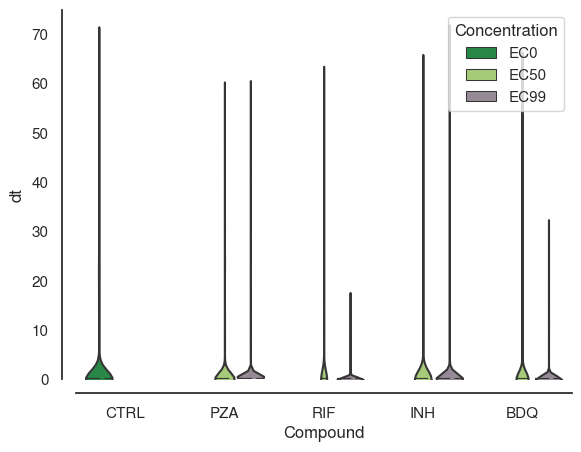

In [99]:
# Filtering to only include unique IDs
unique_df = df.drop_duplicates(subset='ID').fillna(0)

sns.violinplot(data=unique_df, 
              y = 'dt', x = 'Compound', 
              hue = 'Concentration', 
              palette=expanded_piyg, 
               inner = 'quart'
              )

plt.ylim(0, 75)
sns.despine(offset = 10)

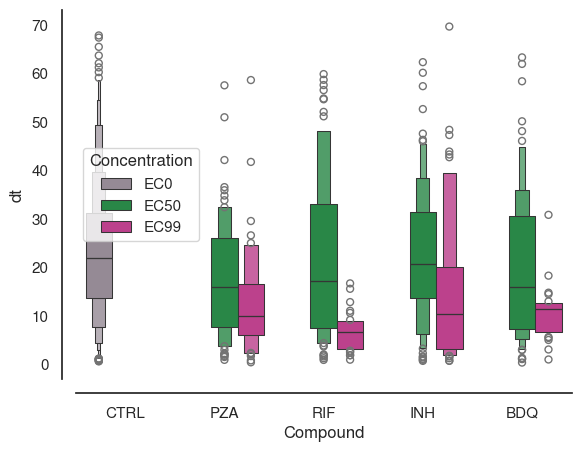

In [38]:
unique_df = df.drop_duplicates(subset='ID').fillna(0)
# unique_df = unique_df[unique_df['Concentration'] == 'EC50']
unique_df = unique_df[unique_df['dt']>0]
sns.boxenplot(data=unique_df, 
              y = 'dt', x = 'Compound', 
              hue = 'Concentration', 
              palette=[expanded_piyg[2], expanded_piyg[0], expanded_piyg[-1]], 
              # width = 1, 
              # dodge = False,
              # width_method = 'exponential'
              # k_depth = 'trustworthy', trust_alpha = 0.01
              # showfliers = False,
              # log_scale = True
              )

# plt.ylim(0, 75)
sns.despine(offset = 10)

In [41]:
unique_df

Time (hours)  Mtb Area (µm)  dMtb Area (µm)  Mphi Area (µm)  \
0                 0.0       0.424621       -0.424621      459.082108   
598               0.0       1.273862        4.313253     2161.498556   
748               0.0       4.223859       25.119671      627.522467   
898               0.0       5.877646        6.235221      805.863159   
973               0.0       3.441663        5.207192     1504.252635   
...               ...            ...             ...             ...   
1692993           0.0       2.637119        2.637119     2042.492996   
1693436           0.0       7.129159       26.080655     1280.902105   
1694647           2.5       3.687496       29.902242      647.345553   
1700149          20.0       0.000000       27.756790      177.670274   
1701514          26.5       0.000000        0.000000      895.346437   

         dMphi Area (µm)  Infection Status  Initial Infection Status  \
0             -92.746118               1.0                       1.0   
598          -363.765917               1.0                       1.0   
748           865.801770               1.0                       1.0   
898           680.354231               1.0                       1.0   
973           -73.951061               1.0                       1.0   
...                  ...               ...                       ...   
1692993     -1182.501826               1.0                       1.0   
1693436      -138.493420               1.0                       1.0   
1694647      1290.757776               1.0                       1.0   
1700149       741.119700               0.0                       0.0   
1701514      -232.468703               0.0                       0.0   

         Final Infection Status            x            y  ...  Strain  \
0                           0.0   457.172943     8.791715  ...     RD1   
598                         1.0   565.887878   149.968582  ...     RD1   
748                         1.0   315.274933   165.017120  ...     RD1   
898                         1.0   110.306488   154.769943  ...     RD1   
973                         1.0   615.001343   171.983200  ...     RD1   
...                         ...          ...          ...  ...     ...   
1692993                     1.0   678.118713   973.482544  ...     RD1   
1693436                     1.0   874.890991  1112.656006  ...     RD1   
1694647                     1.0   470.080475   457.259155  ...     RD1   
1700149                     1.0  1058.098755   492.210785  ...     RD1   
1701514                     0.0  1180.962402   727.347778  ...     RD1   

         Compound  Concentration  Cell ID  Acquisition ID  Experiment ID  \
0            CTRL            EC0      426          (3, 4)         PS0000   
598          CTRL            EC0      451          (3, 4)         PS0000   
748          CTRL            EC0      343          (3, 4)         PS0000   
898          CTRL            EC0      346          (3, 4)         PS0000   
973          CTRL            EC0      349          (3, 4)         PS0000   
...           ...            ...      ...             ...            ...   
1692993       INH           EC99      109         (6, 10)         ND0003   
1693436       INH           EC99       78         (6, 10)         ND0003   
1694647       INH           EC99      554         (6, 10)         ND0003   
1700149       INH           EC99     1759         (6, 10)         ND0003   
1701514       INH           EC99     2090         (6, 10)         ND0003   

         Unique ID                ID         dt  dts  
0          426.3.4    426.3.4.PS0000  14.892452    0  
598        451.3.4    451.3.4.PS0000  22.533835    0  
748        343.3.4    343.3.4.PS0000  17.563145    0  
898        346.3.4    346.3.4.PS0000  58.176524    0  
973        349.3.4    349.3.4.PS0000  35.481481    0  
...            ...               ...        ...  ...  
1692993   109.6.10   109.6.10.ND0003   9.006791    0  
1693436    78.6.10    78.6.10.ND0003 

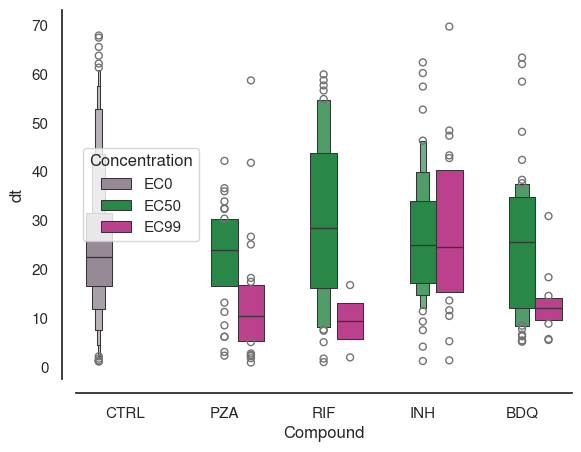

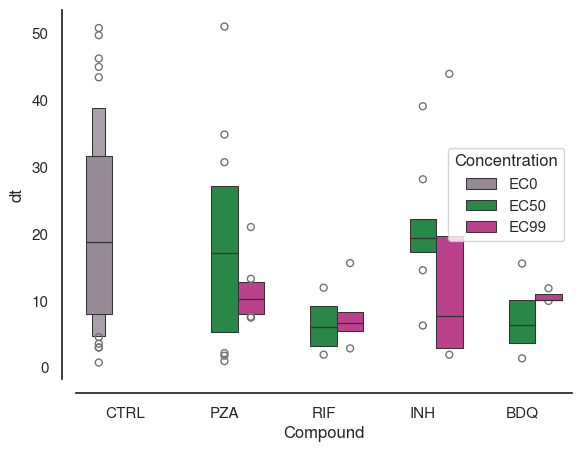

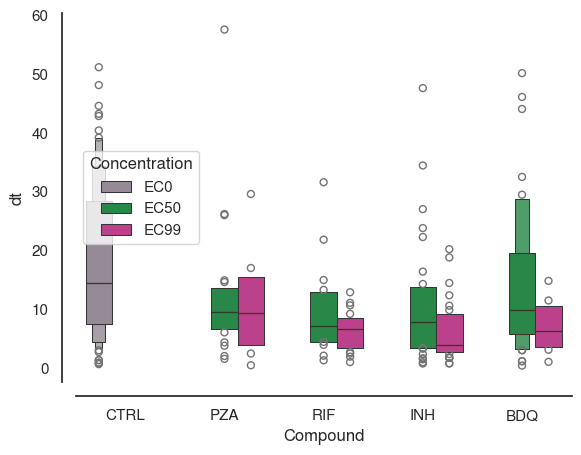

In [42]:
for expt_ID in ['PS0000', 'ND0002', 'ND0003']:
    unique_df = df.drop_duplicates(subset='ID').fillna(0)
    # unique_df = unique_df[unique_df['Concentration'] == 'EC50']
    unique_df = unique_df[unique_df['dt']>0]
    unique_df = unique_df[unique_df['Experiment ID'] == expt_ID]
    sns.boxenplot(data=unique_df, 
                  y = 'dt', x = 'Compound', 
                  hue = 'Concentration', 
                  palette=[expanded_piyg[2], expanded_piyg[0], expanded_piyg[-1]], 
                  # width = 1, 
                  # dodge = False,
                  # width_method = 'exponential'
                  # k_depth = 'trustworthy', trust_alpha = 0.01
                  # showfliers = False,
                  # log_scale = True
                  )
    
    # plt.ylim(0, 75)
    sns.despine(offset = 10)
    plt.show()

/tmp/ipykernel_1035003/2508995661.py:4: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.boxenplot(data=unique_df,


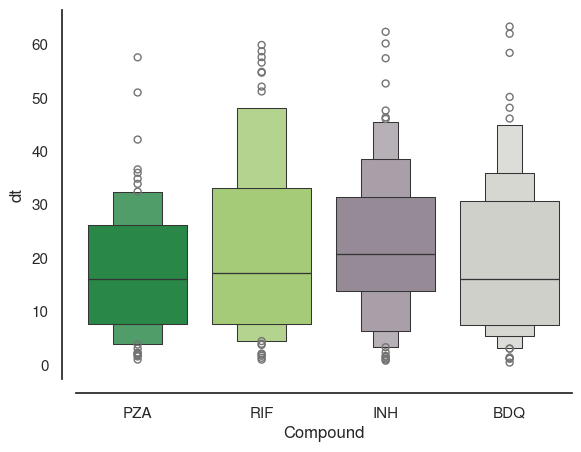

In [34]:
unique_df = df.drop_duplicates(subset='ID').fillna(0)
unique_df = unique_df[unique_df['Concentration'] == 'EC50']
unique_df = unique_df[unique_df['dt']>0]
sns.boxenplot(data=unique_df, 
              y = 'dt', x = 'Compound', 
              hue = 'Compound', 
              palette=expanded_piyg, 
              # width = 1, 
              # dodge = False,
              # width_method = 'exponential'
              # k_depth = 'trustworthy', trust_alpha = 0.01
              # showfliers = False,
              # log_scale = True
              )

# plt.ylim(0, 75)
sns.despine(offset = 10)

  0%|          | 0/4 [00:00<?, ?it/s]

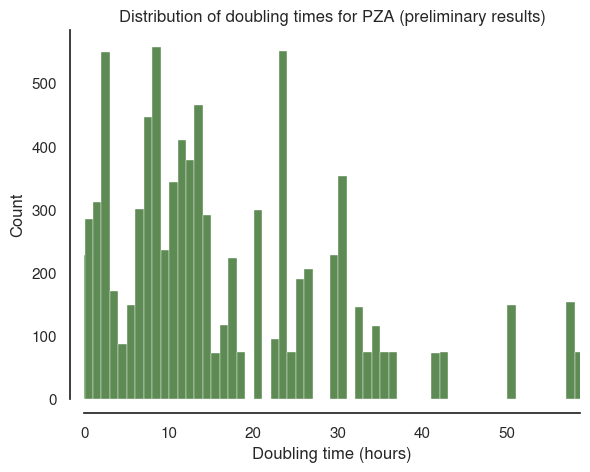

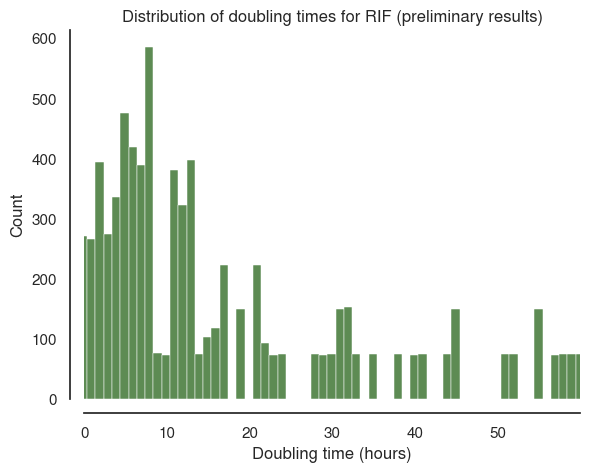

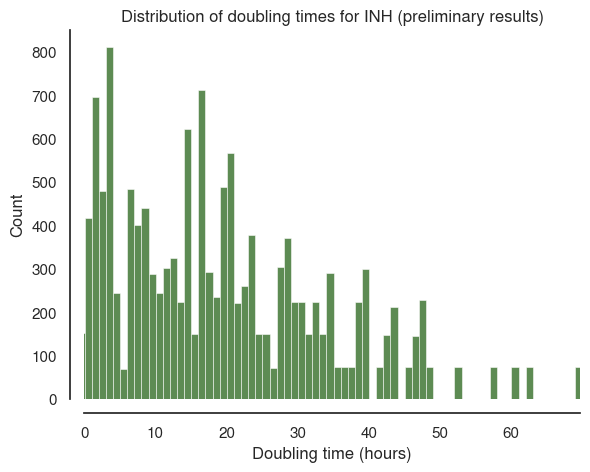

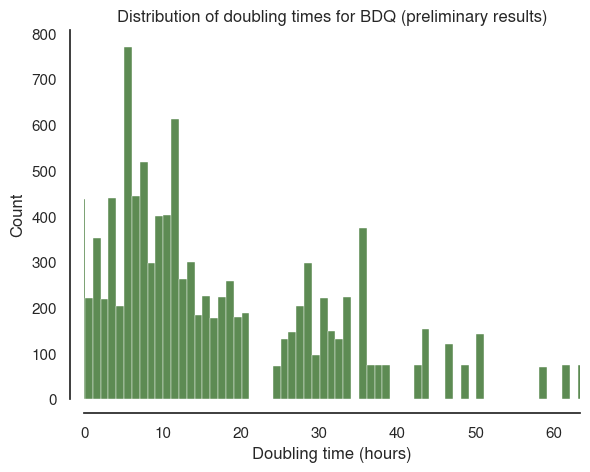

In [43]:
compounds = ['PZA', 'RIF', 'INH', 'BDQ']

for compound in tqdm(compounds):
    plt.clf()

    subset_df = df[df['Compound']==compound]['dt']
    sns.histplot(subset_df, color=green_colors[0])
    plt.title(f'Distribution of doubling times for {compound} (preliminary results)')
    plt.xlabel('Doubling time (hours)')
    plt.xlim(0, subset_df.max())
    sns.despine(offset=10)
    plt.show()

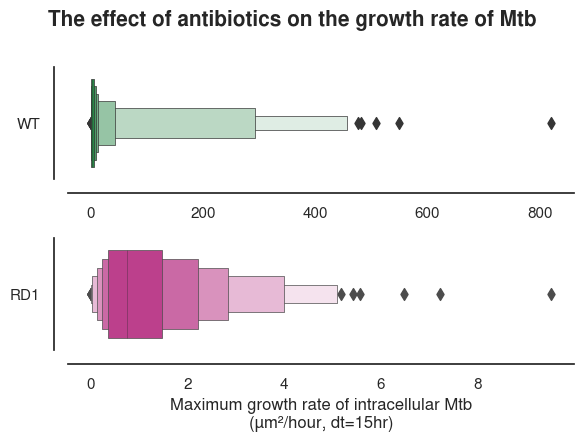

In [810]:
subset_df = df[df['Compound']=='CTRL']
subset_df['Acquisition ID'].unique()

# Create a figure with two vertically stacked subplots
fig, axes = plt.subplots(nrows=2, figsize=(6,4))

# Define palette colors
palette_colors = [expanded_piyg[0], expanded_piyg[-1]]

# Plot the first boxenplot (WT)
sns.boxenplot(
    x="Max. dMtb/dt,T=15", 
    y="Strain",
    hue="Strain",
    palette=[palette_colors[0]],
    data=subset_df.drop_duplicates('Max. dMtb/dt,T=15')[subset_df.drop_duplicates('Max. dMtb/dt,T=15')['Strain'] == 'WT'], 
    scale='linear',
        linewidth = linewidth,
    ax=axes[0]  # Use the first subplot
)
axes[0].set_xlabel("")
axes[0].set_ylabel("")  # Set the y-axis label

# Remove legend and title for the first subplot
axes[0].legend().set_visible(False)
axes[0].set_title('')

# Plot the second boxenplot (RD1)
sns.boxenplot(
    x="Max. dMtb/dt,T=15", 
    y="Strain",
    hue="Strain",
    palette=[palette_colors[1]],
    data=subset_df.drop_duplicates('Max. dMtb/dt,T=15')[subset_df.drop_duplicates('Max. dMtb/dt,T=15')['Strain'] == 'RD1'], 
    scale='linear',
        linewidth = linewidth,
    ax=axes[1]  # Use the second subplot
)
axes[1].set_xlabel("Maximum growth rate of intracellular Mtb\n(µm\u00b2/hour, dt=15hr)")
axes[1].set_ylabel("")  # Remove the y-axis label for the second subplot

# Remove legend and title for the second subplot
axes[1].legend().set_visible(False)
axes[1].set_title('')

sns.despine(offset=10)
# Adjust spacing between subplots
plt.tight_layout()

plt.gcf().suptitle('The effect of antibiotics on the growth rate of Mtb', 
                   fontsize=15, fontweight='bold', 
                  y = 1.1)
plt.savefig(os.path.join(output_dir, 'max_growth_rate_outliers_boxenplot.pdf'), bbox_inches = 'tight', dpi = 314)
# Show the combined plot
plt.show()

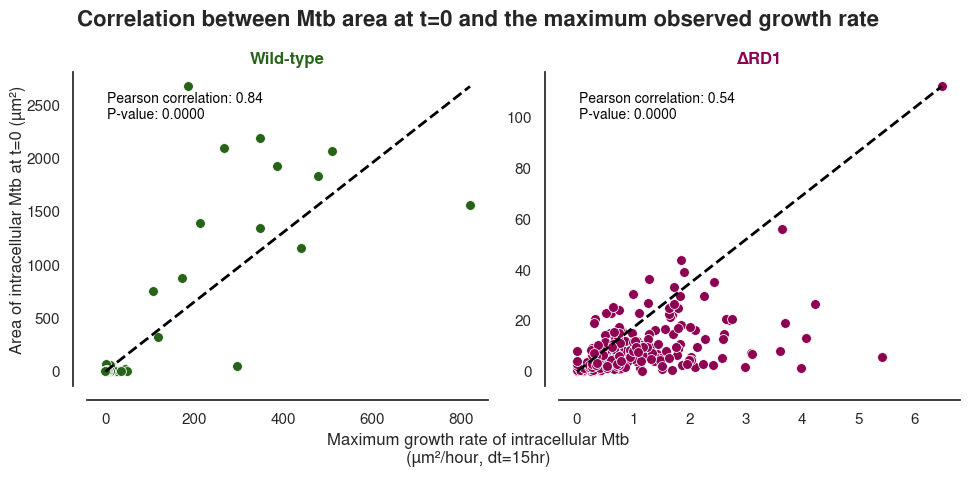

In [196]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr

# Assuming subset_df is your DataFrame
# Assuming custom_green_cmap and custom_pink_cmap are defined color maps

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=False)  # Add sharey=True to share the y-axis

for i, (strain, colour_map) in enumerate(zip(['WT', 'RD1'], [custom_green_cmap, custom_pink_cmap])):
    filtered_df = subset_df[(subset_df['Strain'] == strain)].drop_duplicates(subset=['Unique ID'], keep='first')
    N0 = filtered_df['Mtb Area']
    max_gr = filtered_df['Max. dMtb/dt,T=15']

    exluding_outliers = [(n, g) for n, g in zip(N0, max_gr) if 0< n]#<600]
    N0 = [i[0] for i in exluding_outliers]
    max_gr = [i[1] for i in exluding_outliers]
    
    sns.scatterplot(x=max_gr, y=N0, ax=axes[i], color=colour_map[0], s = 50, label='')#'ΔRD1' if strain != 'WT' else 'Wild-type')
    sns.despine(offset=10)
    axes[i].set_xlabel("")  # Clear the individual x-labels
    axes[i].set_ylabel("")  # Clear the individual y-labels
    
    # Calculate Pearson correlation coefficient and p-value
    corr_coef, p_value = pearsonr(max_gr, N0)
    
    # Plot the correlation line
    axes[i].plot([min(max_gr), max(max_gr)], [min(N0), max(N0)], color='black', linestyle='--', linewidth=2)
    
    # Annotate the correlation coefficient and p-value
    axes[i].annotate(f"Pearson correlation: {corr_coef:.2f}\nP-value: {p_value:.4f}"
                     , xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10, color='black')
    
    # Add subplot titles
    axes[i].set_title('ΔRD1' if strain != 'WT' else 'Wild-type', color=colour_map[0], fontweight = 'bold')

# Add a common xlabel and ylabel for the figure
fig.text(0.5, 0.04, "Maximum growth rate of intracellular Mtb\n(µm\u00b2/hour, dt=15hr)", ha='center', va='center')
fig.text(0.04, 0.5, "Area of intracellular Mtb at t=0 (µm\u00b2)", ha='center', va='center', rotation='vertical')

# Add a super title
fig.suptitle('Correlation between Mtb area at t=0 and the maximum observed growth rate', fontweight = 'bold', fontsize=16, y=0.92)

# Optionally, adjust the layout
plt.tight_layout(rect=[0.03, 0.05, 1, 0.95])

plt.savefig(os.path.join(base_dir, 'manuscript/N0_maxdmtbdt_control.pdf'), bbox_inches = 'tight', dpi = 314)
# Display the plot
plt.show()


# which dt examples do i have glimpses for

In [202]:
os.path.join(output_dir, f'dt_dev/smol/cell_ID:*doubling_time_WIP_calcs.pdf')

'/mnt/SYNO/macrohet_syno/manuscript/dt_dev/smol/cell_ID:*doubling_time_WIP_calcs.pdf'

In [208]:
fns = glob.glob(os.path.join(output_dir, f'dt_dev/cell_ID*doubling_time_WIP_calcs.pdf'))
fn = fns[0]

In [216]:
# Define the pattern to match the file names
pattern = re.compile(r'\[(.*?)\]')
match = pattern.search(fn).group(1).replace("'", "")

In [219]:
IDs = [pattern.search(fn).group(1).replace("'", "") for fn in fns]

In [294]:
glob_strs = [f'/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/{ID}.mp4' for ID in IDs]

In [295]:
fn

'/mnt/DATA/macrohet/PS0000/results/glimpses/fast_grower_area_graph/(5, 8)/99.5.8'

In [296]:
for ID in IDs:
    r,c = int(ID.split('.')[1]),int(ID.split('.')[2])
    fn = f'/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/{ID}.mp4'
    if os.path.exists(fn):
        print(fn)

/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/1.3.5.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/1.4.9.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/10.4.6.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/100.3.4.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/102.5.8.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/103.4.9.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/103.6.5.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/104.6.7.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/105.4.9.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/105.5.5.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/105.6.4.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/105.6.5.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/106.4.5.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/106.6.4.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/108.5.5.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/11.4.8.mp

### Checking if N from doubling series is in interpolated population

In [1215]:
type(average_doubling_time)

numpy.float64

In [32]:
dt_df = pd.read_pickle('/mnt/SYNO/macrohet_syno/manuscript/dt_df.pkl')

In [33]:
dt_df

Time (hours)   Mtb Area        dMtb Strain Compound Concentration  \
0                  0  46.797680  136.772588     WT     CTRL           EC0   
1                  1  48.719647  136.772588     WT     CTRL           EC0   
2                  2  52.206007  136.772588     WT     CTRL           EC0   
3                  3  50.552221  136.772588     WT     CTRL           EC0   
4                  4  54.463202  136.772588     WT     CTRL           EC0   
...              ...        ...         ...    ...      ...           ...   
296992            70   0.000000   -3.888632     WT     CTRL           EC0   
296993            71   0.000000   -3.888632     WT     CTRL           EC0   
296994            72   0.000000   -3.888632     WT     CTRL           EC0   
296995            73   0.000000   -3.888632     WT     CTRL           EC0   
296996            74   0.000000   -3.888632     WT     CTRL           EC0   

       Unique ID Acquisition ID  Cell ID  Mphi Area  ...  Infection Status  \
0          1.3.5         (3, 5)        1    29567.0  ...              True   
1          1.3.5         (3, 5)        1    26181.0  ...              True   
2          1.3.5         (3, 5)        1    26043.0  ...              True   
3          1.3.5         (3, 5)        1    25605.0  ...              True   
4          1.3.5         (3, 5)        1    26430.0  ...              True   
...          ...            ...      ...        ...  ...               ...   
296992   996.4.5         (4, 5)      996    32533.0  ...              True   
296993   996.4.5         (4, 5)      996    31403.0  ...              True   
296994   996.4.5         (4, 5)      996    33239.0  ...              True   
296995   996.4.5         (4, 5)      996    42445.0  ...              True   
296996   996.4.5         (4, 5)      996    35463.0  ...              True   

        Initial Infection Status  Final Infection Status  dMtb/dt,T=15  \
0                           True                    True           NaN   
1                           True                    True           NaN   
2                           True                    True           NaN   
3                           True                    True           NaN   
4                           True                    True           NaN   
...                          ...                     ...           ...   
296992                      True                   False           0.0   
296993                      True                   False           0.0   
296994                      True                   False           0.0   
296995                      True                   False           0.0   
296996                      True                   False           0.0   

        Max. dMtb/dt,T=15         dt           K         N0        b        m  
0                6.314185  35.572443  265.591737  15.549781  0.05123  0.52539  
1                6.314185  35.572443  265.591737  15.549781  0.05123  0.52539  
2                6.314185  35.572443  265.591737  15.549781  0.05123  0.52539  
3                6.314185  35.572443  265.591737  15.549781  0.05123  0.52539  
4                6.314185  35.572443  265.591737  15.549781  0.05123  0.52539  
...                   ...        ...         ...        ...      ...      ...  
296992           0.064066        NaN        None       None     None     None  
296993           0.064066        NaN        None       None     None     None  
296994           0.064066        NaN        None       None     None     None  
296995           0.064066        NaN        None       None     None     None  
296996           0.064066        NaN        None       None     None     None  

[291526 rows x 32 columns]

In [28]:
dt_df['Acquisition ID'].unique()

array([(3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 4), (4, 5),
       (4, 6), (4, 7), (4, 8), (4, 9), (5, 4), (5, 5), (5, 6), (5, 7),
       (5, 8), (5, 9), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9),
       (3, 1), (3, 2), (3, 3), (3, 10), (3, 11), (3, 12), (4, 3), (4, 10),
       (4, 11), (4, 12), (5, 3), (5, 10), (5, 11), (5, 12), (6, 10),
       (6, 11), (6, 12), (6, 3)], dtype=object)

(array([4767., 7533., 9992., 9633., 6864., 3432., 2466., 2393., 2017.,
        1047.]),
 array([ 0.28087726,  7.47294679, 14.66501632, 21.85708585, 29.04915538,
        36.24122491, 43.43329444, 50.62536396, 57.81743349, 65.00950302,
        72.20157255]),
 <BarContainer object of 10 artists>)

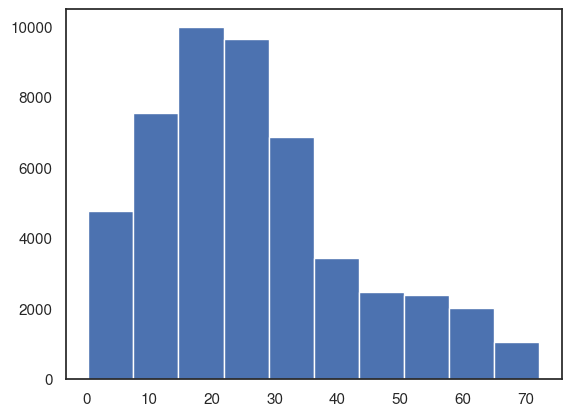

In [34]:
plt.hist(dt_df['dt'])

<Axes: xlabel='dt', ylabel='Count'>

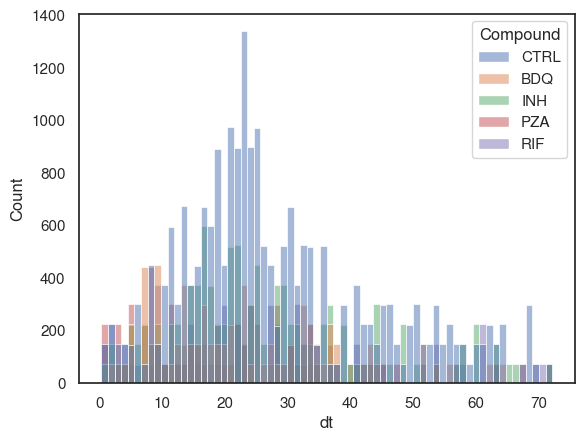

In [35]:
sns.histplot(data = dt_df, x = 'dt', hue = 'Compound')

<Axes: xlabel='dt'>

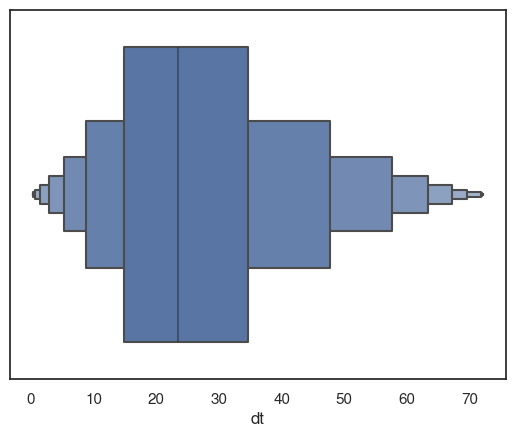

In [310]:
sns.boxenplot(data = dt_df, x = 'dt', hue = 'Compound', )#col='ConcentrationEC')

In [36]:
df

Time (hours)  Mtb Area (µm)  dMtb Area (µm)  Mphi Area (µm)  \
0                 0.0       0.424621       -0.424621      459.082108   
1                 1.0       0.000000       -0.424621      372.839393   
2                 2.0       0.000000       -0.424621      423.168130   
3                 3.0       0.335227       -0.424621      445.561289   
4                 4.0       0.000000       -0.424621      487.040034   
...               ...            ...             ...             ...   
1722130          74.5       1.117423        1.095075      752.584461   
1722131          75.0       2.033710        1.095075      616.035357   
1722132          75.5       1.430302        1.095075      579.182743   
1722133          76.0       1.989013        1.095075      679.147414   
1722134          76.5       2.123104        1.095075      770.686715   

         dMphi Area (µm)  Infection Status  Initial Infection Status  \
0             -92.746118               1.0                       1.0   
1             -92.746118               0.0                       1.0   
2             -92.746118               0.0                       1.0   
3             -92.746118               1.0                       1.0   
4             -92.746118               1.0                       1.0   
...                  ...               ...                       ...   
1722130        55.088959               1.0                       1.0   
1722131        55.088959               1.0                       1.0   
1722132        55.088959               1.0                       1.0   
1722133        55.088959               1.0                       1.0   
1722134        55.088959               1.0                       1.0   

         Final Infection Status           x           y  ...  \
0                           0.0  457.172943    8.791715  ...   
1                           0.0  459.138947    6.718642  ...   
2                           0.0  460.555237   10.785886  ...   
3                           0.0  455.878815   11.143067  ...   
4                           0.0  462.634186   14.050420  ...   
...                         ...         ...         ...  ...   
1722130                     1.0  227.093262  130.358139  ...   
1722131                     1.0  226.622925  130.532120  ...   
1722132                     1.0  225.366608  129.932709  ...   
1722133                     1.0  226.424683  128.489410  ...   
1722134                     1.0  225.741119  126.533669  ...   

         Technical Replicate  Biological Replicate  Strain  Compound  \
0                          1                     1     RD1      CTRL   
1                          1                     1     RD1      CTRL   
2                          1                     1     RD1      CTRL   
3                          1                     1     RD1      CTRL   
4                          1                     1     RD1      CTRL   
...                      ...                   ...     ...       ...   
1722130                    2                     3     RD1       BDQ   
1722131                    2                     3     RD1       BDQ   
1722132                    2                     3     RD1       BDQ   
1722133                    2                     3     RD1       BDQ   
1722134                    2                     3     RD1       BDQ   

         Concentration  Cell ID Acquisition ID Experiment ID  Unique ID  \
0                  EC0      426         (3, 4)        PS0000    426.3.4   
1                  EC0      426         (3, 4)        PS0000    426.3.4   
2                  EC0      426         (3, 4)        PS0000    426.3.4   
3                  EC0      426         (3, 4)        PS0000    426.3.4   
4                  EC0      426         (3, 4)        PS0000    426.3.4   
...                ...      ...            ...           ...        ...   
1722130           EC99     1874        (6, 12)        ND0003  1874.6.12   
1722131           EC99     1874        (6, 12

In [41]:
len(df[df['Experiment ID'] == 'PS0000']['ID'].unique())

3914

In [314]:

import matplotlib as mpl

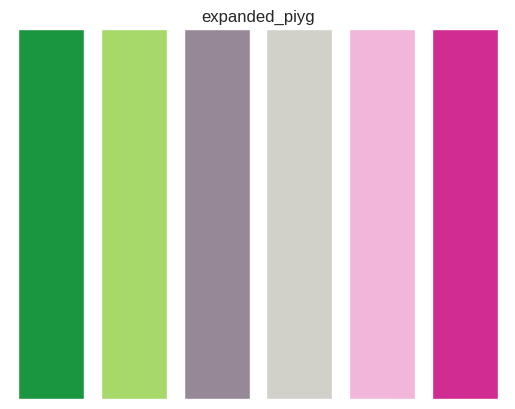

['#1a9641', '#a6d96a', '#978897', '#d1d1ca', '#f1b6da', '#d02c91']


In [315]:
# set display params
sns.set(style = 'white')
# Set the default font to Helvetica
mpl.rcParams['font.family'] = 'Liberation Sans'
# Get the color palette of the PiYG color map
expanded_piyg = visualise.color_palette('expanded_piyg').colors
sns.set_palette(expanded_piyg)
# Display the colors in the PiYG color map
visualise.show_colors('expanded_piyg')
print(expanded_piyg)

In [321]:
subset_df

Empty DataFrame
Columns: [index, Time (hours), x, y, x scaled, y scaled, Infection status, Initial infection status, Final infection status, Area, Mtb Area, Eccentricity, MSD, Strain, Compound, Concentration, Technical replicate, Cell ID, Acquisition ID, Unique ID]
Index: []

In [318]:
custom_order = ['RD1', 'CTRL', 'PZA', 'RIF', 'INH', 'BDQ']

In [22]:
# fig, axes = plt.subplots(nrows=3, figsize=(6,6))

# Plot the last boxenplot 
sns.boxenplot(    x="dt", 
    y="Strain",
    hue="Strain",
     k_depth=k_depth,# "proportion", "trustworthy", "full"
    palette=[expanded_piyg[-1], expanded_piyg[0], expanded_piyg[1]],
    data=dt_df.drop_duplicates(subset=['Unique ID'], keep='first'), 
    scale='linear',
    width = 0.9,
    linewidth = linewidth,
    flier_kws = dict(marker='x', 
                     color='black',#green_colors[0],
                     edgecolors='black',#expanded_piyg[2],
                     linewidths=linewidth*2,
                     s=50,
                    ),
    order= ['RD1', 'WT'],
    # ax=axes[2]  # Use the first subplot
)
linewidth = 0.5
# Create a figure with two vertically stacked subplots

plt.xlabel("Doubling time (hours)")
plt.ylabel("")  # Set the y-axis label
# axes[2].set_xlim(0)
sns.despine(offset=10)
# Adjust spacing between subplots
plt.tight_layout()

plt.gcf().suptitle(f'Distribution of intracellular Mtb doubling times (unverified)',# k_depth_vis={k_depth}', 
                   fontsize=15, fontweight=1000, 
                  y = 1.1)

plt.savefig(os.path.join(output_dir, 'dt_outliers_boxenplot_w_shared_axis.pdf'), bbox_inches = 'tight', dpi = 314)
# Show the combined plot
plt.show()



NameError: name 'k_depth' is not defined

In [336]:
filtered_df

Time (hours)   Mtb Area        dMtb Strain Compound Concentration  \
0                  0  46.797680  136.772588     WT     CTRL           EC0   
73                 0   1.743180  121.732073     WT      BDQ          EC50   
148                0   0.000000    0.000000     WT      INH          EC99   
222                0   0.000000  232.200521     WT     CTRL           EC0   
297                0  11.442413   -1.028029     WT      BDQ          EC99   
...              ...        ...         ...    ...      ...           ...   
296560             0   7.017417   -7.017417     WT      PZA          EC99   
296635             0   0.536363   24.918535     WT      INH          EC99   
296709             0   0.000000    0.000000     WT      INH          EC99   
296784             4   2.346589   32.829891     WT     CTRL           EC0   
296926             4   3.888632   -3.888632     WT     CTRL           EC0   

       Unique ID Acquisition ID  Cell ID  Mphi Area  ...  Infection Status  \
0          1.3.5         (3, 5)        1    29567.0  ...              True   
73         1.4.9         (4, 9)        1    21687.0  ...              True   
148        1.5.8         (5, 8)        1    48699.0  ...              True   
222        1.6.5         (6, 5)        1    43569.0  ...              True   
297        1.6.9         (6, 9)        1    67519.0  ...              True   
...          ...            ...      ...        ...  ...               ...   
296560    99.5.6         (5, 6)       99    39753.0  ...              True   
296635    99.5.8         (5, 8)       99    13841.0  ...              True   
296709    99.6.8         (6, 8)       99    18719.0  ...              True   
296784   991.4.5         (4, 5)      991    68784.0  ...              True   
296926   996.4.5         (4, 5)      996    43829.0  ...              True   

        Initial Infection Status  Final Infection Status  dMtb/dt,T=15  \
0                           True                    True           NaN   
73                         False                    True           NaN   
148                        False                   False           NaN   
222                        False                    True           NaN   
297                         True                    True           NaN   
...                          ...                     ...           ...   
296560                      True                   False           NaN   
296635                      True                    True           NaN   
296709                     False                   False           NaN   
296784                      True                    True           NaN   
296926                      True                   False           NaN   

        Max. dMtb/dt,T=15         dt           K         N0         b  \
0                6.314185  35.572443  265.591737  15.549781   0.05123   
73              11.741882  14.558938   112.51362   0.117724  0.175428   
148              0.470808        NaN        None       None      None   
222             16.962483        NaN        None       None      None   
297              0.665984        NaN        None       None      None   
...                   ...        ...         ...        ...       ...   
296560           0.490176        NaN        None       None      None   
296635           6.224792  58.124391  170.334187    2.86467  0.054319   
296709           0.195177        NaN        None       None      None   
296784           1.531615        NaN        None       None      None   
296926           0.064066        NaN        None       None      None   

               m  
0        0.52539  
73      0.427547  
148         None  
222         None  
297         None  
...          ...  
296560      None  
296635  0.319648  
296709      None  
296784      None  
296926      None  

[3310 rows x 32 columns]

In [389]:
dt_df.keys()

Index(['Time (hours)', 'Mtb Area', 'dMtb', 'Strain', 'Compound',
       'Concentration', 'Unique ID', 'Acquisition ID', 'Cell ID', 'Mphi Area',
       'Mphi GFP', 'x', 'y', 'Eccentricity', 'MSD', 'Technical Replicate',
       'Strain/Compound', 'dMtb/dt', '%dMtb/dt', '%dMtb', 'Mean Mtb Intensity',
       'Thresholded Mean Mtb Intensity', 'Infection Status',
       'Initial Infection Status', 'Final Infection Status', 'dMtb/dt,T=15',
       'Max. dMtb/dt,T=15', 'dt', 'K', 'N0', 'b', 'm'],
      dtype='object')

In [390]:
help(pearsonr)

Help on function pearsonr in module scipy.stats._stats_py:

pearsonr(x, y, *, alternative='two-sided', method=None)
    Pearson correlation coefficient and p-value for testing non-correlation.
    
    The Pearson correlation coefficient [1]_ measures the linear relationship
    between two datasets. Like other correlation
    coefficients, this one varies between -1 and +1 with 0 implying no
    correlation. Correlations of -1 or +1 imply an exact linear relationship.
    Positive correlations imply that as x increases, so does y. Negative
    correlations imply that as x increases, y decreases.
    
    This function also performs a test of the null hypothesis that the
    distributions underlying the samples are uncorrelated and normally
    distributed. (See Kowalski [3]_
    for a discussion of the effects of non-normality of the input on the
    distribution of the correlation coefficient.)
    The p-value roughly indicates the probability of an uncorrelated system
    producing 

WT
RD1


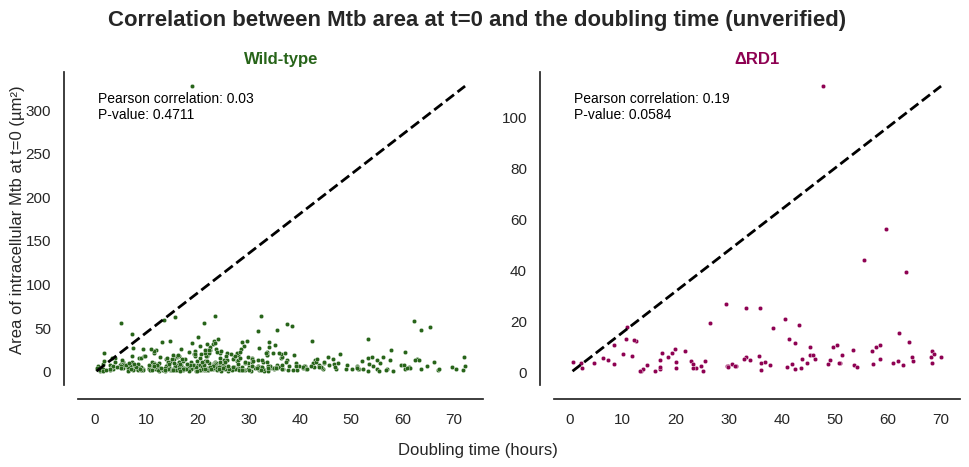

In [346]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr

# Assuming subset_df is your DataFrame
# Assuming custom_green_cmap and custom_pink_cmap are defined color maps

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=False)  # Add sharey=True to share the y-axis

for i, (strain, colour_map) in enumerate(zip(['WT', 'RD1'], [custom_green_cmap, custom_pink_cmap])):
    print(strain)
    # if strain == 'WT':
        
    filtered_df = dt_df[(dt_df['Strain'] == strain)].drop_duplicates(subset=['Unique ID'], keep='first')
    filtered_df = filtered_df[filtered_df['Mtb Area'] <= 500]
    filtered_df = filtered_df.dropna(subset=['dt'])
    
    N0 = filtered_df['Mtb Area']
    max_gr = filtered_df['dt']

    exluding_outliers = [(n, g) for n, g in zip(N0, max_gr) if 0< n]#<600]
    N0 = [i[0] for i in exluding_outliers]
    max_gr = [i[1] for i in exluding_outliers]
    
    sns.scatterplot(x=max_gr, y=N0, ax=axes[i], color=colour_map[0], s = 10, label='')#'ΔRD1' if strain != 'WT' else 'Wild-type')
    sns.despine(offset=10)
    axes[i].set_xlabel("")  # Clear the individual x-labels
    axes[i].set_ylabel("")  # Clear the individual y-labels
    
    # Calculate Pearson correlation coefficient and p-value
    corr_coef, p_value = pearsonr(max_gr, N0)
    
    # Plot the correlation line
    axes[i].plot([min(max_gr), max(max_gr)], [min(N0), max(N0)], color='black', linestyle='--', linewidth=2)
    
    # Annotate the correlation coefficient and p-value
    axes[i].annotate(f"Pearson correlation: {corr_coef:.2f}\nP-value: {p_value:.4f}"
                     , xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10, color='black')
    
    # Add subplot titles
    axes[i].set_title('ΔRD1' if strain != 'WT' else 'Wild-type', color=colour_map[0], fontweight = 'bold')

# Add a common xlabel and ylabel for the figure
fig.text(0.5, 0.04, "Doubling time (hours)", ha='center', va='center')
fig.text(0.04, 0.5, "Area of intracellular Mtb at t=0 (µm\u00b2)", ha='center', va='center', rotation='vertical')

# Add a super title
fig.suptitle('Correlation between Mtb area at t=0 and the doubling time (unverified)', fontweight = 'bold', fontsize=16, y=0.92)

# Optionally, adjust the layout
plt.tight_layout(rect=[0.03, 0.05, 1, 0.95])

plt.savefig(os.path.join(base_dir, 'manuscript/crop_N0_dt_control.pdf'), bbox_inches = 'tight', dpi = 314)
# Display the plot
plt.show()


In [ ]:
g = sns.boxenplot(x="dt", y="Strain/Compound",
            hue="Concentration", 
            palette=[expanded_piyg[-1], expanded_piyg[0], expanded_piyg[1]],
            data=dt_df, 
            scale = 'linear', order = custom_order
              )  
sns.despine(offset = 10)
# g.set_xscale('log')
plt.xlabel("Doubling time of intracellular Mtb (hours)")
plt.gcf().suptitle('The effect of antibiotics on the growth rate of Mtb', 
                   fontsize=15, fontweight='bold', 
                  y = 1.0)
sns.despine(offset=10)
plt.legend(loc = 'lower right')
# plt.savefig(os.path.join(output_dir, 'ATB_effect_max_growth_rate.png'), bbox_inches = 'tight', dpi = 314)

In [ ]:
g = sns.boxenplot(x="dt", y="Strain/Compound",
            hue="Concentration", 
            palette=[expanded_piyg[-1], expanded_piyg[0], expanded_piyg[1]],
            data=df, 
            scale = 'linear', order = custom_order
              )  
sns.despine(offset = 10)
# g.set_xscale('log')
plt.xlabel("Doubling time of intracellular Mtb (hours)")
plt.gcf().suptitle('The effect of antibiotics on the growth rate of Mtb', 
                   fontsize=15, fontweight='bold', 
                  y = 1.0)
sns.despine(offset=10)
plt.legend(loc = 'lower right')
# plt.savefig(os.path.join(output_dir, 'ATB_effect_max_growth_rate.png'), bbox_inches = 'tight', dpi = 314)

In [351]:
len(PS_sc_df), len(ND_sc_df)

(291526, 227591)

In [352]:
sns.boxenplot(    x="dt", 
    y="Strain",
    hue="Strain",
     k_depth=k_depth,# "proportion", "trustworthy", "full"
    palette=[expanded_piyg[-1], expanded_piyg[0], expanded_piyg[1]],
    data=dt_df.drop_duplicates(subset=['Unique ID'], keep='first'), 
    scale='linear',
    width = 0.9,
    linewidth = linewidth,
    flier_kws = dict(marker='x', 
                     color='black',#green_colors[0],
                     edgecolors='black',#expanded_piyg[2],
                     linewidths=linewidth*2,
                     s=50,
                    ),
    order= ['RD1', 'WT'],
    # ax=axes[2]  # Use the first subplot
)
linewidth = 0.5
# Create a figure with two ver

Index(['Time (hours)', 'Mtb Area', 'dMtb', 'Strain', 'Compound',
       'Concentration', 'Unique ID', 'Acquisition ID', 'Cell ID', 'Mphi Area',
       'Mphi GFP', 'x', 'y', 'Eccentricity', 'MSD', 'Technical Replicate',
       'Strain/Compound', 'dMtb/dt', '%dMtb/dt', '%dMtb', 'Mean Mtb Intensity',
       'Thresholded Mean Mtb Intensity', 'Infection Status',
       'Initial Infection Status', 'Final Infection Status', 'dMtb/dt,T=15',
       'Max. dMtb/dt,T=15', 'Mtb area new (um2)'],
      dtype='object')

/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/categorical.py:1953: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(xs_outliers, ys_outliers,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/categorical.py:1953: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(xs_outliers, ys_outliers,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/categorical.py:1953: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(xs_outliers, ys_outliers,
/home/dayn/miniconda3/envs/egg/lib/pytho

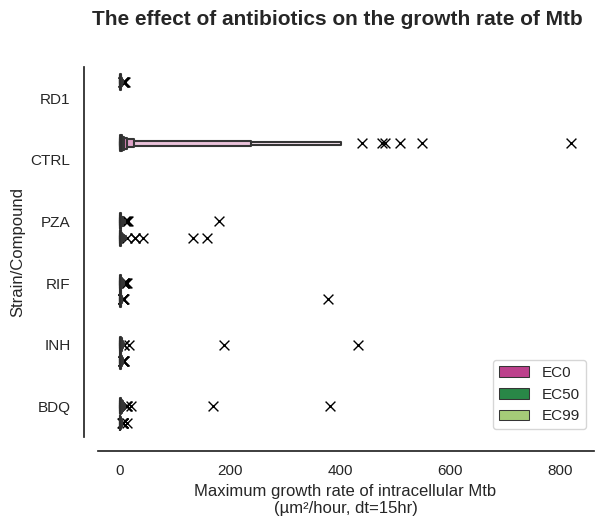

In [356]:
g = sns.boxenplot(x="Max. dMtb/dt,T=15", y="Strain/Compound",
            hue="Concentration", 
            palette=[expanded_piyg[-1], expanded_piyg[0], expanded_piyg[1]],
            data=df.drop_duplicates(subset=['Unique ID'], keep='first'),
            scale = 'linear', order = custom_order, 
                  flier_kws = dict(marker='x', 
                     color='black',#green_colors[0],
                     edgecolors='black',#expanded_piyg[2],
                     linewidths=linewidth*2,
                     s=50,)
              )  
sns.despine(offset = 10)
# g.set_xscale('log')
plt.xlabel("Maximum growth rate of intracellular Mtb\n(µm\u00b2/hour, dt=15hr)")
plt.gcf().suptitle('The effect of antibiotics on the growth rate of Mtb', 
                   fontsize=15, fontweight='bold', 
                  y = 1.0)
sns.despine(offset=10)
plt.legend(loc = 'lower right')
# plt.savefig(os.path.join(output_dir, 'ATB_effect_max_growth_rate.png'), bbox_inches = 'tight', dpi = 314)

/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/categorical.py:1953: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(xs_outliers, ys_outliers,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/categorical.py:1953: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(xs_outliers, ys_outliers,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/categorical.py:1953: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(xs_outliers, ys_outliers,
/home/dayn/miniconda3/envs/egg/lib/pytho

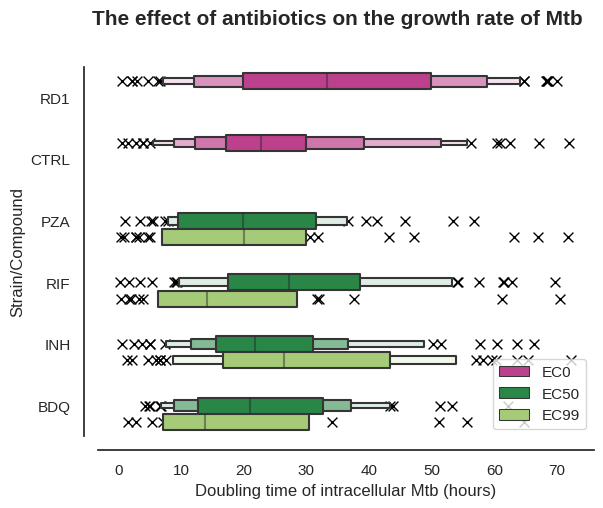

In [358]:
g = sns.boxenplot(x="dt", y="Strain/Compound",
            hue="Concentration", 
            palette=[expanded_piyg[-1], expanded_piyg[0], expanded_piyg[1]],
            data=dt_df.drop_duplicates(subset=['Unique ID'], keep='first'),
            scale = 'linear', order = custom_order, 
                  flier_kws = dict(marker='x', 
                     color='black',#green_colors[0],
                     edgecolors='black',#expanded_piyg[2],
                     linewidths=linewidth*2,
                     s=50,)
              )  
sns.despine(offset = 10)
# g.set_xscale('log')
plt.xlabel("Doubling time of intracellular Mtb (hours)")
plt.gcf().suptitle('The effect of antibiotics on the growth rate of Mtb', 
                   fontsize=15, fontweight='bold', 
                  y = 1.0)
sns.despine(offset=10)
plt.legend(loc = 'lower right')
# plt.savefig(os.path.join(output_dir, 'ATB_effect_max_growth_rate.png'), bbox_inches = 'tight', dpi = 314)

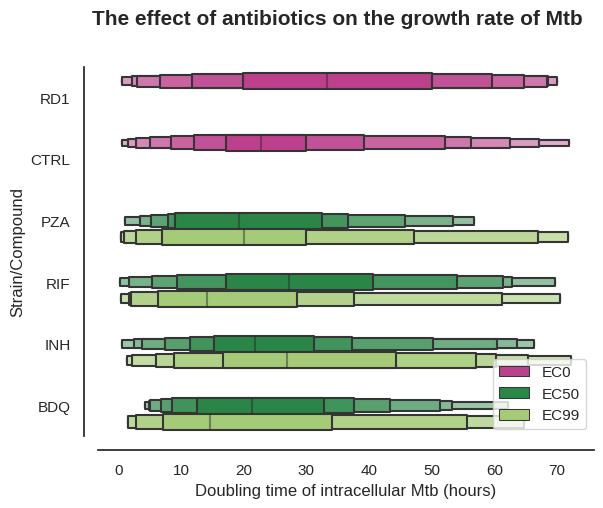

In [360]:
g = sns.boxenplot(x="dt", y="Strain/Compound",
            hue="Concentration", 
            palette=[expanded_piyg[-1], expanded_piyg[0], expanded_piyg[1]],
            data=dt_df, 
            scale = 'linear', order = custom_order
              )  
sns.despine(offset = 10)
# g.set_xscale('log')
plt.xlabel("Doubling time of intracellular Mtb (hours)")
plt.gcf().suptitle('The effect of antibiotics on the growth rate of Mtb', 
                   fontsize=15, fontweight='bold', 
                  y = 1.0)
sns.despine(offset=10)
plt.legend(loc = 'lower right')
plt.savefig(os.path.join(output_dir, 'ATB_effect_dt_unverified.pdf'), bbox_inches = 'tight', dpi = 314)

In [366]:
dt_df['Strain/Compound'].unique()

array(['CTRL', 'BDQ', 'INH', 'PZA', 'RIF', 'RD1'], dtype=object)

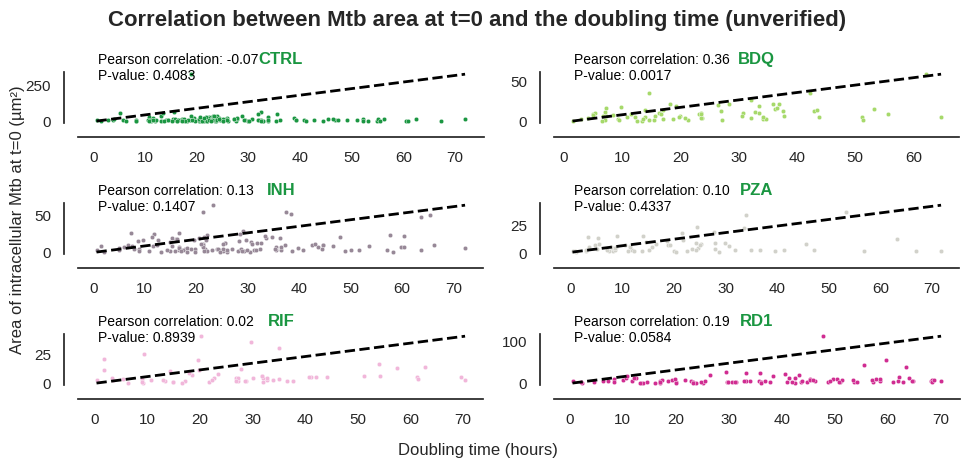

In [383]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Assuming dt_df is your DataFrame
# Assuming custom_green_cmap and custom_pink_cmap are defined color maps
colour_map = expanded_piyg
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 5), sharey=False)  # Add sharey=True to share the y-axis

for i, (strain) in enumerate(dt_df['Strain/Compound'].unique()):
    filtered_df = dt_df[(dt_df['Strain/Compound'] == strain)].drop_duplicates(subset=['Unique ID'], keep='first')
    filtered_df = filtered_df[filtered_df['Mtb Area'] <= 500]
    filtered_df = filtered_df.dropna(subset=['dt'])
    
    N0 = filtered_df['Mtb Area']
    max_gr = filtered_df['dt']

    excluding_outliers = [(n, g) for n, g in zip(N0, max_gr) if 0 < n]  # < 600]
    N0 = [i[0] for i in excluding_outliers]
    max_gr = [i[1] for i in excluding_outliers]
    
    sns.scatterplot(x=max_gr, y=N0, ax=axes[i//2, i%2], color=colour_map[i], s=10, label='')  # 'ΔRD1' if strain != 'WT' else 'Wild-type')
    sns.despine(offset=10)
    axes[i//2, i%2].set_xlabel("")  # Clear the individual x-labels
    axes[i//2, i%2].set_ylabel("")  # Clear the individual y-labels
    
    # Calculate Pearson correlation coefficient and p-value
    corr_coef, p_value = pearsonr(max_gr, N0)
    
    # Plot the correlation line
    axes[i//2, i%2].plot([min(max_gr), max(max_gr)], [min(N0), max(N0)], color='black', linestyle='--', linewidth=2)
    
    # Annotate the correlation coefficient and p-value
    axes[i//2, i%2].annotate(f"Pearson correlation: {corr_coef:.2f}\nP-value: {p_value:.4f}",
                             xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10, color='black')
    
    # Add subplot titles
    axes[i//2, i%2].set_title(strain, color=colour_map[0], fontweight='bold')

# Add a common xlabel and ylabel for the figure
fig.text(0.5, 0.04, "Doubling time (hours)", ha='center', va='center')
fig.text(0.04, 0.5, "Area of intracellular Mtb at t=0 (µm²)", ha='center', va='center', rotation='vertical')

# Add a super title
fig.suptitle('Correlation between Mtb area at t=0 and the doubling time (unverified)', fontweight='bold', fontsize=16, y=0.92)

# Optionally, adjust the layout
plt.tight_layout(rect=[0.03, 0.05, 1, 0.95])

plt.savefig(os.path.join(output_dir, 'scatter_plot_N0_dt.pdf'), bbox_inches='tight', dpi=314)
# Display the plot
plt.show()


In [380]:
len(dt_df[dt_df['dt']>0]['Unique ID'].unique())

672

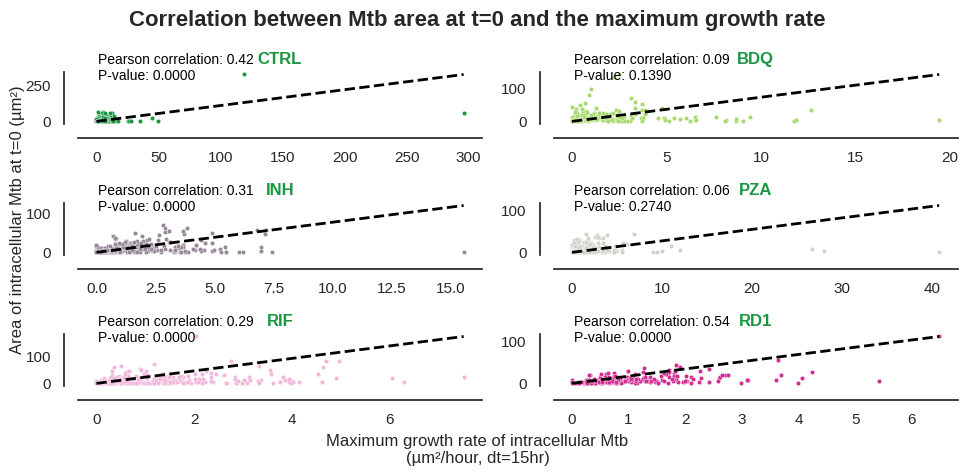

In [376]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Assuming dt_df is your DataFrame
# Assuming custom_green_cmap and custom_pink_cmap are defined color maps
colour_map = expanded_piyg
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 5), sharey=False)  # Add sharey=True to share the y-axis

for i, (strain) in enumerate(dt_df['Strain/Compound'].unique()):
    filtered_df = df[(df['Strain/Compound'] == strain)].drop_duplicates(subset=['Unique ID'], keep='first')
    filtered_df = filtered_df[filtered_df['Mtb Area'] <= 500]
    filtered_df = filtered_df.dropna(subset=['Max. dMtb/dt,T=15'])
    
    N0 = filtered_df['Mtb Area']
    max_gr = filtered_df['Max. dMtb/dt,T=15']

    excluding_outliers = [(n, g) for n, g in zip(N0, max_gr) if 0 < n]  # < 600]
    N0 = [i[0] for i in excluding_outliers]
    max_gr = [i[1] for i in excluding_outliers]
    
    sns.scatterplot(x=max_gr, y=N0, ax=axes[i//2, i%2], color=colour_map[i], s=10, label='')  # 'ΔRD1' if strain != 'WT' else 'Wild-type')
    sns.despine(offset=10)
    axes[i//2, i%2].set_xlabel("")  # Clear the individual x-labels
    axes[i//2, i%2].set_ylabel("")  # Clear the individual y-labels
    
    # Calculate Pearson correlation coefficient and p-value
    corr_coef, p_value = pearsonr(max_gr, N0)
    
    # Plot the correlation line
    axes[i//2, i%2].plot([min(max_gr), max(max_gr)], [min(N0), max(N0)], color='black', linestyle='--', linewidth=2)
    
    # Annotate the correlation coefficient and p-value
    axes[i//2, i%2].annotate(f"Pearson correlation: {corr_coef:.2f}\nP-value: {p_value:.4f}",
                             xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10, color='black')
    
    # Add subplot titles
    axes[i//2, i%2].set_title(strain, color=colour_map[0], fontweight='bold')

# Add a common xlabel and ylabel for the figure
fig.text(0.5, 0.04, "Maximum growth rate of intracellular Mtb\n(µm\u00b2/hour, dt=15hr)", ha='center', va='center')
fig.text(0.04, 0.5, "Area of intracellular Mtb at t=0 (µm²)", ha='center', va='center', rotation='vertical')

# Add a super title
fig.suptitle('Correlation between Mtb area at t=0 and the maximum growth rate', fontweight='bold', fontsize=16, y=0.92)

# Optionally, adjust the layout
plt.tight_layout(rect=[0.03, 0.05, 1, 0.95])

plt.savefig(os.path.join(output_dir, 'scatter_plot_N0_maxmdmtb.pdf'), bbox_inches='tight', dpi=314)
# Display the plot
plt.show()


<Axes: xlabel='Mtb Area', ylabel='Count'>

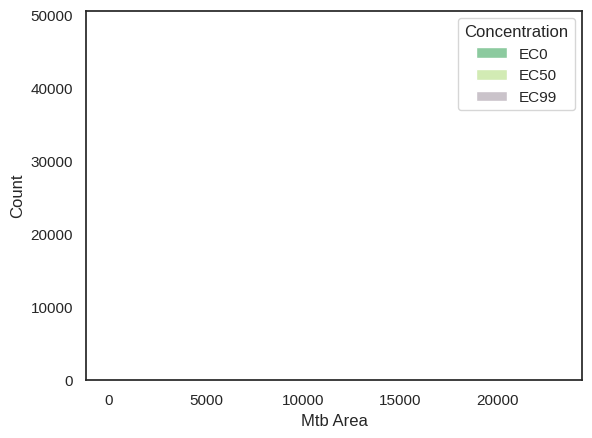

In [386]:
sns.histplot(data = df, x = 'Mtb Area', hue = 'Strain/Compound')

<Axes: xlabel='Mtb Area', ylabel='Count'>

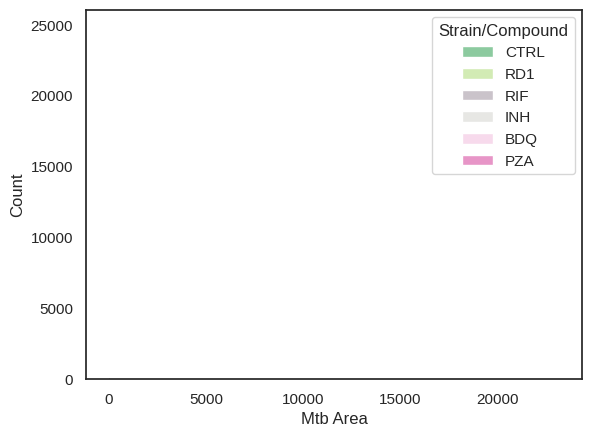

In [387]:
sns.histplot(data = df, x = 'Mtb Area', hue = 'Strain/Compound')

# Arx

### Comparing Atbs

#### Add repeat number to assay layout

In [386]:
n = 0
labels = []
assay_layout['Technical repeat'] = 0

for (row, column), info in assay_layout.iterrows():
    strain = info['Strain']
    comp = info['Compound']
    conc = info['Concentration']
    ec_conc = info['ConcentrationEC']
    label = f'{strain},{comp},{ec_conc},{conc}'     
    if label not in labels:
        n =1
        assay_layout.loc[(row, column), 'Technical repeat'] = n
        labels.append(label)
    else:
        n = labels.count(label)+1
        assay_layout.loc[(row, column), 'Technical repeat'] = n
        labels.append(label)

In [390]:
assay_layout

Strain Compound Concentration ConcentrationEC  Technical repeat
Row Column                                                                
3   1         UNI     CTRL             0             EC0                 1
    2         UNI     CTRL             0             EC0                 2
    3          WT     CTRL             0             EC0                 1
    4          WT     CTRL             0             EC0                 2
    5          WT      PZA            60            EC50                 1
    6          WT      PZA            60            EC50                 2
    7          WT      RIF           0.1            EC50                 1
    8          WT      RIF           0.1            EC50                 2
    9          WT      INH          0.04            EC50                 1
    10         WT      INH          0.04            EC50                 2
    11         WT      BDQ          0.02            EC50                 1
    12         WT      BDQ          0.02            EC50                 2
4   3          WT     CTRL             0             EC0                 3
    4          WT     CTRL             0             EC0                 4
    5          WT      PZA           400            EC99                 1
    6          WT      PZA           400            EC99                 2
    7          WT      RIF             2            EC99                 1
    8          WT      RIF             2            EC99                 2
    9          WT      INH             2            EC99                 1
    10         WT      INH             2            EC99                 2
    11         WT      BDQ           2.5            EC99                 1
    12         WT      BDQ           2.5            EC99                 2
5   3         RD1     CTRL             0             EC0                 1
    4         RD1     CTRL             0             EC0                 2
    5         RD1      PZA            60            EC50                 1
    6         RD1      PZA            60            EC50                 2
    7         RD1      RIF           0.1            EC50                 1
    8         RD1      RIF           0.1            EC50                 2
    9         RD1      INH          0.04            EC50                 1
    10        RD1      INH          0.04            EC50                 2
    11        RD1      BDQ          0.02            EC50                 1
    12        RD1      BDQ          0.02            EC50                 2
6   3         RD1     CTRL             0             EC0                 3
    4         RD1     CTRL             0             EC0                 4
    5         RD1      PZA           400            EC99                 1
    6         RD1      PZA           400            EC99                 2
    7         RD1      RIF             2            EC99                 1
    8         RD1      RIF             2            EC99                 2
    9         RD1      INH             2            EC99                 1
    10        RD1      INH             2            EC99                 2
    11        RD1      BDQ           2.5            EC99                 1
    12        RD1      BDQ           2.5            EC99                 2

### mapping colours to previous

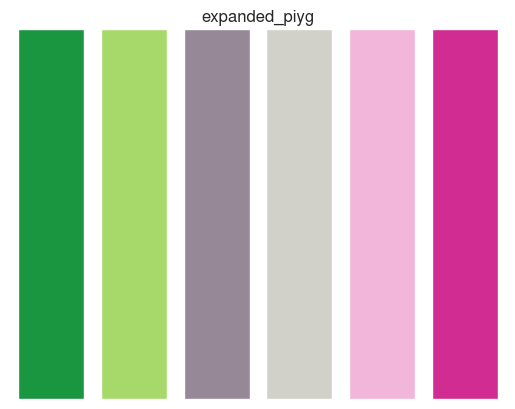

[(0, '#1a9641'),
 (1, '#a6d96a'),
 (2, '#978897'),
 (3, '#d1d1ca'),
 (4, '#f1b6da'),
 (5, '#d02c91')]

In [413]:
### mapping colours to be teh same as last time
# Display the colors in the PiYG color map
visualise.show_colors('expanded_piyg')

# Get the color palette of the PiYG color map
expanded_piyg = visualise.color_palette('expanded_piyg')
[(n, i) for n, i in enumerate(colours.expanded_piyg)]

In [419]:
colour_map_dict = {'RD1':colours.expanded_piyg[0], 
                   'WT': colours.expanded_piyg[1], 
                   'PZA': colours.expanded_piyg[2], 
                   'RIF': colours.expanded_piyg[3], 
                   'INH': colours.expanded_piyg[4], 
                   'BDQ': colours.expanded_piyg[5], 
                   'UNI': '#000000'}

In [418]:
strain

'UNI'

In [417]:
strain in colour_map_dict.keys()

False

### Plot different atb conditions per repeat

/tmp/ipykernel_1217616/3429643671.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/3429643671.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/3429643671.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/3429643671.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


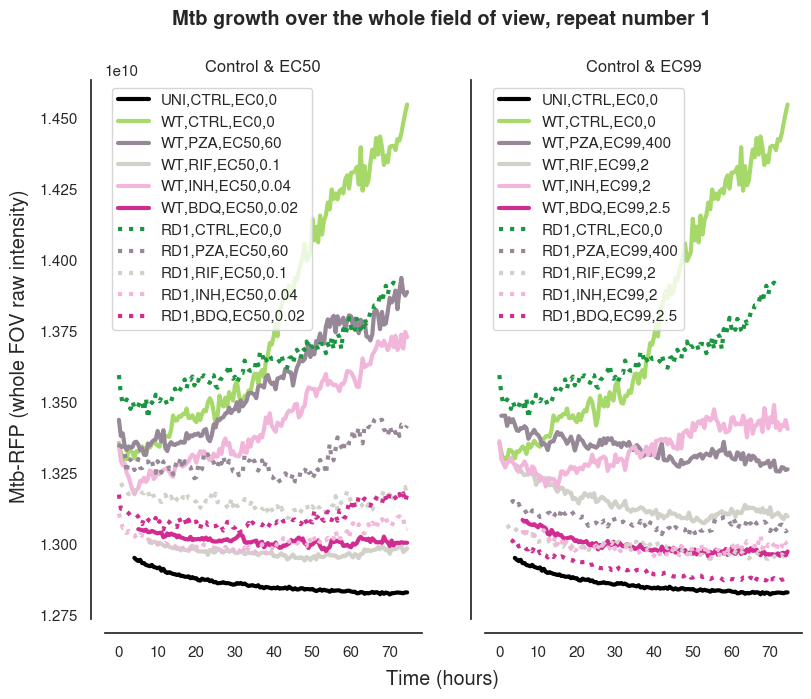

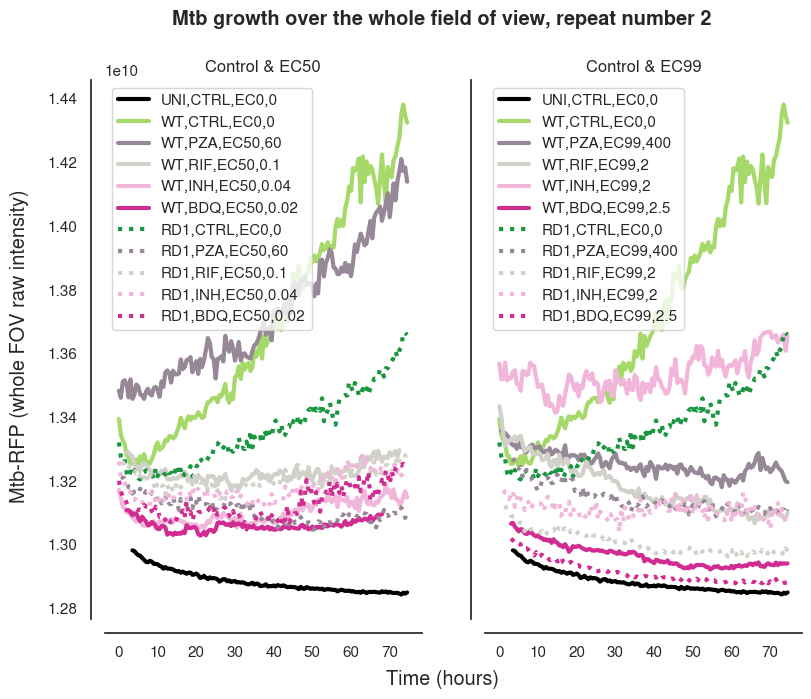

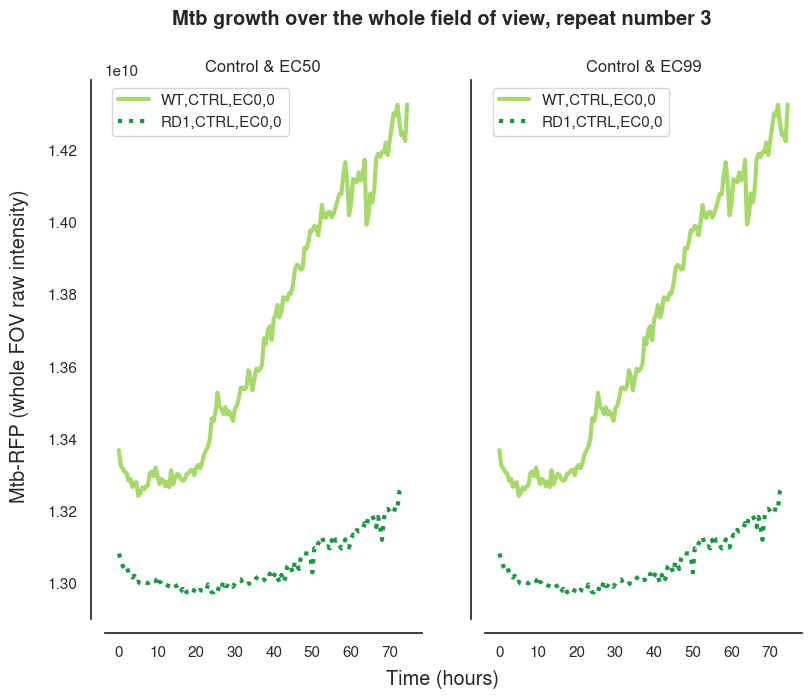

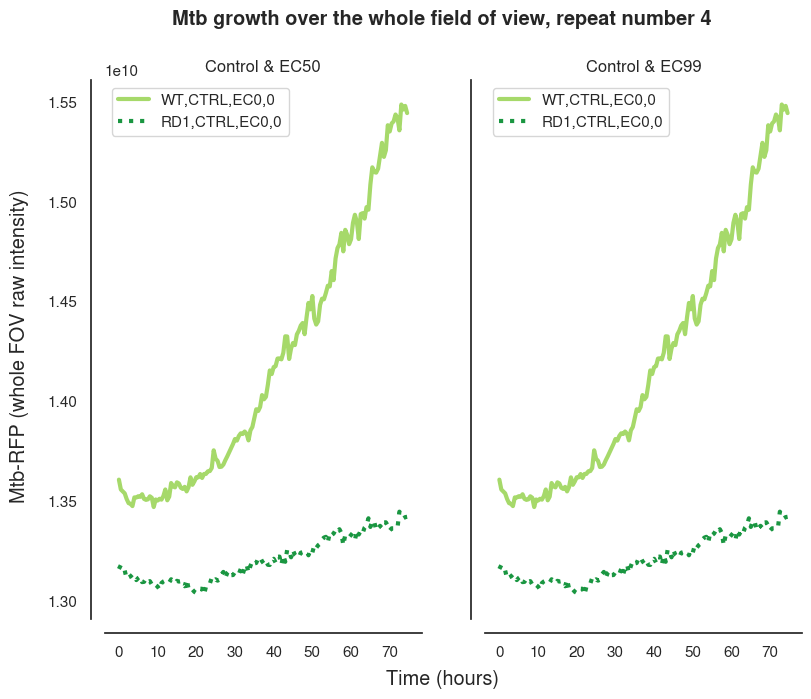

In [422]:
sns.set_palette(expanded_piyg.colors)
# fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))


for repeat_num in assay_layout['Technical repeat'].unique():
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))

    assay_layout_repeat = assay_layout[assay_layout['Technical repeat'] == repeat_num]
    for (row, column), info in assay_layout_repeat.iterrows():
        # if info['Strain'] == 'UNI':
        #     continue
        if info['ConcentrationEC']  in ['EC0', 'EC50']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            LHS = sns.lineplot(data=cleaned_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour)

        if info['ConcentrationEC']  in ['EC0', 'EC99']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]

            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            RHS = sns.lineplot(data=cleaned_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour)

    LHS.set(ylabel=None)
    # Update x-axis labels to represent 30-minute intervals
    x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
    x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
    plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])
    
    # Add subtitles above each graph
    ax[0].set_title("Control & EC50")
    ax[1].set_title("Control & EC99")
    
    plt.ylabel('')
    fig.supxlabel('Time (hours)')
    fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
    plt.suptitle(f'Mtb growth over the whole field of view, repeat number {repeat_num}', fontweight='bold')
    sns.despine(offset=10)
    plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_wRD1_atbs_repeat{repeat_num}.png'), bbox_inches='tight', dpi=314)

    fig.show()



/tmp/ipykernel_1217616/168825270.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/168825270.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/168825270.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/168825270.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


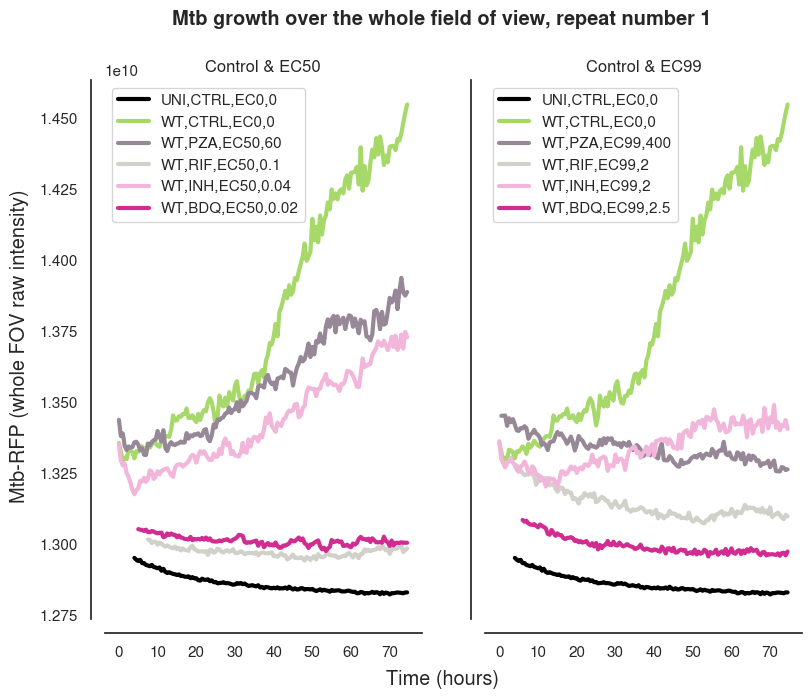

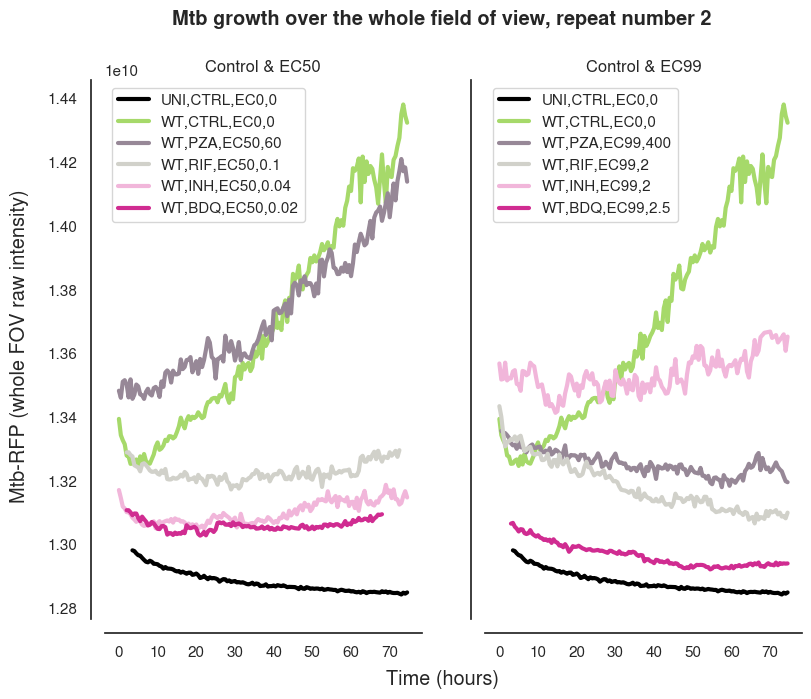

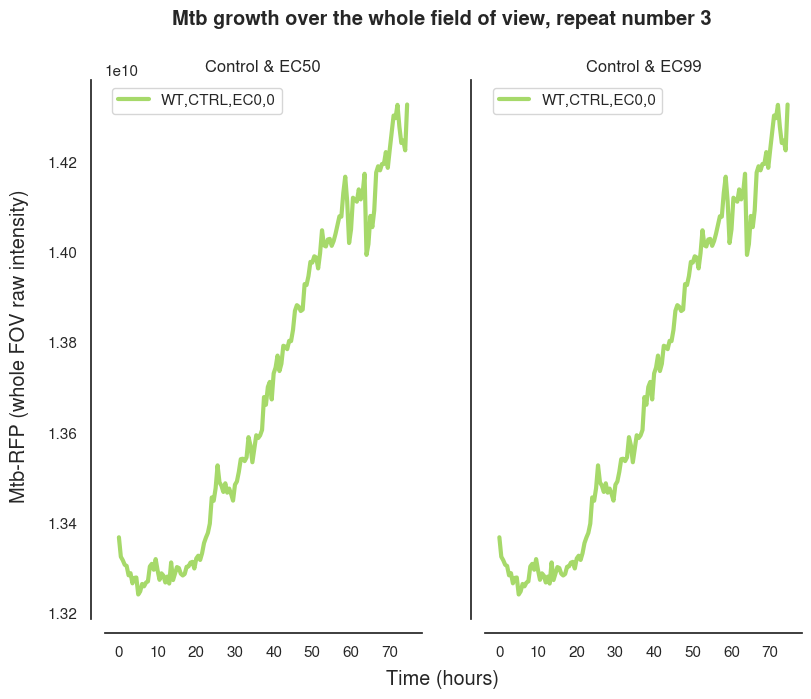

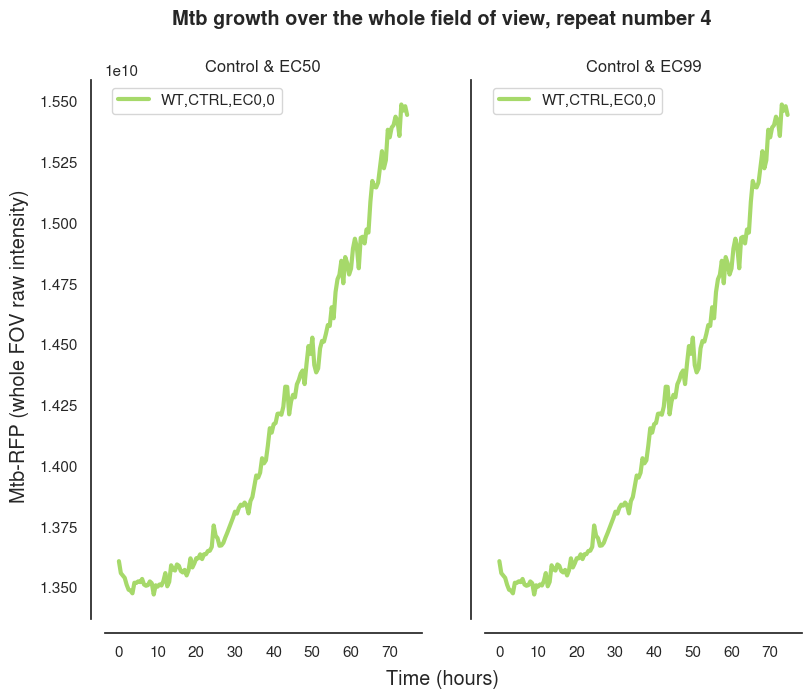

In [423]:
sns.set_palette(expanded_piyg.colors)
# fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))


for repeat_num in assay_layout['Technical repeat'].unique():
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))

    assay_layout_repeat = assay_layout[assay_layout['Technical repeat'] == repeat_num]
    for (row, column), info in assay_layout_repeat.iterrows():
        # if info['Strain'] == 'UNI':
        #     continue
        if info['ConcentrationEC']  in ['EC0', 'EC50']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            if strain == 'RD1':
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]

            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            LHS = sns.lineplot(data=cleaned_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour)

        if info['ConcentrationEC']  in ['EC0', 'EC99']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            if strain == 'RD1':
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            RHS = sns.lineplot(data=cleaned_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour)

    LHS.set(ylabel=None)
    # Update x-axis labels to represent 30-minute intervals
    x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
    x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
    plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])
    
    # Add subtitles above each graph
    ax[0].set_title("Control & EC50")
    ax[1].set_title("Control & EC99")
    
    plt.ylabel('')
    fig.supxlabel('Time (hours)')
    fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
    plt.suptitle(f'Mtb growth over the whole field of view, repeat number {repeat_num}', fontweight='bold')
    sns.despine(offset=10)
    plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_atbs_repeat{repeat_num}.png'), bbox_inches='tight', dpi=314)

    fig.show()



/tmp/ipykernel_1217616/3068862412.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/3068862412.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/3068862412.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/3068862412.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


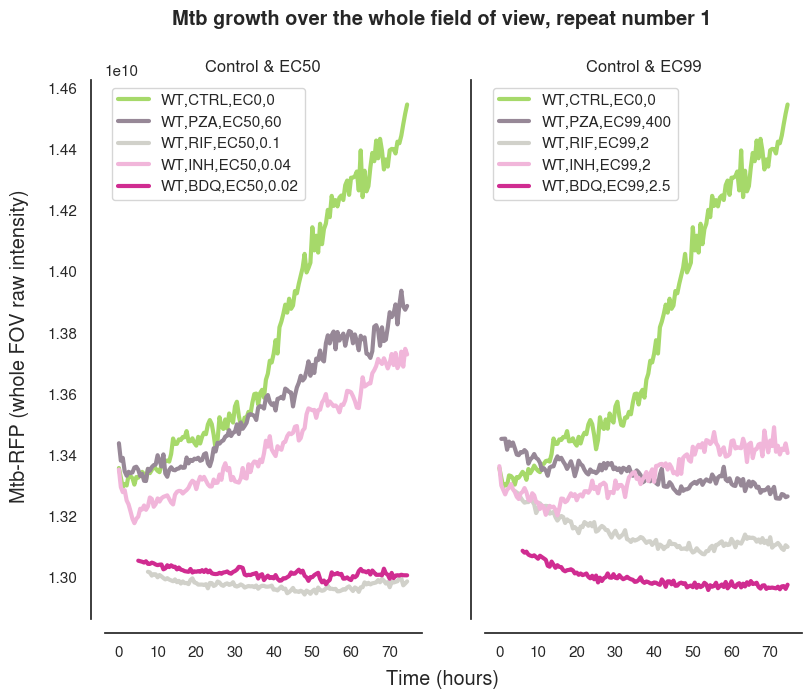

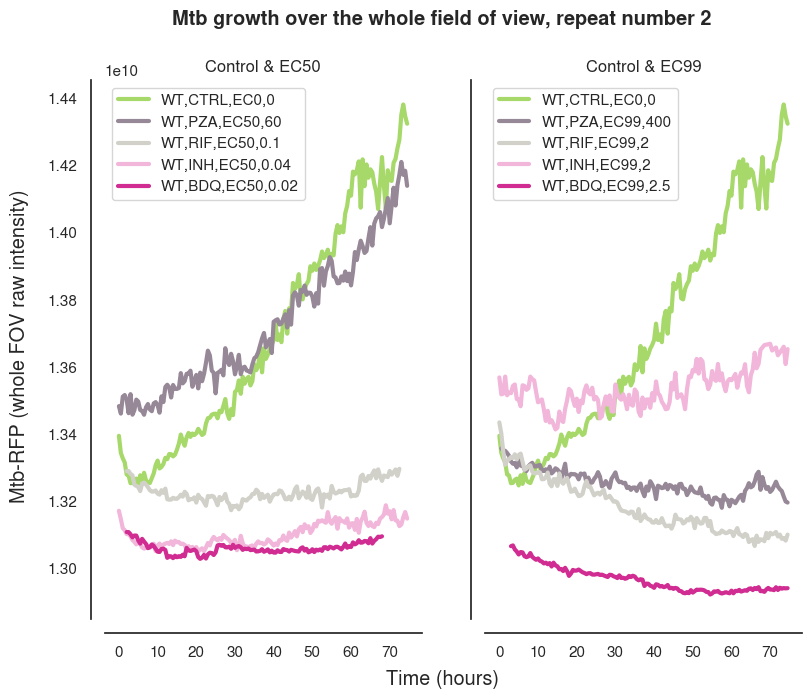

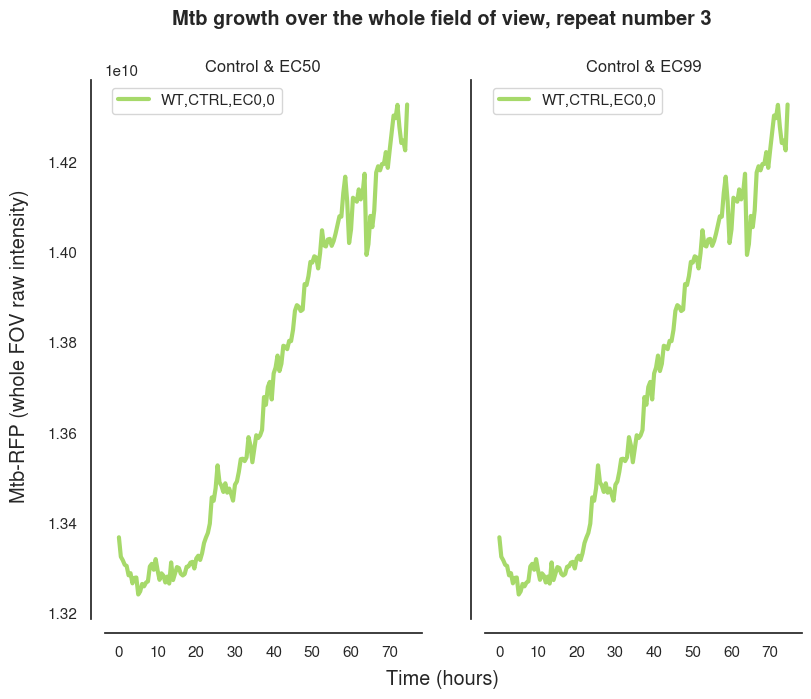

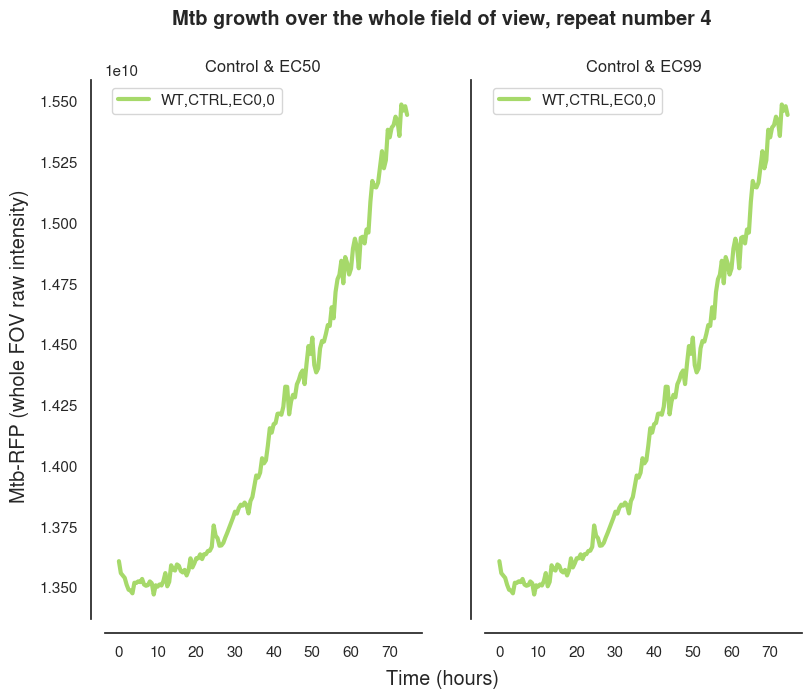

In [424]:
sns.set_palette(expanded_piyg.colors)
# fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))


for repeat_num in assay_layout['Technical repeat'].unique():
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))

    assay_layout_repeat = assay_layout[assay_layout['Technical repeat'] == repeat_num]
    for (row, column), info in assay_layout_repeat.iterrows():
        # if info['Strain'] == 'UNI':
        #     continue
        if info['ConcentrationEC']  in ['EC0', 'EC50']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            if strain in ['RD1', 'UNI']:
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            LHS = sns.lineplot(data=cleaned_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour)

        if info['ConcentrationEC']  in ['EC0', 'EC99']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            if strain in ['RD1', 'UNI']:
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            RHS = sns.lineplot(data=cleaned_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour)

    LHS.set(ylabel=None)
    # Update x-axis labels to represent 30-minute intervals
    x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
    x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
    plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])
    
    # Add subtitles above each graph
    ax[0].set_title("Control & EC50")
    ax[1].set_title("Control & EC99")
    
    plt.ylabel('')
    fig.supxlabel('Time (hours)')
    fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
    plt.suptitle(f'Mtb growth over the whole field of view, repeat number {repeat_num}', fontweight='bold')
    sns.despine(offset=10)

    plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_wo_uni_word1_atbs_repeat{repeat_num}.png'), bbox_inches='tight', dpi=314)

    fig.show()



/tmp/ipykernel_1217616/1349372992.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/1349372992.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/1349372992.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/1349372992.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


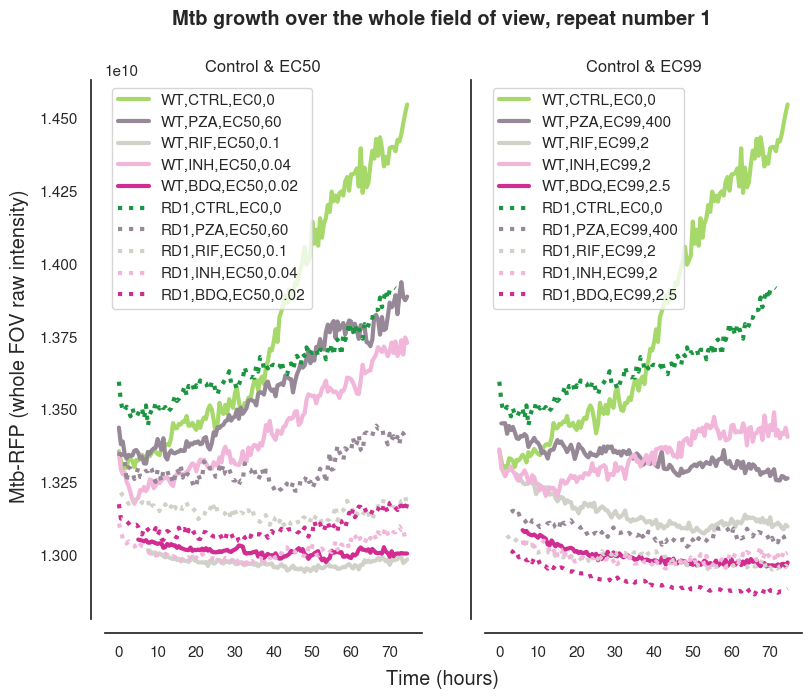

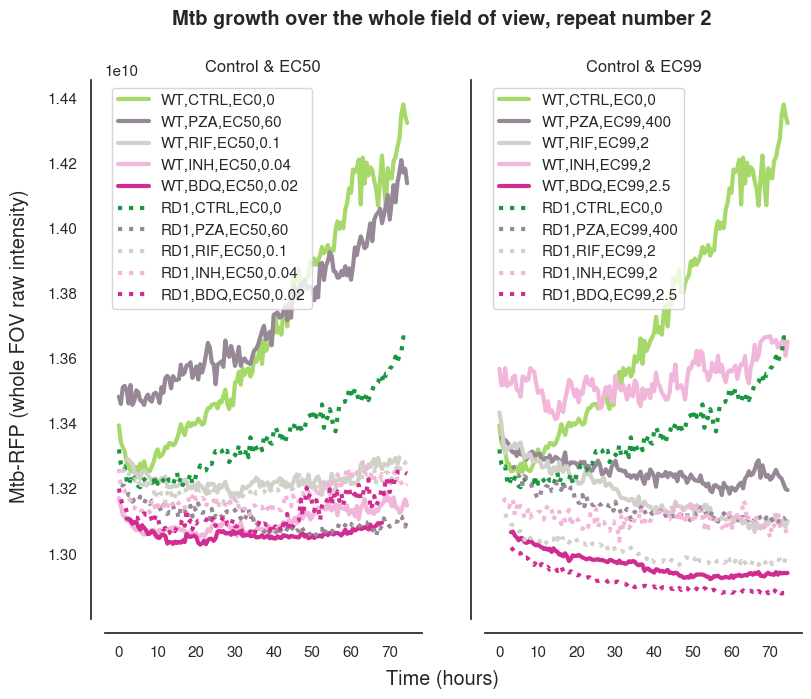

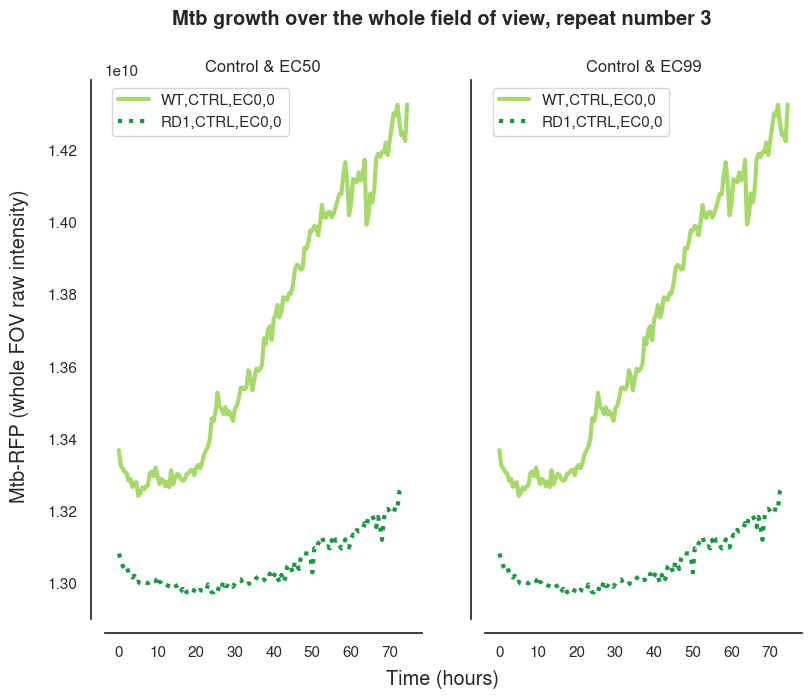

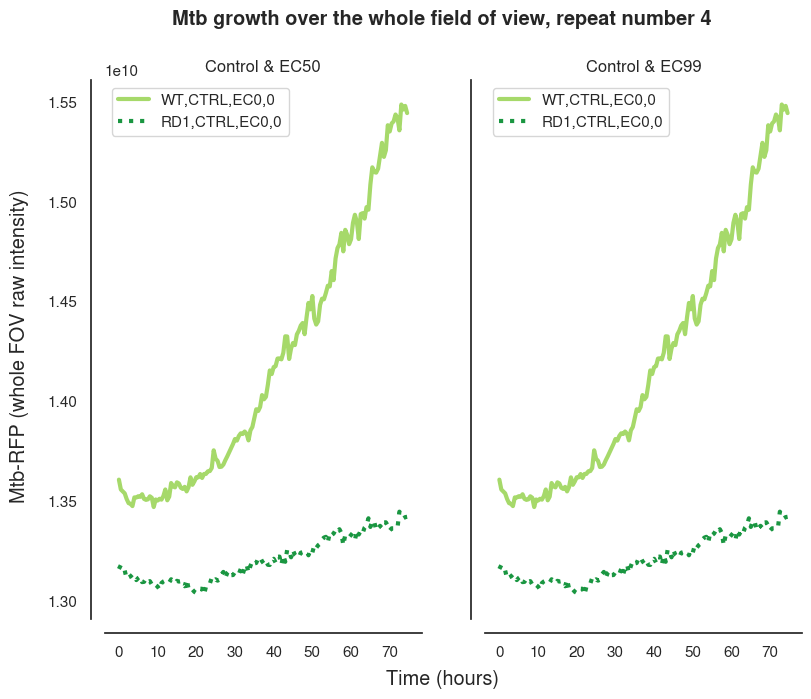

In [425]:
sns.set_palette(expanded_piyg.colors)
# fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))


for repeat_num in assay_layout['Technical repeat'].unique():
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))

    assay_layout_repeat = assay_layout[assay_layout['Technical repeat'] == repeat_num]
    for (row, column), info in assay_layout_repeat.iterrows():
        # if info['Strain'] == 'UNI':
        #     continue
        if info['ConcentrationEC']  in ['EC0', 'EC50']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            if strain in ['UNI']:
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            LHS = sns.lineplot(data=cleaned_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour)

        if info['ConcentrationEC']  in ['EC0', 'EC99']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            if strain in ['UNI']:
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            RHS = sns.lineplot(data=cleaned_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour)

    LHS.set(ylabel=None)
    # Update x-axis labels to represent 30-minute intervals
    x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
    x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
    plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])
    
    # Add subtitles above each graph
    ax[0].set_title("Control & EC50")
    ax[1].set_title("Control & EC99")
    
    plt.ylabel('')
    fig.supxlabel('Time (hours)')
    fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
    plt.suptitle(f'Mtb growth over the whole field of view, repeat number {repeat_num}', fontweight='bold')
    sns.despine(offset=10)

    plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_wo_uni_atbs_repeat{repeat_num}.png'), bbox_inches='tight', dpi=314)

    fig.show()



### Plotting repeats overlaid

In [450]:
assay_layout

Strain Compound Concentration ConcentrationEC  Technical repeat
Row Column                                                                
3   1         UNI     CTRL             0             EC0                 1
    2         UNI     CTRL             0             EC0                 2
    3          WT     CTRL             0             EC0                 1
    4          WT     CTRL             0             EC0                 2
    5          WT      PZA            60            EC50                 1
    6          WT      PZA            60            EC50                 2
    7          WT      RIF           0.1            EC50                 1
    8          WT      RIF           0.1            EC50                 2
    9          WT      INH          0.04            EC50                 1
    10         WT      INH          0.04            EC50                 2
    11         WT      BDQ          0.02            EC50                 1
    12         WT      BDQ          0.02            EC50                 2
4   3          WT     CTRL             0             EC0                 3
    4          WT     CTRL             0             EC0                 4
    5          WT      PZA           400            EC99                 1
    6          WT      PZA           400            EC99                 2
    7          WT      RIF             2            EC99                 1
    8          WT      RIF             2            EC99                 2
    9          WT      INH             2            EC99                 1
    10         WT      INH             2            EC99                 2
    11         WT      BDQ           2.5            EC99                 1
    12         WT      BDQ           2.5            EC99                 2
5   3         RD1     CTRL             0             EC0                 1
    4         RD1     CTRL             0             EC0                 2
    5         RD1      PZA            60            EC50                 1
    6         RD1      PZA            60            EC50                 2
    7         RD1      RIF           0.1            EC50                 1
    8         RD1      RIF           0.1            EC50                 2
    9         RD1      INH          0.04            EC50                 1
    10        RD1      INH          0.04            EC50                 2
    11        RD1      BDQ          0.02            EC50                 1
    12        RD1      BDQ          0.02            EC50                 2
6   3         RD1     CTRL             0             EC0                 3
    4         RD1     CTRL             0             EC0                 4
    5         RD1      PZA           400            EC99                 1
    6         RD1      PZA           400            EC99                 2
    7         RD1      RIF             2            EC99                 1
    8         RD1      RIF             2            EC99                 2
    9         RD1      INH             2            EC99                 1
    10        RD1      INH             2            EC99                 2
    11        RD1      BDQ           2.5            EC99                 1
    12        RD1      BDQ           2.5            EC99                 2

In [449]:
assay_layout[['Strain', 'Compound', 'Concentration', 'ConcentrationEC']].drop_duplicates()

Strain Compound Concentration ConcentrationEC
Row Column                                              
3   1         UNI     CTRL             0             EC0
    3          WT     CTRL             0             EC0
    5          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    9          WT      INH          0.04            EC50
    11         WT      BDQ          0.02            EC50
4   5          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    9          WT      INH             2            EC99
    11         WT      BDQ           2.5            EC99
5   3         RD1     CTRL             0             EC0
    5         RD1      PZA            60            EC50
    7         RD1      RIF           0.1            EC50
    9         RD1      INH          0.04            EC50
    11        RD1      BDQ          0.02            EC50
6   5         RD1      PZA           400            EC99
    7         RD1      RIF             2            EC99
    9         RD1      INH             2            EC99
    11        RD1      BDQ           2.5            EC99

In [451]:
for (row, column), info in assay_layout[['Strain', 'Compound', 'Concentration', 'ConcentrationEC']].drop_duplicates().iterrows():
    print(info)


Strain              UNI
Compound           CTRL
Concentration         0
ConcentrationEC     EC0
Name: (3, 1), dtype: object
Strain               WT
Compound           CTRL
Concentration         0
ConcentrationEC     EC0
Name: (3, 3), dtype: object
Strain               WT
Compound            PZA
Concentration        60
ConcentrationEC    EC50
Name: (3, 5), dtype: object
Strain               WT
Compound            RIF
Concentration       0.1
ConcentrationEC    EC50
Name: (3, 7), dtype: object
Strain               WT
Compound            INH
Concentration      0.04
ConcentrationEC    EC50
Name: (3, 9), dtype: object
Strain               WT
Compound            BDQ
Concentration      0.02
ConcentrationEC    EC50
Name: (3, 11), dtype: object
Strain               WT
Compound            PZA
Concentration       400
ConcentrationEC    EC99
Name: (4, 5), dtype: object
Strain               WT
Compound            RIF
Concentration         2
ConcentrationEC    EC99
Name: (4, 7), dtype: object
Strain 

In [453]:
assay_layout

Strain Compound Concentration ConcentrationEC  Technical repeat
Row Column                                                                
3   1         UNI     CTRL             0             EC0                 1
    2         UNI     CTRL             0             EC0                 2
    3          WT     CTRL             0             EC0                 1
    4          WT     CTRL             0             EC0                 2
    5          WT      PZA            60            EC50                 1
    6          WT      PZA            60            EC50                 2
    7          WT      RIF           0.1            EC50                 1
    8          WT      RIF           0.1            EC50                 2
    9          WT      INH          0.04            EC50                 1
    10         WT      INH          0.04            EC50                 2
    11         WT      BDQ          0.02            EC50                 1
    12         WT      BDQ          0.02            EC50                 2
4   3          WT     CTRL             0             EC0                 3
    4          WT     CTRL             0             EC0                 4
    5          WT      PZA           400            EC99                 1
    6          WT      PZA           400            EC99                 2
    7          WT      RIF             2            EC99                 1
    8          WT      RIF             2            EC99                 2
    9          WT      INH             2            EC99                 1
    10         WT      INH             2            EC99                 2
    11         WT      BDQ           2.5            EC99                 1
    12         WT      BDQ           2.5            EC99                 2
5   3         RD1     CTRL             0             EC0                 1
    4         RD1     CTRL             0             EC0                 2
    5         RD1      PZA            60            EC50                 1
    6         RD1      PZA            60            EC50                 2
    7         RD1      RIF           0.1            EC50                 1
    8         RD1      RIF           0.1            EC50                 2
    9         RD1      INH          0.04            EC50                 1
    10        RD1      INH          0.04            EC50                 2
    11        RD1      BDQ          0.02            EC50                 1
    12        RD1      BDQ          0.02            EC50                 2
6   3         RD1     CTRL             0             EC0                 3
    4         RD1     CTRL             0             EC0                 4
    5         RD1      PZA           400            EC99                 1
    6         RD1      PZA           400            EC99                 2
    7         RD1      RIF             2            EC99                 1
    8         RD1      RIF             2            EC99                 2
    9         RD1      INH             2            EC99                 1
    10        RD1      INH             2            EC99                 2
    11        RD1      BDQ           2.5            EC99                 1
    12        RD1      BDQ           2.5            EC99                 2

In [473]:
cleaned_series

0             1             2             3    \
Row Column                                                           
6   11      1.310772e+10  1.308648e+10  1.307119e+10  1.305876e+10   
    12      1.311994e+10  1.309136e+10  1.305267e+10  1.304545e+10   

                     4             5             6             7    \
Row Column                                                           
6   11      1.304037e+10  1.304033e+10  1.301729e+10  1.301309e+10   
    12      1.304272e+10  1.302610e+10  1.301955e+10  1.301408e+10   

                     8             9    ...           140           141  \
Row Column                              ...                               
6   11      1.299978e+10  1.300731e+10  ...  1.287938e+10  1.287871e+10   
    12      1.300614e+10  1.300051e+10  ...  1.288578e+10  1.287866e+10   

                     142           143           144           145  \
Row Column                                                           
6   11      1.288302e+10  1.287753e+10  1.287248e+10  1.287729e+10   
    12      1.288287e+10  1.289255e+10  1.288116e+10  1.288207e+10   

                     146           147           148           149  
Row Column                                                          
6   11      1.287703e+10  1.287929e+10  1.288263e+10  1.288682e+10  
    12      1.287799e+10  1.288075e+10  1.288131e+10  1.288176e+10  

[2 rows x 150 columns]

In [470]:
assay_layout['Technical repeat'].unique()

array([1, 2, 3, 4])

In [484]:
concat_series

8      1.295410e+10
9      1.294740e+10
10     1.294297e+10
11     1.294719e+10
12     1.293553e+10
           ...     
145    1.284703e+10
146    1.284426e+10
147    1.284991e+10
148    1.284697e+10
149    1.285080e+10
Length: 285, dtype: float64

/tmp/ipykernel_1217616/2323974640.py:105: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


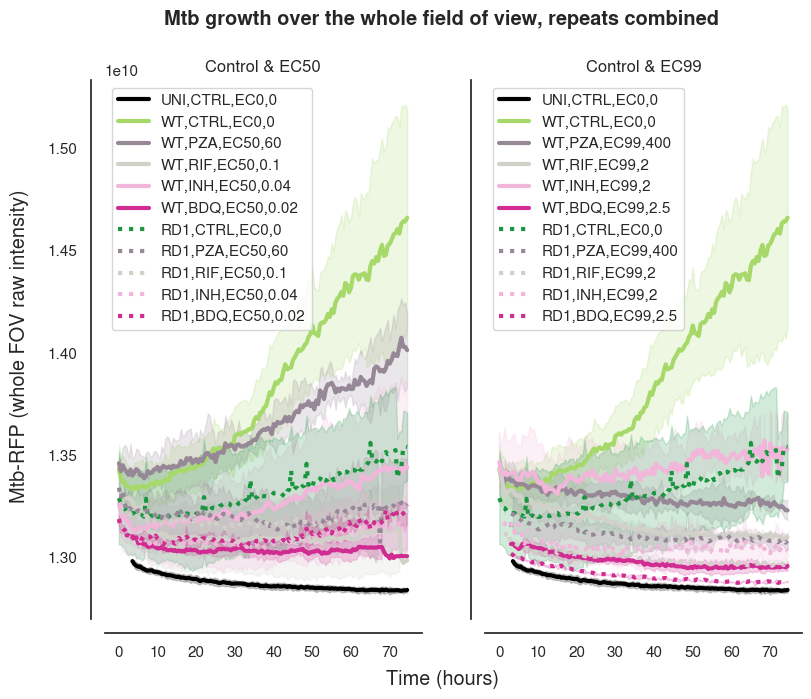

In [498]:
sns.set_palette(expanded_piyg.colors)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))
concat_cond_dict = {}

for (row, column), info in assay_layout[['Strain', 'Compound', 'Concentration', 'ConcentrationEC']].drop_duplicates().iterrows():
    if info['ConcentrationEC']  in ['EC0', 'EC50']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        LHS = sns.lineplot(data=concat_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
        
    if info['ConcentrationEC']  in ['EC0', 'EC99']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        RHS = sns.lineplot(data=concat_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
   
    
LHS.set(ylabel=None)
# Update x-axis labels to represent 30-minute intervals
x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])

# Add subtitles above each graph
ax[0].set_title("Control & EC50")
ax[1].set_title("Control & EC99")

plt.ylabel('')
fig.supxlabel('Time (hours)')
fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
plt.suptitle(f'Mtb growth over the whole field of view, repeats combined', fontweight='bold')
sns.despine(offset=10)

plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_atbs_combined.png'), bbox_inches='tight', dpi=314)

fig.show()



/tmp/ipykernel_1217616/3755018027.py:109: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


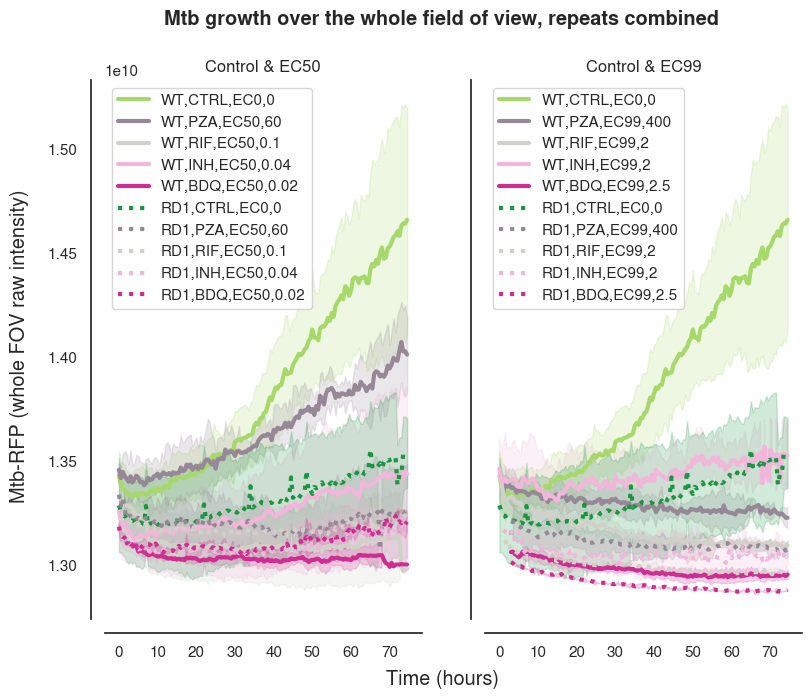

In [499]:
sns.set_palette(expanded_piyg.colors)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))
concat_cond_dict = {}

for (row, column), info in assay_layout[['Strain', 'Compound', 'Concentration', 'ConcentrationEC']].drop_duplicates().iterrows():

    if info['Strain'] in ['UNI']:
            continue
    
    if info['ConcentrationEC']  in ['EC0', 'EC50']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        LHS = sns.lineplot(data=concat_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
        
    if info['ConcentrationEC']  in ['EC0', 'EC99']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        RHS = sns.lineplot(data=concat_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
   
    
LHS.set(ylabel=None)
# Update x-axis labels to represent 30-minute intervals
x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])

# Add subtitles above each graph
ax[0].set_title("Control & EC50")
ax[1].set_title("Control & EC99")

plt.ylabel('')
fig.supxlabel('Time (hours)')
fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
plt.suptitle(f'Mtb growth over the whole field of view, repeats combined', fontweight='bold')
sns.despine(offset=10)

plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_atbs_combined_wo_uni.png'), bbox_inches='tight', dpi=314)

fig.show()



/tmp/ipykernel_1217616/3533890359.py:109: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


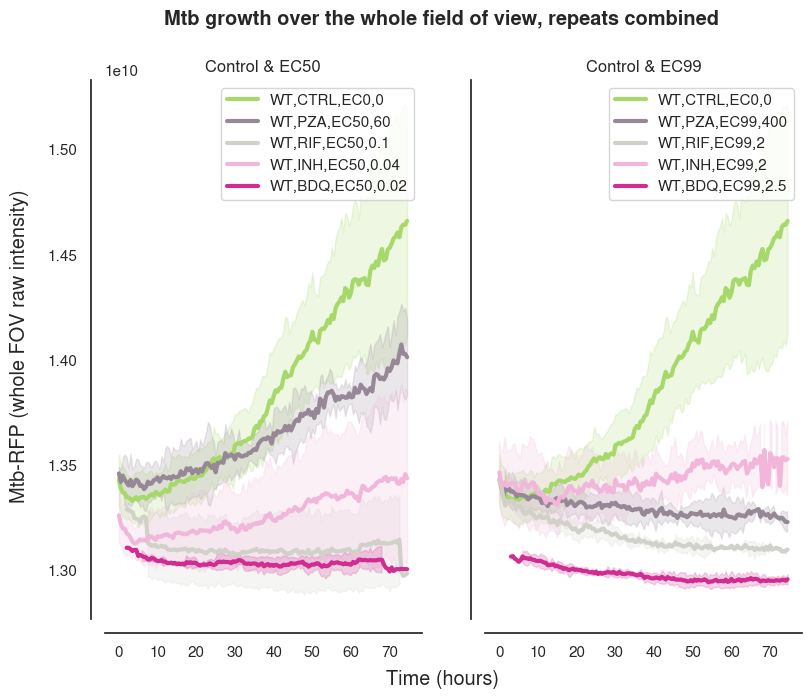

In [500]:
sns.set_palette(expanded_piyg.colors)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))
concat_cond_dict = {}

for (row, column), info in assay_layout[['Strain', 'Compound', 'Concentration', 'ConcentrationEC']].drop_duplicates().iterrows():

    if info['Strain'] in ['UNI', 'RD1']:
            continue
    
    if info['ConcentrationEC']  in ['EC0', 'EC50']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        LHS = sns.lineplot(data=concat_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
        
    if info['ConcentrationEC']  in ['EC0', 'EC99']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        RHS = sns.lineplot(data=concat_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
   
    
LHS.set(ylabel=None)
# Update x-axis labels to represent 30-minute intervals
x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])

# Add subtitles above each graph
ax[0].set_title("Control & EC50")
ax[1].set_title("Control & EC99")

plt.ylabel('')
fig.supxlabel('Time (hours)')
fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
plt.suptitle(f'Mtb growth over the whole field of view, repeats combined', fontweight='bold')
sns.despine(offset=10)

plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_atbs_combined_wo_uni_rd1.png'), bbox_inches='tight', dpi=314)

fig.show()



/tmp/ipykernel_1217616/235941939.py:109: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


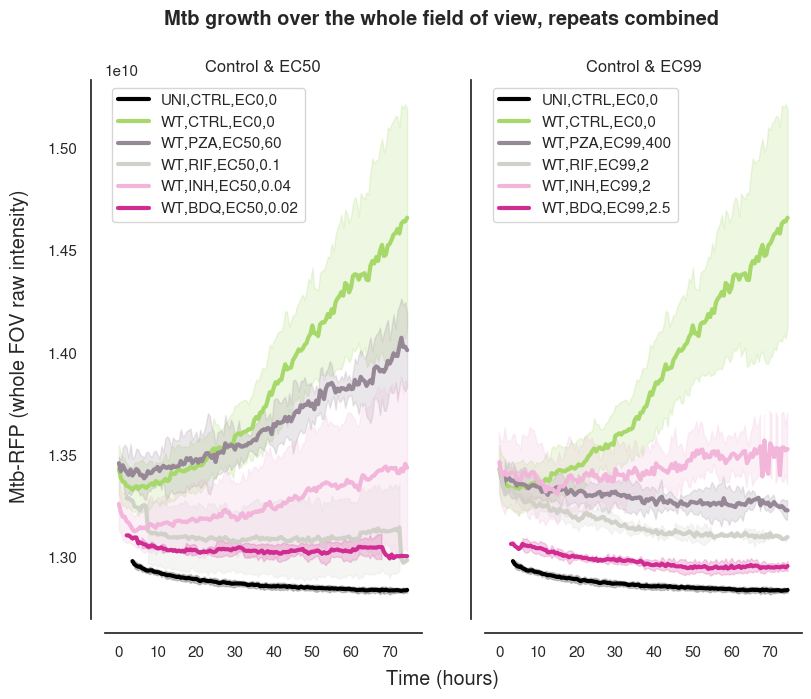

In [501]:
sns.set_palette(expanded_piyg.colors)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))
concat_cond_dict = {}

for (row, column), info in assay_layout[['Strain', 'Compound', 'Concentration', 'ConcentrationEC']].drop_duplicates().iterrows():

    if info['Strain'] in ['RD1']:
            continue
    
    if info['ConcentrationEC']  in ['EC0', 'EC50']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        LHS = sns.lineplot(data=concat_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
        
    if info['ConcentrationEC']  in ['EC0', 'EC99']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        RHS = sns.lineplot(data=concat_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
   
    
LHS.set(ylabel=None)
# Update x-axis labels to represent 30-minute intervals
x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])

# Add subtitles above each graph
ax[0].set_title("Control & EC50")
ax[1].set_title("Control & EC99")

plt.ylabel('')
fig.supxlabel('Time (hours)')
fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
plt.suptitle(f'Mtb growth over the whole field of view, repeats combined', fontweight='bold')
sns.despine(offset=10)

plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_atbs_combined_wo_rd1.png'), bbox_inches='tight', dpi=314)

fig.show()

